In [12]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from queue import Queue
from threading import Thread
np.random.seed(1234)

# SGD Anisotropic Gaussian Neural Net

I implemented a single layer neural network and trained in on jointly Bernoulli and anisotropic Gaussian data constructed in the 2018 paper by Mei et al. entitled 'A mean field view of the landscape of two-layer neural networks' using stochastic gradient descent. I studied limiting properties of the evolution of the network parameters, treated as interacting particles and made comparisons in monitoring losses incurred by the discretised SGD algorithm and the distributional dynamics introduced in the paper.

## SGD dynamics

In [13]:
#Ground truth data distribution
def random_sample_anisotropic(d, Delta, N, s_0):
    """
    Generate random samples from an anisotropic data distribution.

    Parameters:
    d (int): The dimensionality of the data distribution.
    Delta (float): The parameter controlling the spread of data samples.
    N (int): The number of samples to generate.
    s_0 (int): The number of dimensions with increased spread (anisotropy).

    Returns:
    tuple: A tuple containing a data matrix and corresponding labels.
           The data matrix has shape (N, d), and the labels are binary.
    """
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*s_0 + [1]*(d-s_0)), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*s_0 + [1]*(d-s_0)), N-successes)
    
    return x.reshape(N,d),y

In [14]:
#Relu activation function
def neural_net_relu(a,b,w,x):
    """
    Compute the output of a neural network with ReLU activation function.

    Parameters:
    a (ndarray): Shape (1, N), the output layer weights.
    b (ndarray): Shape (1, N), the bias for the output layer.
    w (ndarray): Shape (N, d), the weights for the hidden layer.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (1, n), the network's output for the given input data.
    """
    n = x.shape[0]
    return np.mean(a.T*np.maximum(w@x.T+b.T, 0), axis = 0).reshape(1,n)

def vneural_net(a, b, w, x):
    """
    Compute the output of a neural network for multiple parameter sets.

    Parameters:
    a (ndarray): Shape (M, N), the output layer weights for M parameter sets.
    b (ndarray): Shape (M, N), the bias for the output layer for M parameter sets.
    w (ndarray): Shape (M, N, d), the weights for the hidden layer for M parameter sets.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (M, n), the network's output for the given input data and M parameter sets.
    """
    N = w.shape[1]
    d = w.shape[2]
    M = w.shape[0]
    n = x.shape[0]
    
    for m in range(M):
        out = np.array([neural_net_relu(a[m,:].reshape(1,-1),b[m,:].reshape(1,-1),w[m,:,:].reshape((N,d)), x)\
                               for m in range(M)])
    
    return out.reshape(M,n)
    
def relu(a,b,w,x):
    """
    Compute the ReLU activation of a neural network.

    Parameters:
    a (ndarray): Shape (1, N), the output layer weights.
    b (ndarray): Shape (1, N), the bias for the output layer.
    w (ndarray): Shape (N, d), the weights for the hidden layer.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (N, n), the ReLU activation of the network for the given input data.
    """
    N = w.shape[0]
    n = x.shape[0]
    return (a.T*np.maximum(w@x.T+b.T, 0)).reshape(N,n)

def vrelu(a,b,w,x):
    """
    Compute the ReLU activation of a neural network for multiple parameter sets.

    Parameters:
    a (ndarray): Shape (M, N), the output layer weights for M parameter sets.
    b (ndarray): Shape (M, N), the bias for the output layer for M parameter sets.
    w (ndarray): Shape (M, N, d), the weights for the hidden layer for M parameter sets.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (M, N, n), the ReLU activation of the network for the given input data and M parameter sets.
    """

    N = w.shape[1]
    d = w.shape[2]
    n = x.shape[0]
    M = w.shape[0]
    
    for m in range(M):
        out = np.array([relu(a[m,:].reshape(1,-1),b[m,:].reshape(1,-1),w[m,:,:].reshape((N,d)), x)\
                               for m in range(M)])
    
    return out.reshape((M,N,n))

def drelu(t):
    """
    Compute the derivative of the ReLU activation function.

    Parameters:
    t (float or ndarray): Input value(s) of the ReLU function.

    Returns:
    float or ndarray: The derivative(s) of the ReLU function at the input(s).
    """
    if t>0:
        return 1
    else:
        return 0
drelu = np.vectorize(drelu)

def grad_sigma_relu(a,b,w,x):
    """
    Compute the gradients of the ReLU activation with respect to its parameters.

    Parameters:
    a (ndarray): Shape (1, N), the output layer weights.
    b (ndarray): Shape (1, N), the bias for the output layer.
    w (ndarray): Shape (N, d), the weights for the hidden layer.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    tuple: A tuple containing the gradients da, db, and dw.
           - da (ndarray): Shape (N, n), gradient of the output weights.
           - db (ndarray): Shape (N, n), gradient of the output bias.
           - dw (ndarray): Shape (N, d), gradient of the hidden layer weights.
    """
    
    n = x.shape[0]
    N = w.shape[0]
    d = w.shape[1]
    
    da = relu(a,b,w,x).reshape(n,N)
    db = a*drelu(w@x.T+b.T).reshape(n,N)
    dw = ((a.T*drelu(w@x.T+b.T))*x).reshape(N,d)
    
    return da, db, dw

def vgrad_sigma_relu(a,b,w,x):
    """
    Compute the gradients of the ReLU activation for multiple parameter sets.

    Parameters:
    a (ndarray): Shape (M, N), the output layer weights for M parameter sets.
    b (ndarray): Shape (M, N), the bias for the output layer for M parameter sets.
    w (ndarray): Shape (M, N, d), the weights for the hidden layer for M parameter sets.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    tuple: A tuple containing the gradients da, db, and dw for M parameter sets.
           - da (ndarray): Shape (M, N, n), gradients of the output weights.
           - db (ndarray): Shape (M, N, n), gradients of the output bias.
           - dw (ndarray): Shape (M, N, d), gradients of the hidden layer weights.
    """

    n = x.shape[0]
    N = w.shape[1]
    d = w.shape[2]
    M = w.shape[0]
        
    da = vrelu(a,b,w,x).reshape(M,N)
    
    out_b = np.array([(a[m].reshape(1,-1))*drelu(w[m].reshape(N,d)@x.T+b[m].reshape(1,-1).T).reshape(1,N)\
                               for m in range(M)])    
    db = out_b.reshape(M,N)
    
    out_w = np.array([(a[m].reshape(1,-1).T*drelu(w[m].reshape(N,d)@x.T+b[m].reshape(1,-1).T))*x\
                               for m in range(M)])
    
    dw = out_w.reshape(M,N,d)
    
    return da, db, dw

In [15]:
def stochastic_gradient_descent(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using stochastic gradient descent.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        da, db, dw = grad_sigma_relu(a,b,weights,x)
        
        f = neural_net_relu(a, b, weights, x)
        
        weights += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*dw
        a += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*da
        b += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*db
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample.reshape(1,-1)-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [16]:
def nesterov_accelerated_gd(d, s_0, Delta, N, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using Nesterov accelerated gradient descent.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    r (int): Nesterov momentum parameter (default is 3).
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        lr = epsilon*(epoch*epsilon)**(-0.25)
        
        da, db, dw = grad_sigma_relu(a_change,b_change,weights_change,x)
        
        f = neural_net_relu(a_change, b_change, weights_change, x)
        
        new_weights = weights_change + 2*lr*(y-f)*dw
        new_a = a_change + 2*lr*(y-f)*da
        new_b = b_change + 2*lr*(y-f)*db
        
        weights_change = new_weights + (0.9)**epoch*(new_weights-weights)
        a_change = new_a + (0.9)**epoch*(new_a - a)
        b_change = new_b + (0.9)**epoch*(new_b - b) 
        # (epoch-1)/(epoch+r-1), r>=3

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample.reshape(1,-1)-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [104]:
def grad_restart_nesterov(d, s_0, Delta, N, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using Gradient restarted Nesterov accelerated gradient descent.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    r (int): Nesterov momentum parameter (default is 3).
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    count = 1
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        lr = epsilon*(epoch*epsilon)**(-0.25)
        
        da, db, dw = grad_sigma_relu(a_change,b_change,weights_change,x)
        
        f = neural_net_relu(a_change, b_change, weights_change, x)
        
        new_weights = weights_change + 2*lr*(y-f)*dw
        new_a = a_change + 2*lr*(y-f)*da
        new_b = b_change + 2*lr*(y-f)*db
        
        weights_change = new_weights + ((count-1)/(count+2))*(new_weights-weights)
        a_change = new_a + ((count-1)/(count+2))*(new_a - a)
        b_change = new_b + ((count-1)/(count+2))*(new_b - b) 
        
        if np.sum((new_weights-weights)*2*(y-f)*dw)+ np.sum((new_a-a)*2*(y-f)*da) \
        + np.sum((new_b-b)*2*(y-f)*db)< 0:
                count = 1
        count += 1

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample.reshape(1,-1)-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [106]:
def Mass(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using the Momentum-added Stochastic Solver (MP-SGD) algorithm.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """

    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    count = 1
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        lr = epsilon*(epoch*epsilon)**(-0.25)
        
        da, db, dw = grad_sigma_relu(a_change,b_change,weights_change,x)
        
        f = neural_net_relu(a_change, b_change, weights_change, x)
        
        new_weights = weights_change + 2*lr*(y-f)*dw
        new_a = a_change + 2*lr*(y-f)*da
        new_b = b_change + 2*lr*(y-f)*db
        
        m = 10
        eta2 = lr/m
        
        weights_change = new_weights + ((count-1)/(count+2))*(new_weights-weights)- eta2*2*(y-f)*dw
        a_change = new_a + ((count-1)/(count+2))*(new_a - a)- eta2*2*(y-f)*da
        b_change = new_b + ((count-1)/(count+2))*(new_b - b) - eta2*2*(y-f)*db
        
        if np.sum((new_weights-weights)*2*(y-f)*dw)+ np.sum((new_a-a)*2*(y-f)*da) \
        + np.sum((new_b-b)*2*(y-f)*db)< 0:
                count = 1
        count += 1

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample.reshape(1,-1)-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [19]:
def nesterov_heat_gd(d, s_0, Delta, N, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using Nesterov Accelerated Gradient Descent with noise.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    r (int): Parameter for Nesterov acceleration.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        grad_w = np.zeros((N,d))
        grad_a = np.zeros((1,N))
        grad_b = np.zeros((1,N))
        
        for i in range(10):
            heat_a = np.random.normal(0,1/epoch,a_change.shape)
            heat_b = np.random.normal(0,1/epoch,b_change.shape)
            heat_w = random_sample_anisotropic(d,Delta,N,s_0)[0].reshape((N,d))/epoch
            #np.random.normal(0,1/epoch,weights_change.shape)

            a_change_loc = a_change + heat_a
            b_change_loc = b_change + heat_b
            weights_change_loc = weights_change + heat_w

            da, db, dw = grad_sigma_relu(a_change_loc,b_change_loc,weights_change_loc,x)
        
            f = neural_net_relu(a_change_loc, b_change_loc, weights_change_loc, x)
            
            grad_w += 2*(y-f)*dw
            grad_a += 2*(y-f)*da
            grad_b += 2*(y-f)*db 
        
        new_weights = weights_change + epsilon*(epoch*epsilon)**(-0.25)*grad_w/10
        new_a = a_change + epsilon*(epoch*epsilon)**(-0.25)*grad_a/10
        new_b = b_change + epsilon*(epoch*epsilon)**(-0.25)*grad_b/10
        
        weights_change = new_weights + 0.9*(new_weights-weights) 
        a_change = new_a + 0.9*(new_a - a)
        b_change = new_b + 0.9*(new_b - b) 

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample.reshape(1,-1)-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [20]:
def MF_Hom_SGLD(d, s_0, Delta, N, M = 20, λ = 10, epsilon = 1e-5, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using the Discretized mean field Stochastic Gradient Langevin Dynamics with homogenization (MF-Hom-SGLD) algorithm in an anisotropic setting.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    M (int): Number of Langevin steps per epoch.
    λ (float): Regularization parameter.
    epsilon (float): Learning rate.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    """
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]

    #initialise params
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((N, d))
    Y_a = np.zeros((1, N))
    Y_b = np.zeros((1, N))
    
    risk = []
    
    for epoch in trange(1, num_epochs+1): 
        
        #sample from data
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        #update Y
        Y_w_1 = np.zeros((N, d))
        Y_a_1 = np.zeros((1,N))
        Y_b_1 = np.zeros((1, N))
        Y_w_1 = Y_w
        Y_a_1 = Y_a
        Y_b_1 = Y_b
        
        cal_Y_w = np.zeros((N, d))
        cal_Y_a = np.zeros((1, N))
        cal_Y_b = np.zeros((1, N))
        
        for m in range(1,M+1):
            δ = 0.001
            γ = 0.001
            β = 10
            f = neural_net_relu(Y_a_1.reshape(1,-1), Y_b_1.reshape(1,-1),\
                                Y_w_1.reshape((N,d)) , x)
            da, db, dw = grad_sigma_relu(Y_a_1.reshape(1,-1), Y_b_1.reshape(1,-1),\
                                Y_w_1.reshape((N,d)),x)
            da *= 2*(y-f)
            db *= 2*(y-f)
            dw *= 2*(y-f)
                        
            Y_w_1 = Y_w_1 - δ*(dw-(1/γ)*(weights-Y_w_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
            
            Y_a_1 = Y_a_1 - δ*(da-(1/γ)*(a-Y_a_1)) + np.sqrt(2*(δ/β))\
            *np.random.normal(0,1, N)
            
            Y_b_1 = Y_b_1 - δ*(db-(1/γ)*(b-Y_b_1)) + np.sqrt(2*(δ/β))\
            *np.random.normal(0,1,N)
            
            cal_Y_w += Y_w_1
            cal_Y_a += Y_a_1
            cal_Y_b += Y_b_1
            
        Y_w = Y_w_1
        Y_a = Y_a_1
        Y_b = Y_b_1
                    
        cal_Y_w /= M
        cal_Y_a /= M
        cal_Y_b /= M
        
        #update model parameters
        Δ = epsilon*(epoch*epsilon)**(-0.25)
        X = np.hstack((weights, a.T, b.T))
        mu = np.mean(X, axis = 1).reshape(1,N)
        weights = weights - 1/γ*(weights-cal_Y_w)*Δ - λ*(weights - mu.T)*Δ
        a = a - 1/γ*(a-cal_Y_a)*Δ - λ*(a - mu)*Δ
        b = b - 1/γ*(b-cal_Y_b)*Δ - λ*(b - mu)*Δ
            
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample.reshape(1,-1)-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk)

In [103]:
#simulate HomSGLD

weights_HomSGLD, risk_HomSGLD =\
MF_Hom_SGLD(32, 6, 0.4, 80, M = 20, epsilon = (1e-5), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 1.7295165595736264
Epoch: 2, MSE: 1.9883945434873886
Epoch: 5, MSE: 2.0201313179860336
Epoch: 7, MSE: 1.9584582098766024
Epoch: 10, MSE: 1.8810539332793124
Epoch: 12, MSE: 2.0724993761820127
Epoch: 20, MSE: 1.8940287165047327
Epoch: 32, MSE: 1.8702870769757574
Epoch: 51, MSE: 1.802514428729906
Epoch: 83, MSE: 1.7481680645273658
Epoch: 133, MSE: 1.804649148763825


KeyboardInterrupt: 

In [113]:
#simulate vanilla sgd

weights, risk_SGD, a_SGD, b_SGD, r1_SGD =\
stochastic_gradient_descent(32, 6, 0.4, 80, epsilon = (1e-5), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.11761785194376
Epoch: 2, MSE: 2.071660063232116
Epoch: 5, MSE: 2.1888591723298356
Epoch: 7, MSE: 2.089857720091374
Epoch: 10, MSE: 2.054421550849159
Epoch: 12, MSE: 2.0437719025637744
Epoch: 20, MSE: 2.193402185548845
Epoch: 32, MSE: 2.1595676830366597
Epoch: 51, MSE: 2.140346482776289
Epoch: 83, MSE: 2.1212490680812337
Epoch: 133, MSE: 1.9244247893477169
Epoch: 214, MSE: 1.9805228214586275
Epoch: 344, MSE: 1.955377533001192
Epoch: 552, MSE: 1.7986171137869191
Epoch: 885, MSE: 1.8448622151307696
Epoch: 1421, MSE: 1.7990919866251764
Epoch: 2279, MSE: 1.5168904174375362
Epoch: 3657, MSE: 1.5498098950609298
Epoch: 5867, MSE: 1.4074275527417945
Epoch: 9412, MSE: 1.2800376049522795
Epoch: 15098, MSE: 1.2363363338421125
Epoch: 24222, MSE: 1.1366088789455124
Epoch: 38857, MSE: 1.1311821065248457
Epoch: 62335, MSE: 1.062999627652387
Epoch: 100000, MSE: 1.0229217926072223


In [33]:
#simulate Nesterov sgd

weights_NSGD, risk_NSGD, a_NSGD, b_NSGD, r1_NSGD =\
nesterov_accelerated_gd(32, 6, 0.4, 80, epsilon = (1e-5), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.064877581793101
Epoch: 2, MSE: 2.083863960136887
Epoch: 5, MSE: 2.1389399629496237
Epoch: 7, MSE: 2.071126839957572
Epoch: 10, MSE: 2.1126727022260594
Epoch: 12, MSE: 1.9261649476631426
Epoch: 20, MSE: 1.9997083218207636
Epoch: 32, MSE: 2.049953411029806
Epoch: 51, MSE: 1.9023151588059626
Epoch: 83, MSE: 1.930144947133462
Epoch: 133, MSE: 2.013367935337564
Epoch: 214, MSE: 1.8778998072780833
Epoch: 344, MSE: 1.915677888803394
Epoch: 552, MSE: 1.8091083853587187
Epoch: 885, MSE: 1.7357435448965952
Epoch: 1421, MSE: 1.8162168638389709
Epoch: 2279, MSE: 1.6476797415930486
Epoch: 3657, MSE: 1.549766938223547
Epoch: 5867, MSE: 1.4078226215751382
Epoch: 9412, MSE: 1.3306593105732556
Epoch: 15098, MSE: 1.229526603853125
Epoch: 24222, MSE: 1.1365376011556592
Epoch: 38857, MSE: 1.1252278517380585
Epoch: 62335, MSE: 1.0562135297818085
Epoch: 100000, MSE: 1.006486202658087


In [110]:
#simulate Nesterov sgd

weights_restarted_NSGD, risk_restarted_NSGD, a_restarted_NSGD, b_restarted_NSGD, r1_restarted_NSGD =\
grad_restart_nesterov(32, 6, 0.4, 80, epsilon = (1e-5), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.070417226186877
Epoch: 2, MSE: 1.9880895570194392
Epoch: 5, MSE: 2.15016778636626
Epoch: 7, MSE: 2.065740525923096
Epoch: 10, MSE: 2.041667215599006
Epoch: 12, MSE: 2.0762502270358794
Epoch: 20, MSE: 2.120946900286314
Epoch: 32, MSE: 2.0105317825957787
Epoch: 51, MSE: 1.9562771000082948
Epoch: 83, MSE: 1.9251159820816788
Epoch: 133, MSE: 1.83354636666681
Epoch: 214, MSE: 1.894934662793875
Epoch: 344, MSE: 1.6926836447141071
Epoch: 552, MSE: 1.6765997737742813
Epoch: 885, MSE: 1.5915728607871205
Epoch: 1421, MSE: 1.4448730170407393
Epoch: 2279, MSE: 1.323234864483899
Epoch: 3657, MSE: 1.1276859221577278
Epoch: 5867, MSE: 1.040868850599456
Epoch: 9412, MSE: 1.0056427583456042
Epoch: 15098, MSE: 0.9577585546612529
Epoch: 24222, MSE: 0.8700871112467015
Epoch: 38857, MSE: 0.7666810378907606
Epoch: 62335, MSE: 0.7159483409296543
Epoch: 100000, MSE: 0.7243930726378064


In [107]:
#simulate mass sgd

weights, risk_Mass, a_Mass, b_Mass, r1_Mass =\
Mass(32, 6, 0.4, 80, epsilon = (1e-5), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.1361647149591483
Epoch: 2, MSE: 2.1266602514084916
Epoch: 5, MSE: 2.0126068965568247
Epoch: 7, MSE: 2.0478101385741887
Epoch: 10, MSE: 1.9843853993422842
Epoch: 12, MSE: 2.108053928510296
Epoch: 20, MSE: 2.0506079387796468
Epoch: 32, MSE: 2.0053321939210553
Epoch: 51, MSE: 2.0385219697799695
Epoch: 83, MSE: 1.9738869795010516
Epoch: 133, MSE: 1.8663404358116058
Epoch: 214, MSE: 1.7827973919754176
Epoch: 344, MSE: 1.8932760547911702
Epoch: 552, MSE: 1.5864497300113045
Epoch: 885, MSE: 1.592719527425586
Epoch: 1421, MSE: 1.4472647712651743
Epoch: 2279, MSE: 1.3012976971657997
Epoch: 3657, MSE: 1.1896493676192466
Epoch: 5867, MSE: 1.0968675447624263
Epoch: 9412, MSE: 1.0207541656452461
Epoch: 15098, MSE: 0.971733251832967
Epoch: 24222, MSE: 0.8987555075208006
Epoch: 38857, MSE: 0.7555391234979851
Epoch: 62335, MSE: 0.7148762476137206
Epoch: 100000, MSE: 0.7240920104615888


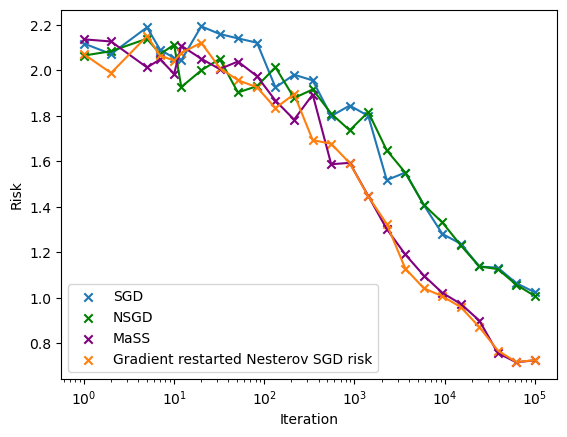

In [116]:
#plot SGD and Nesterov SGD losses
indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(1e5), 20))]
indices_Hom = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(1e4), 20))]

plt.plot(indices, risk_SGD)
plt.scatter(indices, risk_SGD, marker = 'x', label = 'SGD')
plt.plot(indices, risk_NSGD, c = 'g')
plt.scatter(indices, risk_NSGD, marker = 'x', label = 'NSGD', c = 'g')
#plt.plot(indices, risk_HNSGD, c = 'r')
#plt.scatter(indices, risk_HNSGD, marker = 'x', c = 'r', label = 'Heat NSGLD risk')
plt.plot(indices, risk_Mass, c = 'purple')
plt.scatter(indices, risk_Mass, marker = 'x', c = 'purple', label = 'MaSS')
plt.plot(indices, risk_restarted_NSGD)
plt.scatter(indices, risk_restarted_NSGD, marker = 'x', label = 'Gradient restarted Nesterov SGD risk')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
#plt.title('SGD risk for Anisotropic Gaussian')
plt.savefig("/Users/pantelistassopoulos/Documents/texfiles/Summer-Research-2023/images/Nguyen2018-SGD-algos-risk-aniso-gauss.png")
plt.show()

## PDE simulation

In [35]:
from scipy.stats import norm

def q_plus(r1, r2, b, Delta):
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_plus))+root_plus*norm.pdf(b/root_plus)

def q_minus(r1, r2, b, Delta):
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_minus))+root_minus*norm.pdf(b/root_minus)

def dq_plus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    
    droot_plus_1 = (1+Delta)**2*r1/root_plus
    droot_plus_2 = r2/root_plus
    
    db = norm.cdf(b/(root_plus)) + b/(root_plus)*norm.pdf(b/root_plus) + d_normal(b/root_plus)
    dr1 = -droot_plus_1/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_1*norm.pdf(b/root_plus)-b*droot_plus_1/(root_plus**2)*d_normal(b/root_plus)
    dr2 = -droot_plus_2/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_2*norm.pdf(b/root_plus) -b*droot_plus_2/(root_plus**2)*d_normal(b/root_plus)
    return db, dr1, dr2

def dq_minus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    
    droot_minus_1 = (1-Delta)**2*r1/root_minus
    droot_minus_2 = r2/root_minus
    
    db = norm.cdf(b/(root_minus)) + b/(root_minus)*norm.pdf(b/root_minus) + d_normal(b/root_minus)
    dr1 = -droot_minus_1/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_1*norm.pdf(b/root_minus) - b*droot_minus_1/(root_minus**2)*d_normal(b/root_minus)
    dr2 = -droot_minus_2/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_2*norm.pdf(b/root_minus) -b*droot_minus_2/(root_minus**2)*d_normal(b/root_minus)
    return db, dr1, dr2

def R_inf(r, Delta):
    #shape of r is (J, 4)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    plus = a*q_plus(r1, r2, b, Delta)
    minus = a*q_minus(r1, r2, b, Delta)

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    return 0.5 * (1 - mean_q_plus) ** 2 + 0.5 * (1 + mean_q_minus) ** 2

def grad_R_inf(r, Delta):
    
    #shape of r: (J, 4)
    #shape of grad: (J, 4)
    
    J = len(r)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    Q_plus = q_plus(r1, r2, b, Delta)
    Q_minus = q_minus(r1, r2, b, Delta)
    
    plus = a*Q_plus
    minus = a*Q_minus

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    
    db_plus, dr1_plus, dr2_plus = dq_plus(r1, r2, b, Delta)
    db_minus, dr1_minus, dr2_minus = dq_minus(r1, r2, b, Delta)
    
    grad = np.zeros((J,4))
    #da
    grad[:,0] = -1/J*Q_plus*(1-mean_q_plus) + 1/J*Q_minus*(1+mean_q_minus)
    #db
    grad[:,1] = -1/J*db_plus*(1-mean_q_plus) + 1/J*db_minus*(1+mean_q_minus)
    #dr1
    grad[:,2] = -1/J*dr1_plus*(1-mean_q_plus) + 1/J*dr1_minus*(1+mean_q_minus)
    #dr2
    grad[:,3] = -1/J*dr2_plus*(1-mean_q_plus) + 1/J*dr2_minus*(1+mean_q_minus)
    
    return grad

In [81]:
#simulate pde
def pde_sim(d = 320, J = 1, epsilon = 2e-4, Delta = 0.2, s_0 = 60):
    """
    Simulate a partial differential equation (PDE) risk using Langevin dynamics.

    Parameters:
    d (int): Dimensionality of the data.
    J (int): Number of samples.
    epsilon (float): Time step.
    Delta (float): Anisotropy factor.
    s_0 (int): Number of dimensions with larger variance (anisotropy).

    Returns:
    ndarray: Risk values at different time steps.
    ndarray: Mean values of parameter 'a' at each time step.
    ndarray: Mean values of parameter 'b' at each time step.
    ndarray: Mean values of parameter 'r1' at each time step.
    """
    Interval = 10**np.linspace(np.log10(epsilon**(3/4)), np.log10(4/3*(1e7*epsilon)**(3/4)), int(1e5))

    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    #initialise params
    Z1 = np.random.multivariate_normal([0]*s_0, np.diag([(Delta+1)**2/d]*s_0), J).reshape(J, s_0)
    Z2 = np.random.multivariate_normal([0]*(d-s_0), np.diag([(1-Delta)**2/d]*(d-s_0)), J).reshape(J, d-s_0)
    a = np.ones(J).reshape(J,1)
    b = np.ones(J).reshape(J,1)
    r1 = np.linalg.norm(Z1, axis = 1).reshape(J,1)
    r2 = np.linalg.norm(Z2, axis = 1).reshape(J,1)
    r = np.hstack((a,b,r1,r2)).reshape(J,4)

    for k in trange(len(separations)):
        dt = separations[k]
        grad = grad_R_inf(r, Delta)
        r = r - (Interval[k])**(-0.25)* J * grad * dt
        error = R_inf(r, Delta)
        a = r[:,0]
        b = r[:,1]
        r1 = r[:,2]
        mean_a.append(np.mean(a))
        mean_b.append(np.mean(b))
        mean_r1.append(np.mean(r1))
        risk.append(error)
        print(np.mean(a))
    return risk, mean_a, mean_b, mean_r1

In [38]:
weights, risk_SGD, a_SGD, b_SGD, r1_SGD = stochastic_gradient_descent(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.144532296684897
Epoch: 2, MSE: 1.9666084339955208
Epoch: 5, MSE: 2.098520503411628
Epoch: 7, MSE: 1.9354582794409625
Epoch: 10, MSE: 1.9947457349399162
Epoch: 12, MSE: 1.9575484729866879
Epoch: 20, MSE: 1.9648072070471305
Epoch: 32, MSE: 1.8468693393495854
Epoch: 51, MSE: 1.8481336497634182
Epoch: 83, MSE: 1.6562376827236818
Epoch: 133, MSE: 1.6625412377424247
Epoch: 214, MSE: 1.5015421780184848
Epoch: 344, MSE: 1.4214226337899
Epoch: 552, MSE: 1.3278127008220726
Epoch: 885, MSE: 1.1930803978489162
Epoch: 1421, MSE: 1.1560967256144352
Epoch: 2279, MSE: 1.0686418610983308
Epoch: 3657, MSE: 1.0359286168599073
Epoch: 5867, MSE: 1.0155461130398449
Epoch: 9412, MSE: 0.9727863710658032
Epoch: 15098, MSE: 0.9741321484213533
Epoch: 24222, MSE: 0.9321707605323726
Epoch: 38857, MSE: 0.8846859550753657
Epoch: 62335, MSE: 0.8212876718150264
Epoch: 100000, MSE: 0.7620352416229679


In [82]:
pde_risk, mean_a_pde, mean_b_pde, mean_r1_pde = pde_sim(d = 320, J = 400, epsilon = 2e-4, Delta = 0.4, s_0 = 60)

  0%|          | 0/99999 [00:00<?, ?it/s]

0.9999977945586735
0.9999955889259188
0.9999933831017205
0.9999911770860629
0.9999889708789308
0.9999867644803087
0.9999845578901813
0.9999823511085332
0.9999801441353487
0.9999779369706127
0.9999757296143096
0.9999735220664241
0.9999713143269406
0.9999691063958438
0.9999668982731181
0.9999646899587483
0.9999624814527189
0.9999602727550144
0.9999580638656195
0.9999558547845185
0.9999536455116963
0.9999514360471372
0.9999492263908261
0.9999470165427469
0.9999448065028848
0.9999425962712241
0.9999403858477494
0.9999381752324455
0.9999359644252965
0.9999337534262872
0.999931542235402
0.9999293308526256
0.9999271192779429
0.9999249075113379
0.9999226955527952
0.9999204834022996
0.9999182710598354
0.9999160585253876
0.99991384579894
0.999911632880478
0.9999094197699854
0.999907206467447
0.9999049929728477
0.9999027792861718
0.9999005654074036
0.9998983513365277
0.999896137073529
0.9998939226183916
0.9998917079711004
0.9998894931316397
0.9998872780999943
0.9998850628761482
0.9998828474600865

0.9989282914231729
0.9989259931007831
0.9989236945795102
0.9989213958593388
0.9989190969402525
0.9989167978222356
0.9989144985052721
0.9989121989893462
0.9989098992744421
0.9989075993605436
0.9989052992476348
0.9989029989357001
0.9989006984247234
0.9988983977146886
0.99889609680558
0.9988937956973817
0.9988914943900775
0.9988891928836517
0.9988868911780887
0.9988845892733719
0.9988822871694859
0.9988799848664144
0.9988776823641417
0.9988753796626519
0.998873076761929
0.998870773661957
0.99886847036272
0.9988661668642023
0.9988638631663875
0.9988615592692601
0.9988592551728039
0.9988569508770033
0.9988546463818417
0.9988523416873041
0.9988500367933737
0.9988477317000349
0.998845426407272
0.9988431209150687
0.9988408152234092
0.9988385093322775
0.9988362032416578
0.9988338969515338
0.9988315904618901
0.9988292837727102
0.9988269768839784
0.998824669795679
0.9988223625077954
0.9988200550203123
0.9988177473332135
0.998815439446483
0.9988131313601047
0.998810823074063
0.9988085145883417
0.9

0.9977731782025145
0.9977707800878243
0.9977683817662987
0.9977659832379214
0.9977635845026765
0.9977611855605468
0.9977587864115166
0.9977563870555692
0.9977539874926882
0.9977515877228572
0.9977491877460595
0.997746787562279
0.9977443871714992
0.9977419865737036
0.9977395857688757
0.9977371847569992
0.9977347835380576
0.9977323821120345
0.9977299804789135
0.9977275786386781
0.997725176591312
0.9977227743367985
0.9977203718751213
0.9977179692062639
0.99771556633021
0.9977131632469429
0.9977107599564465
0.9977083564587041
0.9977059527536994
0.997703548841416
0.997701144721837
0.9976987403949465
0.997696335860728
0.9976939311191647
0.9976915261702404
0.9976891210139384
0.9976867156502426
0.9976843100791362
0.9976819043006031
0.9976794983146265
0.9976770921211902
0.9976746857202776
0.9976722791118724
0.9976698722959577
0.9976674652725176
0.9976650580415353
0.9976626506029943
0.9976602429568783
0.997657835103171
0.9976554270418554
0.9976530187729155
0.9976506102963347
0.9976482016120964
0

0.99657049817655
0.9965679965099352
0.9965654946282965
0.9965629925316167
0.9965604902198794
0.9965579876930672
0.9965554849511632
0.9965529819941508
0.9965504788220124
0.9965479754347316
0.9965454718322917
0.9965429680146749
0.9965404639818648
0.9965379597338445
0.9965354552705967
0.9965329505921049
0.9965304456983519
0.9965279405893207
0.9965254352649944
0.9965229297253562
0.9965204239703889
0.9965179180000754
0.9965154118143994
0.9965129054133434
0.9965103987968905
0.9965078919650239
0.9965053849177267
0.9965028776549815
0.9965003701767717
0.9964978624830804
0.9964953545738905
0.9964928464491848
0.9964903381089468
0.9964878295531592
0.9964853207818052
0.9964828117948676
0.9964803025923297
0.9964777931741743
0.9964752835403846
0.9964727736909436
0.9964702636258345
0.9964677533450399
0.9964652428485428
0.9964627321363266
0.9964602212083743
0.9964577100646689
0.9964551987051928
0.9964526871299298
0.9964501753388629
0.9964476633319745
0.9964451511092481
0.9964426386706667
0.996440126016

0.9953420596560817
0.9953394525882256
0.9953368452970767
0.9953342377826175
0.9953316300448304
0.9953290220836982
0.9953264138992034
0.9953238054913285
0.9953211968600558
0.9953185880053684
0.9953159789272483
0.9953133696256784
0.9953107601006411
0.9953081503521188
0.9953055403800946
0.9953029301845503
0.995300319765469
0.9952977091228328
0.9952950982566245
0.9952924871668267
0.9952898758534218
0.9952872643163926
0.9952846525557212
0.9952820405713902
0.9952794283633825
0.9952768159316802
0.995274203276266
0.9952715903971228
0.9952689772942324
0.9952663639675778
0.9952637504171414
0.9952611366429059
0.9952585226448537
0.9952559084229672
0.9952532939772292
0.9952506793076218
0.9952480644141278
0.9952454492967298
0.99524283395541
0.9952402183901512
0.9952376026009359
0.9952349865877466
0.9952323703505656
0.9952297538893754
0.9952271372041588
0.9952245202948982
0.9952219031615761
0.9952192858041751
0.9952166682226773
0.9952140504170659
0.9952114323873227
0.9952088141334307
0.99520619565537

0.994181256194568
0.994178549870998
0.99417584331641
0.994173136530786
0.9941704295141076
0.9941677222663575
0.9941650147875175
0.9941623070775698
0.9941595991364963
0.9941568909642793
0.9941541825609008
0.9941514739263426
0.9941487650605874
0.9941460559636167
0.9941433466354129
0.994140637075958
0.9941379272852339
0.994135217263223
0.9941325070099069
0.9941297965252683
0.9941270858092888
0.9941243748619506
0.9941216636832358
0.9941189522731264
0.9941162406316046
0.9941135287586522
0.9941108166542517
0.9941081043183846
0.9941053917510335
0.9941026789521801
0.9940999659218067
0.9940972526598952
0.9940945391664278
0.9940918254413863
0.994089111484753
0.9940863972965098
0.9940836828766391
0.9940809682251224
0.994078253341942
0.9940755382270801
0.9940728228805186
0.9940701073022395
0.9940673914922251
0.9940646754504573
0.9940619591769181
0.9940592426715895
0.9940565259344535
0.9940538089654924
0.994051091764688
0.9940483743320226
0.9940456566674779
0.9940429387710361
0.9940402206426794
0.9

0.9928722433417735
0.9928694254889743
0.9928666073965476
0.9928637890644754
0.992860970492739
0.9928581516813202
0.9928553326302003
0.9928525133393612
0.9928496938087841
0.9928468740384511
0.9928440540283432
0.9928412337784426
0.9928384132887302
0.9928355925591882
0.9928327715897978
0.9928299503805406
0.992827128931398
0.9928243072423522
0.9928214853133841
0.9928186631444754
0.992815840735608
0.9928130180867634
0.9928101951979228
0.9928073720690681
0.9928045487001808
0.9928017250912423
0.9927989012422342
0.9927960771531384
0.9927932528239362
0.9927904282546087
0.9927876034451384
0.992784778395506
0.9927819531056937
0.9927791275756825
0.9927763018054544
0.9927734757949908
0.9927706495442732
0.9927678230532831
0.9927649963220021
0.992762169350412
0.9927593421384938
0.9927565146862295
0.9927536869936004
0.9927508590605882
0.9927480308871744
0.9927452024733405
0.9927423738190682
0.9927395449243387
0.9927367157891338
0.9927338864134349
0.9927310567972236
0.9927282269404816
0.992725396843190

0.9914418578181461
0.9914389185791986
0.9914359790913412
0.9914330393545536
0.991430099368818
0.9914271591341148
0.9914242186504254
0.9914212779177305
0.9914183369360114
0.9914153957052493
0.9914124542254248
0.9914095124965194
0.9914065705185141
0.9914036282913895
0.9914006858151271
0.9913977430897077
0.9913948001151127
0.9913918568913226
0.9913889134183188
0.9913859696960824
0.9913830257245942
0.9913800815038354
0.9913771370337869
0.9913741923144299
0.9913712473457452
0.9913683021277141
0.9913653566603174
0.9913624109435364
0.991359464977352
0.991356518761745
0.991353572296697
0.9913506255821883
0.9913476786182005
0.9913447314047142
0.9913417839417109
0.9913388362291713
0.9913358882670764
0.9913329400554073
0.9913299915941453
0.9913270428832708
0.9913240939227651
0.9913211447126096
0.9913181952527849
0.991315245543272
0.9913122955840521
0.9913093453751061
0.9913063949164151
0.9913034442079602
0.9913004932497222
0.9912975420416821
0.9912945905838209
0.9912916388761198
0.991288686918559

0.9900784980724038
0.9900754436061479
0.9900723888822535
0.9900693339007006
0.9900662786614702
0.9900632231645429
0.9900601674098993
0.9900571113975196
0.9900540551273849
0.9900509985994755
0.990047941813772
0.9900448847702548
0.9900418274689045
0.990038769909702
0.9900357120926276
0.9900326540176617
0.9900295956847853
0.9900265370939786
0.9900234782452224
0.9900204191384971
0.9900173597737834
0.9900143001510616
0.9900112402703126
0.9900081801315166
0.9900051197346545
0.9900020590797066
0.9899989981666536
0.9899959369954758
0.9899928755661542
0.989989813878669
0.9899867519330009
0.9899836897291303
0.989980627267038
0.9899775645467043
0.9899745015681095
0.9899714383312349
0.9899683748360605
0.9899653110825669
0.9899622470707348
0.9899591828005444
0.9899561182719765
0.9899530534850117
0.9899499884396306
0.9899469231358133
0.9899438575735409
0.9899407917527935
0.9899377256735516
0.9899346593357962
0.9899315927395074
0.9899285258846657
0.9899254587712523
0.9899223913992468
0.98991932376863

0.9886935234235622
0.9886903523739623
0.9886871810579771
0.9886840094755862
0.9886808376267703
0.9886776655115088
0.9886744931297826
0.988671320481571
0.9886681475668547
0.9886649743856135
0.9886618009378276
0.988658627223477
0.988655453242542
0.9886522789950027
0.9886491044808389
0.9886459297000311
0.988642754652559
0.988639579338403
0.988636403757543
0.9886332279099593
0.9886300517956319
0.9886268754145408
0.9886236987666662
0.988620521851988
0.9886173446704867
0.9886141672221419
0.9886109895069339
0.9886078115248431
0.9886046332758489
0.9886014547599319
0.9885982759770723
0.9885950969272497
0.9885919176104445
0.9885887380266365
0.9885855581758062
0.9885823780579335
0.9885791976729983
0.988576017020981
0.9885728361018612
0.9885696549156193
0.9885664734622354
0.9885632917416897
0.9885601097539617
0.9885569274990321
0.9885537449768806
0.9885505621874874
0.9885473791308326
0.9885441958068961
0.9885410122156583
0.9885378283570987
0.9885346442311979
0.9885314598379358
0.9885282751772922
0

0.9871437303067481
0.9871404293627029
0.9871371281426269
0.9871338266464997
0.9871305248743008
0.9871272228260101
0.9871239205016069
0.987120617901071
0.9871173150243817
0.9871140118715193
0.9871107084424628
0.9871074047371918
0.9871041007556863
0.9871007964979256
0.9870974919638894
0.9870941871535573
0.987090882066909
0.987087576703924
0.9870842710645817
0.9870809651488622
0.9870776589567447
0.987074352488209
0.9870710457432343
0.9870677387218008
0.9870644314238877
0.9870611238494748
0.9870578159985415
0.9870545078710673
0.9870511994670322
0.9870478907864154
0.9870445818291969
0.9870412725953557
0.987037963084872
0.9870346532977249
0.9870313432338943
0.9870280328933597
0.9870247222761006
0.9870214113820966
0.9870181002113274
0.9870147887637725
0.9870114770394115
0.9870081650382239
0.9870048527601893
0.9870015402052874
0.9869982273734976
0.9869949142647997
0.986991600879173
0.9869882872165974
0.9869849732770518
0.9869816590605167
0.9869783445669712
0.9869750297963946
0.9869717147487669

0.985578671784137
0.9855752402698202
0.9855718084698845
0.9855683763843089
0.9855649440130727
0.9855615113561552
0.9855580784135353
0.9855546451851922
0.9855512116711048
0.9855477778712529
0.985544343785615
0.9855409094141706
0.9855374747568986
0.9855340398137784
0.9855306045847887
0.985527169069909
0.9855237332691184
0.9855202971823958
0.9855168608097208
0.985513424151072
0.9855099872064287
0.9855065499757703
0.9855031124590754
0.9854996746563236
0.9854962365674939
0.9854927981925653
0.9854893595315172
0.985485920584328
0.9854824813509778
0.9854790418314452
0.9854756020257094
0.9854721619337495
0.9854687215555444
0.9854652808910734
0.9854618399403159
0.9854583987032507
0.9854549571798569
0.9854515153701136
0.9854480732740001
0.9854446308914955
0.9854411882225785
0.9854377452672287
0.9854343020254249
0.9854308584971464
0.9854274146823723
0.9854239705810816
0.9854205261932532
0.9854170815188666
0.9854136365579008
0.9854101913103347
0.9854067457761476
0.9854032999553186
0.985399853847826

0.983944722431961
0.9839411552475446
0.9839375877676617
0.9839340199922911
0.9839304519214115
0.9839268835550015
0.9839233148930395
0.9839197459355046
0.9839161766823753
0.9839126071336304
0.9839090372892483
0.9839054671492079
0.9839018967134879
0.9838983259820668
0.9838947549549235
0.9838911836320363
0.9838876120133843
0.983884040098946
0.9838804678886999
0.9838768953826249
0.9838733225806995
0.9838697494829026
0.9838661760892125
0.9838626023996082
0.983859028414068
0.9838554541325709
0.9838518795550957
0.9838483046816205
0.9838447295121244
0.9838411540465859
0.9838375782849837
0.9838340022272963
0.9838304258735026
0.9838268492235812
0.9838232722775107
0.9838196950352696
0.9838161174968368
0.9838125396621907
0.9838089615313101
0.983805383104174
0.9838018043807603
0.9837982253610482
0.9837946460450161
0.9837910664326427
0.9837874865239067
0.9837839063187865
0.9837803258172613
0.9837767450193092
0.983773163924909
0.9837695825340392
0.983766000846679
0.9837624188628062
0.9837588365824002

0.9822018256632131
0.9821981144922494
0.9821944030154972
0.9821906912329349
0.9821869791445408
0.982183266750293
0.9821795540501698
0.9821758410441496
0.9821721277322101
0.98216841411433
0.9821647001904874
0.9821609859606605
0.9821572714248272
0.9821535565829662
0.9821498414350555
0.9821461259810732
0.9821424102209977
0.982138694154807
0.9821349777824797
0.9821312611039936
0.9821275441193271
0.9821238268284582
0.9821201092313655
0.9821163913280267
0.9821126731184205
0.9821089546025246
0.9821052357803178
0.9821015166517778
0.9820977972168827
0.9820940774756113
0.9820903574279414
0.9820866370738511
0.982082916413319
0.9820791954463229
0.982075474172841
0.982071752592852
0.9820680307063333
0.9820643085132637
0.9820605860136211
0.982056863207384
0.9820531400945302
0.9820494166750379
0.9820456929488859
0.9820419689160513
0.9820382445765133
0.9820345199302497
0.9820307949772387
0.9820270697174582
0.9820233441508868
0.9820196182775025
0.9820158920972833
0.982012165610208
0.9820084388162539
0.

0.9805544570568412
0.9805506104841131
0.9805467635960128
0.9805429163925181
0.9805390688736071
0.9805352210392573
0.9805313728894469
0.9805275244241534
0.9805236756433547
0.9805198265470287
0.9805159771351533
0.9805121274077058
0.9805082773646646
0.9805044270060072
0.9805005763317112
0.980496725341755
0.980492874036116
0.9804890224147721
0.980485170477701
0.9804813182248807
0.9804774656562888
0.9804736127719034
0.9804697595717019
0.9804659060556622
0.9804620522237625
0.9804581980759801
0.980454343612293
0.9804504888326789
0.9804466337371158
0.9804427783255815
0.9804389225980534
0.9804350665545097
0.9804312101949282
0.9804273535192862
0.980423496527562
0.9804196392197333
0.9804157815957778
0.9804119236556733
0.9804080653993975
0.9804042068269283
0.9804003479382434
0.9803964887333207
0.9803926292121378
0.9803887693746728
0.9803849092209029
0.9803810487508067
0.9803771879643611
0.9803733268615445
0.9803694654423347
0.980365603706709
0.9803617416546453
0.980357879286122
0.980354016601116
0

0.9788112515339457
0.9788072624161136
0.9788032729729494
0.978799283204431
0.9787952931105356
0.9787913026912406
0.9787873119465238
0.978783320876362
0.978779329480733
0.9787753377596141
0.9787713457129829
0.9787673533408164
0.9787633606430926
0.9787593676197885
0.9787553742708814
0.9787513805963493
0.9787473865961688
0.9787433922703179
0.978739397618774
0.9787354026415142
0.9787314073385163
0.9787274117097572
0.9787234157552147
0.9787194194748661
0.9787154228686887
0.97871142593666
0.9787074286787575
0.9787034310949584
0.9786994331852402
0.9786954349495803
0.9786914363879561
0.9786874375003449
0.9786834382867243
0.9786794387470716
0.9786754388813642
0.9786714386895794
0.9786674381716947
0.9786634373276875
0.9786594361575348
0.9786554346612146
0.9786514328387043
0.9786474306899805
0.9786434282150214
0.9786394254138041
0.978635422286306
0.9786314188325044
0.9786274150523766
0.9786234109459003
0.9786194065130528
0.9786154017538112
0.9786113966681533
0.9786073912560562
0.9786033855174971


0.9767590172206735
0.9767548612555914
0.9767507049536905
0.976746548314948
0.9767423913393407
0.9767382340268452
0.9767340763774389
0.9767299183910988
0.9767257600678019
0.976721601407525
0.9767174424102453
0.9767132830759396
0.976709123404585
0.9767049633961586
0.9767008030506373
0.9766966423679979
0.9766924813482177
0.9766883199912735
0.9766841582971422
0.9766799962658012
0.9766758338972269
0.9766716711913966
0.9766675081482873
0.976663344767876
0.9766591810501397
0.9766550169950551
0.9766508526025995
0.9766466878727499
0.9766425228054828
0.9766383574007759
0.9766341916586054
0.9766300255789492
0.9766258591617833
0.9766216924070852
0.9766175253148319
0.9766133578850001
0.9766091901175671
0.9766050220125095
0.9766008535698046
0.9765966847894293
0.9765925156713604
0.976588346215575
0.9765841764220502
0.9765800062907627
0.9765758358216895
0.9765716650148077
0.9765674938700942
0.9765633223875261
0.9765591505670801
0.9765549784087334
0.9765508059124628
0.9765466330782452
0.976542459906057

0.9746688192073737
0.9746644943851679
0.974660169214707
0.9746558436959681
0.9746515178289276
0.9746471916135622
0.9746428650498484
0.9746385381377628
0.9746342108772822
0.9746298832683832
0.9746255553110421
0.9746212270052358
0.9746168983509407
0.9746125693481337
0.9746082399967909
0.9746039102968895
0.9745995802484058
0.9745952498513165
0.9745909191055979
0.9745865880112268
0.97458225656818
0.9745779247764341
0.9745735926359653
0.9745692601467505
0.9745649273087662
0.9745605941219889
0.9745562605863956
0.9745519267019622
0.974547592468666
0.9745432578864833
0.9745389229553905
0.9745345876753645
0.9745302520463818
0.9745259160684189
0.9745215797414525
0.9745172430654592
0.9745129060404154
0.9745085686662978
0.9745042309430832
0.9744998928707479
0.9744955544492686
0.9744912156786217
0.9744868765587842
0.9744825370897323
0.9744781972714427
0.9744738571038919
0.9744695165870566
0.9744651757209134
0.9744608345054389
0.9744564929406094
0.9744521510264019
0.9744478087627927
0.97444346614975

0.9726871127029549
0.9726826287923248
0.9726781445228418
0.9726736598944825
0.972669174907223
0.9726646895610398
0.972660203855909
0.972655717791807
0.9726512313687101
0.9726467445865944
0.9726422574454364
0.9726377699452123
0.9726332820858985
0.9726287938674709
0.9726243052899062
0.9726198163531806
0.9726153270572704
0.9726108374021516
0.9726063473878007
0.9726018570141939
0.9725973662813077
0.9725928751891179
0.9725883837376014
0.972583891926734
0.9725793997564921
0.9725749072268521
0.9725704143377902
0.9725659210892826
0.9725614274813057
0.9725569335138355
0.9725524391868489
0.9725479445003213
0.9725434494542295
0.9725389540485501
0.9725344582832584
0.9725299621583313
0.9725254656737452
0.9725209688294761
0.9725164716255003
0.972511974061794
0.9725074761383335
0.9725029778550953
0.9724984792120552
0.9724939802091902
0.9724894808464757
0.9724849811238885
0.9724804810414045
0.9724759805990004
0.9724714797966523
0.9724669786343363
0.9724624771120286
0.9724579752297058
0.972453472987343

0.9705908974855287
0.9705862463586047
0.9705815948618755
0.9705769429953167
0.9705722907589052
0.9705676381526157
0.9705629851764254
0.9705583318303096
0.9705536781142443
0.970549024028206
0.97054436957217
0.9705397147461128
0.9705350595500102
0.970530403983838
0.9705257480475725
0.9705210917411897
0.9705164350646653
0.9705117780179754
0.9705071206010962
0.9705024628140032
0.970497804656673
0.9704931461290812
0.9704884872312036
0.9704838279630166
0.970479168324496
0.9704745083156178
0.9704698479363577
0.9704651871866923
0.970460526066597
0.9704558645760479
0.9704512027150213
0.9704465404834925
0.9704418778814384
0.9704372149088343
0.9704325515656563
0.9704278878518804
0.9704232237674827
0.970418559312439
0.9704138944867253
0.9704092292903178
0.970404563723192
0.9703998977853243
0.9703952314766906
0.9703905647972665
0.9703858977470284
0.9703812303259522
0.9703765625340136
0.970371894371189
0.9703672258374538
0.9703625569327846
0.9703578876571567
0.9703532180105466
0.9703485479929301
0.9

0.968252564677731
0.9682477283134188
0.9682428915673946
0.9682380544396341
0.9682332169301131
0.9682283790388072
0.9682235407656922
0.9682187021107437
0.9682138630739374
0.9682090236552492
0.9682041838546546
0.9681993436721293
0.9681945031076492
0.9681896621611898
0.9681848208327272
0.9681799791222364
0.9681751370296938
0.9681702945550748
0.9681654516983551
0.9681606084595102
0.9681557648385163
0.9681509208353489
0.9681460764499835
0.9681412316823957
0.968136386532562
0.9681315410004571
0.9681266950860572
0.968121848789338
0.9681170021102753
0.9681121550488444
0.9681073076050213
0.9681024597787817
0.9680976115701011
0.9680927629789554
0.9680879140053203
0.9680830646491715
0.9680782149104844
0.968073364789235
0.9680685142853989
0.9680636633989517
0.9680588121298693
0.9680539604781272
0.9680491084437013
0.968044256026567
0.9680394032267003
0.9680345500440766
0.9680296964786718
0.9680248425304615
0.9680199881994216
0.9680151334855274
0.9680102783887548
0.9680054229090794
0.968000567046477

0.9659670869253233
0.9659620708294578
0.9659570543405579
0.9659520374585989
0.9659470201835566
0.9659420025154063
0.9659369844541231
0.9659319659996833
0.9659269471520621
0.9659219279112347
0.9659169082771768
0.9659118882498637
0.9659068678292713
0.9659018470153745
0.9658968258081494
0.9658918042075709
0.965886782213615
0.965881759826257
0.9658767370454723
0.9658717138712363
0.9658666903035248
0.9658616663423129
0.9658566419875764
0.9658516172392908
0.9658465920974314
0.9658415665619736
0.965836540632893
0.9658315143101652
0.9658264875937655
0.9658214604836695
0.9658164329798526
0.9658114050822904
0.9658063767909582
0.9658013481058316
0.9657963190268862
0.9657912895540971
0.96578625968744
0.9657812294268905
0.9657761987724239
0.9657711677240159
0.9657661362816417
0.9657611044452769
0.9657560722148969
0.9657510395904773
0.9657460065719933
0.9657409731594209
0.9657359393527349
0.9657309051519113
0.9657258705569254
0.9657208355677527
0.9657158001843686
0.9657107644067486
0.965705728234868

0.9636489828416398
0.9636437857816068
0.9636385883173717
0.9636333904489098
0.9636281921761964
0.9636229934992069
0.9636177944179164
0.9636125949323006
0.9636073950423344
0.9636021947479932
0.9635969940492527
0.9635917929460877
0.9635865914384739
0.9635813895263864
0.9635761872098005
0.9635709844886918
0.9635657813630353
0.9635605778328065
0.9635553738979806
0.9635501695585329
0.9635449648144387
0.9635397596656736
0.9635345541122127
0.9635293481540311
0.9635241417911046
0.963518935023408
0.9635137278509168
0.9635085202736066
0.9635033122914524
0.9634981039044296
0.9634928951125132
0.9634876859156791
0.9634824763139023
0.9634772663071581
0.9634720558954218
0.9634668450786689
0.9634616338568742
0.9634564222300136
0.9634512101980622
0.9634459977609953
0.963440784918788
0.963435571671416
0.9634303580188542
0.9634251439610781
0.9634199294980631
0.9634147146297843
0.9634094993562173
0.9634042836773372
0.9633990675931193
0.9633938511035387
0.9633886342085713
0.963383416908192
0.96337819920237

0.9613390195007253
0.9613336434489795
0.9613282669822186
0.9613228901004175
0.961317512803551
0.9613121350915951
0.9613067569645244
0.9613013784223142
0.9612959994649399
0.9612906200923769
0.9612852403045997
0.9612798601015841
0.961274479483305
0.9612690984497376
0.9612637170008574
0.9612583351366392
0.9612529528570585
0.9612475701620903
0.9612421870517099
0.9612368035258924
0.961231419584613
0.9612260352278471
0.9612206504555698
0.9612152652677561
0.9612098796643813
0.9612044936454208
0.9611991072108494
0.9611937203606428
0.9611883330947758
0.9611829454132237
0.9611775573159618
0.9611721688029651
0.9611667798742088
0.9611613905296684
0.9611560007693188
0.9611506105931352
0.9611452200010929
0.9611398289931671
0.9611344375693329
0.9611290457295655
0.9611236534738401
0.9611182608021323
0.9611128677144165
0.9611074742106683
0.9611020802908631
0.9610966859549757
0.9610912912029818
0.961085896034856
0.9610805004505738
0.9610751044501104
0.9610697080334407
0.9610643112005403
0.96105891395138

0.9585819451220755
0.9585763571824947
0.9585707688154017
0.9585651800207715
0.9585595907985791
0.9585540011488
0.9585484110714089
0.9585428205663811
0.9585372296336918
0.958531638273316
0.9585260464852289
0.9585204542694057
0.9585148616258212
0.9585092685544508
0.9585036750552696
0.9584980811282526
0.958492486773375
0.958486891990612
0.9584812967799385
0.95847570114133
0.9584701050747612
0.9584645085802073
0.9584589116576435
0.9584533143070453
0.9584477165283871
0.9584421183216446
0.9584365196867927
0.9584309206238063
0.9584253211326612
0.9584197212133315
0.9584141208657931
0.9584085200900211
0.9584029188859902
0.9583973172536757
0.958391715193053
0.9583861127040969
0.9583805097867826
0.958374906441085
0.9583693026669795
0.9583636984644412
0.9583580938334454
0.9583524887739668
0.9583468832859807
0.9583412773694624
0.9583356710243867
0.9583300642507289
0.958324457048464
0.9583188494175673
0.9583132413580138
0.9583076328697788
0.958302023952837
0.958296414607164
0.9582908048327348
0.9582

0.9557109060015546
0.9557050994413112
0.9556992924410124
0.9556934850006331
0.9556876771201488
0.9556818687995343
0.9556760600387648
0.9556702508378158
0.9556644411966617
0.955658631115278
0.9556528205936401
0.9556470096317226
0.9556411982295009
0.9556353863869501
0.9556295741040453
0.9556237613807613
0.9556179482170738
0.9556121346129575
0.9556063205683878
0.9556005060833396
0.955594691157788
0.9555888757917081
0.9555830599850753
0.9555772437378645
0.9555714270500508
0.9555656099216092
0.9555597923525153
0.9555539743427437
0.9555481558922699
0.9555423370010686
0.9555365176691153
0.9555306978963849
0.9555248776828527
0.9555190570284935
0.9555132359332827
0.9555074143971954
0.9555015924202067
0.9554957700022917
0.9554899471434253
0.955484123843583
0.9554783001027394
0.9554724759208705
0.9554666512979505
0.9554608262339549
0.9554550007288589
0.9554491747826376
0.9554433483952658
0.9554375215667191
0.9554316942969723
0.9554258665860007
0.9554200384337793
0.955414209840283
0.95540838080548

0.9526979303965553
0.9526918966332042
0.9526858624171468
0.9526798277483582
0.9526737926268138
0.9526677570524887
0.9526617210253581
0.9526556845453971
0.9526496476125809
0.9526436102268847
0.952637572388284
0.9526315340967534
0.9526254953522684
0.9526194561548045
0.9526134165043364
0.9526073764008396
0.952601335844289
0.9525952948346601
0.952589253371928
0.9525832114560678
0.9525771690870548
0.9525711262648642
0.952565082989471
0.9525590392608505
0.9525529950789782
0.9525469504438289
0.9525409053553777
0.9525348598136003
0.9525288138184714
0.9525227673699667
0.9525167204680608
0.9525106731127292
0.9525046253039473
0.9524985770416898
0.9524925283259325
0.9524864791566501
0.952480429533818
0.9524743794574115
0.9524683289274054
0.9524622779437755
0.9524562265064965
0.9524501746155437
0.9524441222708924
0.9524380694725179
0.9524320162203952
0.9524259625144995
0.952419908354806
0.9524138537412901
0.9524077986739268
0.9524017431526914
0.952395687177559
0.9523896307485047
0.9523835738655042


0.9499366283662514
0.9499303883825757
0.949924147935057
0.949917907023671
0.9499116656483924
0.9499054238091967
0.9498991815060598
0.9498929387389561
0.9498866955078618
0.9498804518127515
0.9498742076536009
0.9498679630303855
0.9498617179430802
0.9498554723916607
0.9498492263761021
0.9498429798963798
0.9498367329524692
0.9498304855443455
0.9498242376719841
0.9498179893353604
0.9498117405344497
0.9498054912692272
0.9497992415396684
0.9497929913457486
0.9497867406874431
0.9497804895647274
0.9497742379775764
0.9497679859259658
0.9497617334098709
0.9497554804292669
0.9497492269841294
0.9497429730744336
0.9497367187001544
0.9497304638612678
0.9497242085577489
0.949717952789573
0.9497116965567153
0.9497054398591516
0.9496991826968568
0.9496929250698062
0.9496866669779754
0.9496804084213397
0.9496741493998745
0.9496678899135549
0.9496616299623565
0.9496553695462545
0.9496491086652241
0.949642847319241
0.9496365855082803
0.9496303232323174
0.9496240604913276
0.9496177972852863
0.94961153361416

0.9469781282553277
0.94697166945473
0.9469652101788394
0.9469587504276312
0.9469522902010812
0.9469458294991648
0.9469393683218575
0.9469329066691352
0.9469264445409729
0.9469199819373466
0.9469135188582317
0.9469070553036036
0.9469005912734381
0.9468941267677105
0.9468876617863965
0.9468811963294715
0.9468747303969114
0.9468682639886916
0.9468617971047874
0.9468553297451747
0.9468488619098288
0.9468423935987255
0.9468359248118401
0.9468294555491482
0.9468229858106255
0.9468165155962476
0.9468100449059897
0.9468035737398278
0.9467971020977373
0.9467906299796937
0.9467841573856726
0.9467776843156495
0.9467712107695999
0.9467647367474996
0.9467582622493239
0.9467517872750487
0.9467453118246493
0.9467388358981015
0.9467323594953804
0.9467258826164621
0.9467194052613217
0.9467129274299352
0.9467064491222779
0.9466999703383254
0.9466934910780535
0.9466870113414372
0.9466805311284525
0.9466740504390754
0.9466675692732807
0.9466610876310441
0.9466546055123414
0.9466481229171481
0.946641639845

0.9439164229243882
0.9439097399979031
0.9439030565847966
0.9438963726850447
0.9438896882986231
0.9438830034255075
0.9438763180656742
0.9438696322190984
0.9438629458857565
0.9438562590656241
0.9438495717586772
0.9438428839648917
0.943836195684243
0.9438295069167075
0.943822817662261
0.9438161279208791
0.9438094376925378
0.9438027469772128
0.9437960557748801
0.9437893640855157
0.9437826719090951
0.9437759792455946
0.9437692860949898
0.9437625924572565
0.9437558983323708
0.9437492037203082
0.9437425086210451
0.9437358130345569
0.9437291169608198
0.9437224203998095
0.9437157233515018
0.9437090258158727
0.943702327792898
0.9436956292825536
0.9436889302848155
0.9436822307996593
0.9436755308270611
0.9436688303669964
0.9436621294194416
0.9436554279843725
0.9436487260617648
0.9436420236515941
0.9436353207538368
0.9436286173684685
0.9436219134954652
0.9436152091348028
0.943608504286457
0.9436017989504037
0.9435950931266192
0.9435883868150787
0.9435816800157586
0.9435749727286347
0.94356826495368

0.940859582063392
0.9408526777294921
0.9408457728981853
0.9408388675694473
0.9408319617432551
0.9408250554195843
0.9408181485984115
0.9408112412797125
0.9408043334634639
0.9407974251496419
0.9407905163382226
0.9407836070291825
0.9407766972224976
0.940769786918144
0.9407628761160983
0.9407559648163365
0.9407490530188349
0.9407421407235697
0.9407352279305172
0.9407283146396537
0.9407214008509556
0.9407144865643986
0.9407075717799595
0.940700656497614
0.940693740717339
0.9406868244391104
0.9406799076629045
0.9406729903886974
0.9406660726164655
0.9406591543461852
0.9406522355778324
0.9406453163113835
0.940638396546815
0.9406314762841029
0.9406245555232234
0.9406176342641531
0.9406107125068678
0.9406037902513442
0.9405968674975582
0.9405899442454865
0.9405830204951048
0.9405760962463898
0.9405691714993176
0.9405622462538643
0.9405553205100068
0.9405483942677205
0.9405414675269824
0.9405345402877683
0.9405276125500547
0.9405206843138177
0.9405137555790338
0.9405068263456792
0.94049989661373


0.9377447969520034
0.9377376694459595
0.9377305414320535
0.9377234129102618
0.9377162838805614
0.9377091543429293
0.9377020242973413
0.9376948937437747
0.9376877626822063
0.9376806311126126
0.9376734990349701
0.9376663664492557
0.9376592333554461
0.9376520997535183
0.9376449656434486
0.9376378310252136
0.9376306958987903
0.9376235602641555
0.9376164241212855
0.9376092874701574
0.9376021503107478
0.9375950126430331
0.9375878744669905
0.9375807357825966
0.9375735965898278
0.9375664568886611
0.9375593166790733
0.9375521759610408
0.9375450347345406
0.9375378929995493
0.9375307507560435
0.9375236080040004
0.9375164647433959
0.9375093209742076
0.9375021766964119
0.9374950319099853
0.9374878866149047
0.9374807408111469
0.9374735944986883
0.9374664476775061
0.937459300347577
0.9374521525088773
0.9374450041613841
0.937437855305074
0.9374307059399237
0.9374235560659102
0.93741640568301
0.9374092547912
0.9374021033904567
0.9373949514807571
0.9373877990620778
0.9373806461343958
0.9373734926976873


0.9341098241968825
0.9341024393576478
0.9340950539990274
0.934087668120998
0.9340802817235372
0.9340728948066225
0.9340655073702305
0.9340581194143394
0.9340507309389261
0.934043341943968
0.9340359524294424
0.9340285623953267
0.934021171841598
0.934013780768234
0.9340063891752121
0.9339989970625092
0.9339916044301029
0.9339842112779706
0.9339768176060894
0.933969423414437
0.9339620287029905
0.9339546334717275
0.9339472377206249
0.9339398414496602
0.9339324446588112
0.933925047348055
0.9339176495173686
0.9339102511667298
0.9339028522961159
0.9338954529055041
0.9338880529948718
0.9338806525641964
0.9338732516134552
0.9338658501426258
0.9338584481516854
0.9338510456406114
0.933843642609381
0.9338362390579718
0.9338288349863612
0.9338214303945263
0.9338140252824448
0.9338066196500938
0.933799213497451
0.9337918068244935
0.9337843996311987
0.9337769919175443
0.9337695836835072
0.9337621749290651
0.9337547656541955
0.9337473558588754
0.9337399455430824
0.933732534706794
0.9337251233499876
0.

0.9308480848679233
0.9308404719750933
0.9308328585531523
0.9308252446020782
0.9308176301218487
0.9308100151124418
0.9308023995738357
0.9307947835060085
0.9307871669089377
0.9307795497826015
0.9307719321269784
0.9307643139420455
0.9307566952277814
0.9307490759841641
0.9307414562111711
0.9307338359087811
0.9307262150769715
0.9307185937157206
0.9307109718250064
0.9307033494048068
0.9306957264550997
0.9306881029758634
0.9306804789670758
0.9306728544287148
0.9306652293607586
0.930657603763185
0.930649977635972
0.9306423509790979
0.9306347237925405
0.9306270960762779
0.9306194678302881
0.9306118390545491
0.930604209749039
0.9305965799137358
0.9305889495486174
0.9305813186536619
0.9305736872288476
0.9305660552741523
0.9305584227895537
0.9305507897750305
0.9305431562305603
0.9305355221561211
0.9305278875516914
0.9305202524172487
0.9305126167527714
0.9305049805582374
0.9304973438336246
0.9304897065789115
0.9304820687940759
0.9304744304790955
0.930466791633949
0.9304591522586141
0.93045151235306

0.9269830597106272
0.9269751800897202
0.926967299928925
0.9269594192282204
0.9269515379875852
0.9269436562069986
0.9269357738864389
0.9269278910258852
0.9269200076253165
0.9269121236847115
0.926904239204049
0.9268963541833082
0.9268884686224677
0.9268805825215063
0.926872695880403
0.9268648086991366
0.9268569209776862
0.9268490327160305
0.9268411439141482
0.9268332545720186
0.9268253646896202
0.9268174742669322
0.9268095833039333
0.9268016918006022
0.9267937997569181
0.9267859071728598
0.9267780140484063
0.9267701203835363
0.926762226178229
0.926754331432463
0.9267464361462171
0.9267385403194706
0.9267306439522023
0.9267227470443907
0.9267148495960151
0.9267069516070545
0.9266990530774875
0.9266911540072934
0.9266832543964506
0.9266753542449383
0.9266674535527355
0.9266595523198211
0.926651650546174
0.926643748231773
0.9266358453765972
0.9266279419806254
0.9266200380438366
0.9266121335662098
0.9266042285477237
0.9265963229883576
0.9265884168880902
0.9265805102469004
0.9265726030647672


0.9230813932902344
0.9230732482783659
0.9230651027165436
0.9230569566047474
0.9230488099429572
0.9230406627311529
0.9230325149693143
0.923024366657421
0.9230162177954532
0.9230080683833907
0.922999918421213
0.9229917679089005
0.9229836168464325
0.9229754652337894
0.9229673130709506
0.9229591603578962
0.9229510070946061
0.92294285328106
0.922934698917238
0.9229265440031199
0.9229183885386852
0.9229102325239142
0.9229020759587867
0.9228939188432826
0.9228857611773817
0.9228776029610638
0.922869444194309
0.9228612848770971
0.9228531250094079
0.9228449645912213
0.9228368036225174
0.9228286421032759
0.9228204800334768
0.9228123174131001
0.9228041542421255
0.922795990520533
0.9227878262483022
0.9227796614254135
0.9227714960518466
0.9227633301275815
0.9227551636525979
0.9227469966268761
0.9227388290503956
0.9227306609231366
0.9227224922450787
0.9227143230162023
0.922706153236487
0.922697982905913
0.9226898120244599
0.9226816405921079
0.9226734686088366
0.9226652960746264
0.9226571229894571
0.

0.9188977509277427
0.9188893256711357
0.9188808998546815
0.9188724734783605
0.9188640465421539
0.9188556190460427
0.918847190990008
0.9188387623740308
0.9188303331980922
0.918821903462173
0.9188134731662544
0.9188050423103172
0.9187966108943425
0.9187881789183118
0.9187797463822054
0.9187713132860048
0.9187628796296912
0.918754445413245
0.9187460106366477
0.9187375752998804
0.9187291394029239
0.9187207029457594
0.9187122659283677
0.9187038283507305
0.9186953902128281
0.9186869515146421
0.9186785122561533
0.9186700724373427
0.9186616320581916
0.918653191118681
0.9186447496187918
0.9186363075585056
0.9186278649378028
0.9186194217566646
0.9186109780150724
0.9186025337130073
0.9185940888504501
0.9185856434273822
0.9185771974437844
0.918568750899638
0.9185603037949238
0.9185518561296232
0.9185434079037174
0.9185349591171871
0.9185265097700139
0.9185180598621784
0.9185096093936622
0.9185011583644461
0.9184927067745113
0.9184842546238389
0.91847580191241
0.9184673486402057
0.9184588948072073


0.9151189566740091
0.9151102821500021
0.9151016070580027
0.9150929313979926
0.9150842551699543
0.9150755783738697
0.9150669010097212
0.9150582230774907
0.9150495445771605
0.9150408655087129
0.9150321858721299
0.915023505667394
0.9150148248944867
0.915006143553391
0.9149974616440889
0.914988779166562
0.914980096120793
0.9149714125067642
0.9149627283244576
0.9149540435738552
0.9149453582549395
0.9149366723676928
0.914927985912097
0.9149192988881347
0.9149106112957877
0.9149019231350384
0.914893234405869
0.9148845451082619
0.914875855242199
0.914867164807663
0.9148584738046356
0.9148497822330992
0.9148410900930364
0.914832397384429
0.9148237041072597
0.9148150102615102
0.9148063158471629
0.9147976208642007
0.9147889253126048
0.9147802291923582
0.914771532503443
0.9147628352458415
0.9147541374195356
0.914745439024508
0.9147367400607409
0.9147280405282165
0.9147193404269172
0.9147106397568249
0.9147019385179224
0.9146932367101915
0.9146845343336149
0.9146758313881748
0.9146671278738532
0.91

0.9111845671960048
0.9111756370427283
0.9111667063137685
0.911157775009109
0.911148843128733
0.9111399106726242
0.911130977640766
0.9111220440331419
0.9111131098497353
0.9111041750905295
0.9110952397555084
0.9110863038446552
0.9110773673579533
0.9110684302953865
0.911059492656938
0.9110505544425913
0.9110416156523303
0.9110326762861379
0.9110237363439979
0.9110147958258941
0.9110058547318093
0.9109969130617276
0.9109879708156322
0.9109790279935069
0.910970084595335
0.9109611406210999
0.9109521960707855
0.9109432509443751
0.9109343052418524
0.9109253589632005
0.9109164121084032
0.9109074646774442
0.910898516670307
0.9108895680869751
0.9108806189274317
0.910871669191661
0.9108627188796459
0.9108537679913704
0.910844816526818
0.9108358644859722
0.9108269118688165
0.9108179586753345
0.9108090049055099
0.9108000505593261
0.910791095636767
0.9107821401378158
0.9107731840624558
0.9107642274106716
0.9107552701824462
0.9107463123777628
0.9107373539966058
0.9107283950389583
0.9107194355048039
0.

0.9070892131872427
0.9070800211863979
0.9070708286027116
0.9070616354361689
0.9070524416867548
0.907043247354454
0.9070340524392515
0.9070248569411319
0.9070156608600806
0.907006464196082
0.9069972669491215
0.906988069119184
0.9069788707062542
0.9069696717103167
0.9069604721313573
0.9069512719693603
0.9069420712243108
0.9069328698961937
0.906923667984994
0.9069144654906968
0.9069052624132868
0.9068960587527493
0.9068868545090687
0.9068776496822306
0.9068684442722195
0.9068592382790206
0.9068500317026187
0.906840824542999
0.9068316168001463
0.9068224084740457
0.9068131995646823
0.9068039900720408
0.9067947799961064
0.906785569336864
0.9067763580942986
0.9067671462683954
0.9067579338591392
0.906748720866515
0.906739507290508
0.9067302931311032
0.9067210783882852
0.9067118630620397
0.9067026471523512
0.9066934306592048
0.906684213582586
0.9066749959224794
0.9066657776788699
0.9066565588517431
0.9066473394410837
0.9066381194468767
0.906628898869107
0.9066196777077604
0.9066104559628211
0.9

0.9027802012460697
0.9027707384203382
0.9027612750051562
0.9027518110005107
0.902742346406388
0.9027328812227747
0.9027234154496573
0.9027139490870223
0.9027044821348562
0.9026950145931459
0.9026855464618775
0.9026760777410376
0.902666608430613
0.9026571385305902
0.9026476680409555
0.9026381969616958
0.9026287252927974
0.9026192530342471
0.9026097801860311
0.9026003067481365
0.9025908327205495
0.9025813581032568
0.9025718828962452
0.9025624070995008
0.9025529307130106
0.9025434537367613
0.9025339761707392
0.9025244980149308
0.9025150192693231
0.9025055399339024
0.9024960600086556
0.9024865794935693
0.9024770983886296
0.9024676166938238
0.9024581344091382
0.9024486515345597
0.9024391680700745
0.9024296840156694
0.9024201993713313
0.9024107141370469
0.9024012283128023
0.9023917418985847
0.9023822548943806
0.9023727673001766
0.9023632791159594
0.9023537903417158
0.9023443009774321
0.9023348110230955
0.9023253204786923
0.9023158293442094
0.9023063376196333
0.902296845304951
0.9022873524001

0.898286963428047
0.8982772233303171
0.8982674826372423
0.8982577413488104
0.8982479994650098
0.8982382569858288
0.8982285139112557
0.898218770241279
0.8982090259758868
0.8981992811150679
0.89818953565881
0.8981797896071021
0.898170042959932
0.8981602957172885
0.8981505478791596
0.8981407994455338
0.8981310504163997
0.8981213007917452
0.8981115505715593
0.8981017997558297
0.8980920483445451
0.898082296337694
0.8980725437352648
0.8980627905372458
0.8980530367436252
0.8980432823543917
0.8980335273695337
0.8980237717890392
0.8980140156128974
0.8980042588410959
0.8979945014736237
0.8979847435104688
0.8979749849516202
0.8979652257970656
0.897955466046794
0.8979457057007935
0.8979359447590531
0.8979261832215606
0.8979164210883048
0.897906658359274
0.897896895034457
0.897887131113842
0.8978773665974172
0.8978676014851718
0.8978578357770937
0.8978480694731715
0.8978383025733936
0.8978285350777488
0.8978187669862255
0.8978089982988122
0.8977992290154972
0.8977894591362693
0.8977796886611167
0.8

0.8936733686071815
0.8936633492810258
0.8936533293545174
0.8936433088276468
0.8936332877004041
0.8936232659727795
0.8936132436447636
0.8936032207163467
0.8935931971875187
0.8935831730582703
0.8935731483285916
0.8935631229984728
0.8935530970679045
0.8935430705368768
0.8935330434053799
0.8935230156734044
0.8935129873409405
0.8935029584079786
0.8934929288745088
0.8934828987405219
0.8934728680060077
0.8934628366709569
0.8934528047353598
0.8934427721992065
0.893432739062488
0.8934227053251937
0.8934126709873149
0.8934026360488414
0.8933926005097639
0.8933825643700726
0.893372527629758
0.8933624902888104
0.89335245234722
0.8933424138049777
0.8933323746620735
0.8933223349184979
0.8933122945742414
0.8933022536292944
0.8932922120836473
0.8932821699372906
0.8932721271902144
0.8932620838424096
0.8932520398938664
0.893241995344575
0.8932319501945264
0.8932219044437107
0.8932118580921184
0.8932018111397402
0.893191763586566
0.8931817154325868
0.8931716666777929
0.8931616173221748
0.8931515673657229

0.8890215417459837
0.8890112465106346
0.8890009506709439
0.8889906542269038
0.888980357178507
0.8889700595257456
0.888959761268612
0.8889494624070986
0.8889391629411975
0.8889288628709013
0.8889185621962025
0.8889082609170933
0.8888979590335659
0.8888876565456133
0.8888773534532273
0.8888670497564004
0.8888567454551253
0.888846440549394
0.8888361350391992
0.8888258289245333
0.8888155222053886
0.8888052148817576
0.8887949069536327
0.8887845984210062
0.888774289283871
0.8887639795422193
0.8887536691960432
0.8887433582453355
0.8887330466900888
0.888722734530295
0.8887124217659473
0.8887021083970376
0.8886917944235587
0.888681479845503
0.8886711646628629
0.8886608488756309
0.8886505324837995
0.8886402154873616
0.888629897886309
0.8886195796806347
0.8886092608703311
0.8885989414553905
0.888588621435806
0.8885783008115695
0.8885679795826741
0.8885576577491117
0.8885473353108754
0.8885370122679573
0.8885266886203503
0.8885163643680468
0.8885060395110397
0.8884957140493209
0.8884853879828836
0

0.8841054714857717
0.8840948908407151
0.8840843095882428
0.88407372772835
0.8840631452610309
0.8840525621862804
0.884041978504093
0.8840313942144635
0.8840208093173864
0.8840102238128565
0.8839996377008683
0.8839890509814168
0.8839784636544963
0.8839678757201017
0.8839572871782277
0.8839466980288689
0.8839361082720203
0.8839255179076762
0.8839149269358316
0.8839043353564812
0.8838937431696192
0.8838831503752411
0.8838725569733412
0.8838619629639145
0.8838513683469554
0.8838407731224589
0.8838301772904199
0.8838195808508328
0.8838089838036924
0.883798386148994
0.8837877878867316
0.8837771890169005
0.8837665895394952
0.8837559894545108
0.8837453887619418
0.883734787461783
0.8837241855540298
0.8837135830386762
0.8837029799157173
0.8836923761851482
0.8836817718469634
0.8836711669011578
0.8836605613477263
0.8836499551866638
0.8836393484179649
0.8836287410416247
0.883618133057638
0.8836075244659998
0.8835969152667045
0.8835863054597475
0.8835756950451232
0.8835650840228269
0.8835544723928535

0.8789568463885107
0.8789459736620533
0.8789351003262027
0.8789242263809558
0.8789133518263103
0.8789024766622628
0.8788916008888108
0.8788807245059516
0.8788698475136818
0.8788589699119993
0.8788480917009006
0.8788372128803834
0.8788263334504447
0.8788154534110819
0.8788045727622918
0.8787936915040722
0.8787828096364197
0.8787719271593321
0.8787610440728062
0.8787501603768395
0.8787392760714292
0.8787283911565725
0.8787175056322667
0.878706619498509
0.8786957327552968
0.8786848454026271
0.8786739574404976
0.8786630688689052
0.8786521796878475
0.8786412898973217
0.8786303994973248
0.8786195084878544
0.8786086168689079
0.8785977246404824
0.8785868318025751
0.878575938355184
0.8785650442983056
0.8785541496319379
0.8785432543560777
0.8785323584707229
0.8785214619758702
0.8785105648715175
0.878499667157662
0.8784887688343009
0.8784778699014321
0.8784669703590524
0.8784560702071593
0.8784451694457505
0.8784342680748232
0.8784233660943748
0.8784124635044026
0.8784015603049043
0.8783906564958

0.8738129372214707
0.8738017796918643
0.87379062155214
0.8737794628022971
0.8737683034423356
0.8737571434722554
0.8737459828920561
0.8737348217017376
0.8737236599012996
0.8737124974907422
0.8737013344700648
0.8736901708392674
0.87367900659835
0.873667841747312
0.8736566762861538
0.873645510214875
0.8736343435334751
0.8736231762419544
0.8736120083403126
0.8736008398285497
0.8735896707066654
0.8735785009746596
0.8735673306325323
0.8735561596802833
0.8735449881179125
0.8735338159454199
0.8735226431628049
0.8735114697700683
0.8735002957672096
0.8734891211542285
0.8734779459311249
0.8734667700978992
0.873455593654551
0.8734444166010804
0.8734332389374874
0.8734220606637716
0.8734108817799333
0.8733997022859725
0.8733885221818889
0.8733773414676826
0.8733661601433539
0.8733549782089024
0.8733437956643283
0.8733326125096315
0.8733214287448121
0.8733102443698698
0.8732990593848052
0.8732878737896178
0.873276687584308
0.8732655007688757
0.8732543133433209
0.8732431253076439
0.8732319366618444
0

0.8685016620196447
0.8684902178107304
0.8684787729922434
0.8684673275641862
0.8684558815265612
0.8684444348793715
0.8684329876226192
0.8684215397563072
0.8684100912804379
0.8683986421950141
0.8683871925000384
0.8683757421955134
0.8683642912814417
0.8683528397578258
0.8683413876246686
0.8683299348819727
0.8683184815297409
0.8683070275679755
0.8682955729966793
0.8682841178158553
0.8682726620255058
0.8682612056256338
0.8682497486162414
0.8682382909973319
0.868226832768908
0.868215373930972
0.8682039144835272
0.8681924544265758
0.8681809937601207
0.868169532484165
0.8681580705987108
0.8681466081037612
0.8681351449993191
0.8681236812853871
0.8681122169619679
0.8681007520290644
0.8680892864866795
0.8680778203348157
0.8680663535734758
0.8680548862026629
0.8680434182223796
0.8680319496326289
0.8680204804334133
0.8680090106247359
0.8679975402065994
0.8679860691790069
0.8679745975419607
0.8679631252954642
0.86795165243952
0.867940178974131
0.8679287048993001
0.86791723021503
0.867905754921324
0.

0.8629970989880309
0.8629853656334885
0.8629736316713058
0.8629618971014886
0.8629501619240426
0.8629384261389734
0.8629266897462862
0.8629149527459871
0.8629032151380812
0.8628914769225748
0.8628797380994732
0.8628679986687818
0.8628562586305066
0.8628445179846534
0.8628327767312274
0.8628210348702343
0.8628092924016803
0.8627975493255705
0.8627858056419109
0.8627740613507072
0.862762316451965
0.86275057094569
0.8627388248318879
0.8627270781105646
0.8627153307817257
0.8627035828453767
0.8626918343015239
0.8626800851501725
0.8626683353913286
0.8626565850249978
0.862644834051186
0.8626330824698988
0.8626213302811422
0.8626095774849218
0.8625978240812434
0.8625860700701129
0.8625743154515361
0.8625625602255187
0.8625508043920667
0.8625390479511856
0.8625272909028817
0.8625155332471605
0.8625037749840279
0.8624920161134898
0.8624802566355521
0.8624684965502206
0.8624567358575013
0.8624449745573998
0.8624332126499223
0.8624214501350744
0.8624096870128624
0.8623979232832917
0.86238615894636

0.8574275782834895
0.8574155606723312
0.857403542456884
0.8573915236371568
0.8573795042131579
0.8573674841848967
0.8573554635523817
0.8573434423156214
0.8573314204746247
0.8573193980294006
0.8573073749799578
0.8572953513263049
0.8572833270684507
0.8572713022064042
0.8572592767401741
0.8572472506697693
0.8572352239951985
0.8572231967164705
0.8572111688335944
0.8571991403465787
0.8571871112554327
0.8571750815601648
0.857163051260784
0.8571510203572993
0.8571389888497195
0.8571269567380534
0.85711492402231
0.8571028907024981
0.8570908567786268
0.8570788222507049
0.8570667871187413
0.8570547513827449
0.8570427150427247
0.8570306780986897
0.8570186405506487
0.8570066023986107
0.8569945636425845
0.8569825242825795
0.8569704843186042
0.856958443750668
0.8569464025787797
0.8569343608029482
0.8569223184231827
0.8569102754394919
0.8568982318518852
0.8568861876603714
0.8568741428649597
0.8568620974656588
0.8568500514624781
0.8568380048554264
0.8568259576445127
0.8568139098297465
0.856801861411136

0.85170056291971
0.8516882617758008
0.8516759600324911
0.8516636576897929
0.8516513547477182
0.851639051206279
0.8516267470654875
0.8516144423253554
0.8516021369858956
0.8515898310471194
0.8515775245090392
0.8515652173716671
0.8515529096350156
0.8515406012990961
0.8515282923639214
0.8515159828295034
0.8515036726958539
0.8514913619629857
0.8514790506309103
0.8514667386996405
0.8514544261691881
0.8514421130395655
0.8514297993107847
0.851417484982858
0.8514051700557975
0.8513928545296156
0.8513805384043244
0.8513682216799361
0.8513559043564632
0.8513435864339176
0.8513312679123117
0.8513189487916577
0.8513066290719682
0.851294308753255
0.8512819878355306
0.8512696663188073
0.8512573442030975
0.8512450214884132
0.8512326981747669
0.8512203742621709
0.8512080497506375
0.8511957246401791
0.8511833989308082
0.8511710726225366
0.8511587457153772
0.8511464182093421
0.8511340901044439
0.8511217614006945
0.8511094320981069
0.8510971021966931
0.8510847716964653
0.8510724405974365
0.851060108899618

0.8460041149397938
0.8459915406485967
0.8459789657642898
0.8459663902868882
0.8459538142164081
0.845941237552864
0.8459286602962721
0.845916082446648
0.8459035040040064
0.8458909249683633
0.845878345339734
0.8458657651181344
0.8458531843035795
0.8458406028960852
0.8458280208956669
0.8458154383023399
0.8458028551161201
0.8457902713370231
0.8457776869650641
0.8457651020002588
0.845752516442623
0.8457399302921719
0.8457273435489213
0.8457147562128869
0.8457021682840843
0.845689579762529
0.8456769906482364
0.8456644009412227
0.845651810641503
0.8456392197490931
0.8456266282640088
0.8456140361862655
0.8456014435158792
0.8455888502528652
0.8455762563972397
0.8455636619490179
0.8455510669082154
0.8455384712748484
0.8455258750489324
0.845513278230483
0.8455006808195159
0.845488082816047
0.8454754842200921
0.8454628850316669
0.845450285250787
0.8454376848774683
0.8454250839117264
0.8454124823535776
0.8453998802030369
0.8453872774601205
0.8453746741248443
0.8453620701972241
0.8453494656772755
0.

0.8400548100530125
0.8400419600041721
0.8400291093702893
0.8400162581513834
0.8400034063474737
0.8399905539585791
0.8399777009847186
0.8399648474259115
0.8399519932821766
0.8399391385535334
0.8399262832400006
0.8399134273415976
0.8399005708583437
0.8398877137902576
0.8398748561373588
0.8398619978996663
0.8398491390771994
0.8398362796699772
0.8398234196780185
0.8398105591013433
0.8397976979399702
0.8397848361939185
0.8397719738632077
0.8397591109478566
0.8397462474478846
0.8397333833633109
0.8397205186941551
0.839707653440436
0.8396947876021731
0.8396819211793856
0.8396690541720929
0.8396561865803139
0.8396433184040683
0.8396304496433753
0.8396175802982541
0.8396047103687242
0.8395918398548048
0.8395789687565153
0.8395660970738748
0.8395532248069029
0.8395403519556188
0.8395274785200422
0.8395146045001922
0.8395017298960883
0.8394888547077497
0.839475978935196
0.8394631025784463
0.8394502256375204
0.8394373481124375
0.8394244700032171
0.8394115913098785
0.8393987120324414
0.839385832170

0.8340036358218988
0.8339905153426735
0.8339773942881575
0.8339642726583736
0.8339511504533442
0.8339380276730924
0.8339249043176413
0.8339117803870135
0.833898655881232
0.8338855308003196
0.833872405144299
0.833859278913193
0.8338461521070251
0.8338330247258177
0.8338198967695937
0.8338067682383763
0.8337936391321881
0.8337805094510524
0.8337673791949919
0.8337542483640296
0.8337411169581884
0.8337279849774915
0.8337148524219614
0.8337017192916215
0.833688585586495
0.833675451306604
0.8336623164519724
0.8336491810226228
0.8336360450185785
0.8336229084398622
0.833609771286497
0.8335966335585061
0.8335834952559128
0.8335703563787397
0.8335572169270098
0.8335440769007465
0.833530936299973
0.8335177951247121
0.8335046533749871
0.8334915110508209
0.8334783681522369
0.8334652246792581
0.8334520806319073
0.8334389360102082
0.8334257908141839
0.8334126450438571
0.8333994986992513
0.8333863517803899
0.8333732042872956
0.8333600562199919
0.8333469075785019
0.8333337583628487
0.833320608573056
0

0.8277204576338477
0.8277070671709749
0.8276936761445594
0.8276802845546279
0.8276668924012077
0.827653499684325
0.827640106404007
0.8276267125602804
0.8276133181531721
0.8275999231827089
0.8275865276489174
0.8275731315518249
0.8275597348914578
0.8275463376678432
0.8275329398810081
0.8275195415309792
0.8275061426177834
0.8274927431414477
0.8274793431019991
0.8274659424994643
0.8274525413338703
0.827439139605244
0.8274257373136124
0.8274123344590023
0.827398931041441
0.8273855270609554
0.8273721225175723
0.8273587174113186
0.8273453117422217
0.8273319055103081
0.8273184987156053
0.82730509135814
0.8272916834379394
0.8272782749550304
0.82726486590944
0.8272514563011956
0.827238046130324
0.8272246353968521
0.8272112241008075
0.8271978122422169
0.8271843998211074
0.8271709868375062
0.8271575732914406
0.8271441591829373
0.8271307445120237
0.827117329278727
0.8271039134830744
0.8270904971250929
0.8270770802048096
0.8270636627222516
0.8270502446774466
0.8270368260704214
0.8270234069012031
0.8

0.8213789586444694
0.8213653069663297
0.8213516547381545
0.8213380019599745
0.8213243486318208
0.8213106947537243
0.8212970403257158
0.821283385347826
0.821269729820086
0.8212560737425266
0.8212424171151789
0.8212287599380734
0.8212151022112414
0.8212014439347137
0.8211877851085214
0.8211741257326952
0.8211604658072662
0.8211468053322654
0.8211331443077237
0.8211194827336721
0.8211058206101417
0.8210921579371633
0.821078494714768
0.821064830942987
0.821051166621851
0.8210375017513915
0.821023836331639
0.8210101703626248
0.82099650384438
0.8209828367769358
0.8209691691603231
0.8209555009945732
0.8209418322797168
0.8209281630157855
0.82091449320281
0.8209008228408217
0.8208871519298516
0.820873480469931
0.8208598084610906
0.8208461359033623
0.8208324627967767
0.8208187891413652
0.8208051149371589
0.820791440184189
0.8207777648824869
0.8207640890320836
0.8207504126330104
0.8207367356852986
0.8207230581889793
0.8207093801440838
0.8206957015506435
0.8206820224086894
0.820668342718253
0.8206

0.8149721210835574
0.8149582171142552
0.8149443126102198
0.8149304075714865
0.8149165019980904
0.8149025958900663
0.8148886892474491
0.8148747820702744
0.8148608743585766
0.8148469661123908
0.8148330573317526
0.8148191480166967
0.8148052381672583
0.8147913277834722
0.8147774168653739
0.8147635054129982
0.8147495934263804
0.8147356809055557
0.8147217678505589
0.8147078542614256
0.8146939401381907
0.8146800254808891
0.8146661102895567
0.814652194564228
0.8146382783049382
0.814624361511723
0.8146104441846173
0.8145965263236563
0.8145826079288753
0.8145686890003094
0.814554769537994
0.8145408495419645
0.8145269290122558
0.8145130079489035
0.8144990863519425
0.8144851642214084
0.8144712415573365
0.8144573183597621
0.8144433946287202
0.8144294703642464
0.8144155455663761
0.8144016202351447
0.8143876943705871
0.8143737679727393
0.8143598410416361
0.8143459135773132
0.814331985579806
0.8143180570491495
0.8143041279853799
0.8142901983885316
0.814276268258641
0.8142623375957428
0.814248406399873

0.8082940245479838
0.8082798701655313
0.8082657152660397
0.8082515598495484
0.808237403916097
0.8082232474657246
0.8082090904984706
0.8081949330143746
0.8081807750134757
0.8081666164958138
0.808152457461428
0.808138297910358
0.8081241378426427
0.8081099772583221
0.8080958161574356
0.8080816545400228
0.8080674924061227
0.8080533297557753
0.8080391665890195
0.8080250029058957
0.8080108387064429
0.8079966739907006
0.8079825087587085
0.8079683430105061
0.8079541767461332
0.8079400099656289
0.807925842669033
0.8079116748563854
0.8078975065277253
0.8078833376830926
0.8078691683225265
0.8078549984460673
0.8078408280537542
0.8078266571456268
0.8078124857217248
0.807798313782088
0.807784141326756
0.8077699683557686
0.8077557948691656
0.8077416208669862
0.8077274463492706
0.8077132713160586
0.8076990957673894
0.807684919703303
0.8076707431238396
0.8076565660290381
0.807642388418939
0.8076282102935819
0.8076140316530064
0.8075998524972523
0.8075856728263598
0.8075714926403683
0.8075573119393178
0

0.801642741645899
0.8016283507459423
0.8016139593483104
0.801599567453047
0.8015851750601962
0.8015707821698012
0.8015563887819062
0.8015419948965549
0.801527600513791
0.8015132056336586
0.8014988102562011
0.8014844143814628
0.8014700180094873
0.8014556211403183
0.8014412237740001
0.8014268259105762
0.8014124275500908
0.8013980286925875
0.8013836293381101
0.8013692294867029
0.8013548291384095
0.8013404282932742
0.8013260269513406
0.8013116251126527
0.8012972227772548
0.8012828199451902
0.8012684166165033
0.8012540127912383
0.801239608469439
0.8012252036511492
0.8012107983364132
0.801196392525275
0.8011819862177783
0.8011675794139674
0.8011531721138866
0.8011387643175795
0.8011243560250904
0.8011099472364634
0.8010955379517426
0.8010811281709721
0.8010667178941958
0.8010523071214583
0.8010378958528034
0.801023484088275
0.8010090718279177
0.8009946590717755
0.8009802458198925
0.8009658320723131
0.8009514178290812
0.8009370030902412
0.8009225878558371
0.8009081721259134
0.8008937559005141

0.795117235327028
0.795102625038452
0.7950880142728607
0.7950734030303027
0.7950587913108261
0.7950441791144786
0.7950295664413087
0.7950149532913645
0.7950003396646939
0.7949857255613452
0.7949711109813663
0.7949564959248059
0.7949418803917118
0.794927264382132
0.7949126478961152
0.7948980309337094
0.7948834134949625
0.7948687955799233
0.7948541771886394
0.7948395583211595
0.7948249389775316
0.7948103191578042
0.7947956988620254
0.7947810780902436
0.7947664568425068
0.7947518351188637
0.7947372129193623
0.794722590244051
0.7947079670929784
0.7946933434661924
0.7946787193637417
0.7946640947856745
0.794649469732039
0.794634844202884
0.7946202181982573
0.7946055917182079
0.7945909647627839
0.7945763373320339
0.7945617094260061
0.7945470810447489
0.794532452188311
0.7945178228567409
0.7945031930500867
0.794488562768397
0.7944739320117203
0.7944593007801053
0.7944446690736003
0.7944300368922541
0.7944154042361149
0.7944007711052311
0.7943861374996516
0.7943715034194249
0.7943568688645993
0

0.7882135003854788
0.7881986718207108
0.7881838428025518
0.7881690133310544
0.7881541834062707
0.7881393530282544
0.7881245221970576
0.7881096909127328
0.7880948591753332
0.7880800269849115
0.7880651943415202
0.7880503612452122
0.7880355276960402
0.7880206936940571
0.7880058592393155
0.7879910243318683
0.7879761889717685
0.7879613531590683
0.7879465168938213
0.78793168017608
0.787916843005897
0.7879020053833256
0.7878871673084181
0.787872328781228
0.7878574898018078
0.7878426503702106
0.787827810486489
0.7878129701506963
0.7877981293628851
0.7877832881231085
0.7877684464314194
0.787753604287871
0.7877387616925157
0.7877239186454069
0.7877090751465974
0.7876942311961406
0.787679386794089
0.7876645419404956
0.787649696635414
0.7876348508788965
0.7876200046709967
0.7876051580117673
0.7875903109012617
0.7875754633395325
0.7875606153266332
0.7875457668626169
0.7875309179475363
0.787516068581445
0.7875012187643958
0.7874863684964418
0.7874715177776364
0.7874566666080325
0.7874418149876834
0.

0.7812100652613998
0.7811950300064526
0.7811799943239077
0.7811649582138229
0.781149921676255
0.7811348847112618
0.7811198473189005
0.7811048094992281
0.7810897712523028
0.7810747325781816
0.7810596934769215
0.7810446539485806
0.7810296139932159
0.7810145736108848
0.780999532801645
0.780984491565554
0.780969449902669
0.7809544078130476
0.7809393652967472
0.7809243223538255
0.7809092789843399
0.7808942351883479
0.7808791909659071
0.780864146317075
0.7808491012419089
0.7808340557404668
0.7808190098128059
0.7808039634589841
0.7807889166790587
0.7807738694730876
0.780758821841128
0.7807437737832378
0.7807287252994745
0.7807136763898959
0.7806986270545593
0.7806835772935231
0.7806685271068443
0.7806534764945806
0.78063842545679
0.78062337399353
0.7806083221048583
0.7805932697908327
0.780578217051511
0.7805631638869508
0.7805481102972098
0.7805330562823458
0.7805180018424167
0.7805029469774802
0.780487891687594
0.7804728359728162
0.7804577798332042
0.7804427232688159
0.7804276662797096
0.780

0.7740669138743168
0.774051683341481
0.774036452409227
0.7740212210776173
0.7740059893467138
0.7739907572165786
0.7739755246872742
0.7739602917588618
0.7739450584314044
0.7739298247049637
0.7739145905796023
0.773899356055382
0.7738841211323649
0.7738688858106135
0.7738536500901898
0.7738384139711562
0.7738231774535745
0.7738079405375075
0.7737927032230167
0.773777465510165
0.7737622273990147
0.7737469888896275
0.773731749982066
0.7737165106763925
0.7737012709726693
0.7736860308709587
0.773670790371323
0.7736555494738243
0.7736403081785255
0.7736250664854885
0.7736098243947757
0.7735945819064495
0.7735793390205723
0.7735640957372066
0.7735488520564148
0.773533607978259
0.7735183635028021
0.773503118630106
0.7734878733602335
0.773472627693247
0.773457381629209
0.7734421351681816
0.7734268883102277
0.7734116410554097
0.77339639340379
0.7733811453554312
0.7733658969103958
0.7733506480687461
0.7733353988305451
0.773320149195855
0.7733048991647385
0.7732896487372583
0.7732743979134766
0.7732

0.7669118609048594
0.766896450770316
0.7668810402664518
0.7668656293933336
0.7668502181510283
0.7668348065396026
0.7668193945591235
0.7668039822096578
0.7667885694912725
0.7667731564040343
0.7667577429480101
0.7667423291232671
0.7667269149298719
0.7667115003678916
0.7666960854373929
0.7666806701384431
0.7666652544711089
0.7666498384354574
0.7666344220315553
0.76661900525947
0.7666035881192684
0.7665881706110172
0.7665727527347841
0.7665573344906352
0.7665419158786384
0.7665264968988601
0.7665110775513676
0.7664956578362279
0.7664802377535085
0.766464817303276
0.7664493964855978
0.7664339753005407
0.7664185537481721
0.7664031318285592
0.7663877095417686
0.7663722868878681
0.7663568638669247
0.7663414404790052
0.7663260167241771
0.7663105926025077
0.7662951681140637
0.766279743258913
0.7662643180371225
0.7662488924487592
0.7662334664938907
0.766218040172584
0.7662026134849066
0.7661871864309255
0.7661717590107082
0.766156331224322
0.7661409030718341
0.7661254745533118
0.7661100456688226


0.7596295624266499
0.7596139862519666
0.759598409740496
0.7595828328923091
0.7595672557074777
0.7595516781860738
0.7595361003281684
0.7595205221338336
0.7595049436031411
0.7594893647361626
0.7594737855329696
0.7594582059936337
0.7594426261182271
0.7594270459068211
0.7594114653594874
0.7593958844762984
0.7593803032573251
0.7593647217026396
0.7593491398123138
0.7593335575864191
0.7593179750250276
0.759302392128211
0.7592868088960415
0.7592712253285901
0.7592556414259295
0.7592400571881313
0.7592244726152668
0.7592088877074086
0.7591933024646284
0.7591777168869979
0.759162130974589
0.7591465447274737
0.7591309581457242
0.759115371229412
0.7590997839786092
0.759084196393388
0.7590686084738197
0.7590530202199771
0.7590374316319317
0.7590218427097557
0.7590062534535207
0.7589906638632992
0.758975073939163
0.7589594836811844
0.7589438930894349
0.7589283021639869
0.7589127109049127
0.7588971193122839
0.758881527386173
0.7588659351266517
0.7588503425337925
0.7588347496076671
0.758819156348348
0

0.7523200707114788
0.7523043452234436
0.7522886194331848
0.7522728933407791
0.7522571669463027
0.7522414402498324
0.7522257132514446
0.7522099859512152
0.7521942583492214
0.752178530445539
0.7521628022402449
0.7521470737334155
0.7521313449251272
0.7521156158154568
0.7520998864044804
0.752084156692275
0.7520684266789168
0.7520526963644827
0.7520369657490488
0.7520212348326919
0.7520055036154887
0.7519897720975155
0.7519740402788493
0.7519583081595664
0.7519425757397437
0.7519268430194576
0.7519111099987847
0.751895376677802
0.751879643056586
0.7518639091352131
0.7518481749137603
0.7518324403923043
0.751816705570922
0.7518009704496893
0.7517852350286839
0.751769499307982
0.7517537632876606
0.7517380269677961
0.7517222903484658
0.7517065534297461
0.7516908162117137
0.7516750786944457
0.7516593408780189
0.7516436027625099
0.7516278643479957
0.7516121256345533
0.7515963866222589
0.7515806473111902
0.7515649077014237
0.751549167793036
0.7515334275861045
0.7515176870807057
0.7515019462769168


0.7449605492547827
0.7449446913813946
0.7449288332425021
0.7449129748381869
0.7448971161685297
0.7448812572336121
0.7448653980335151
0.7448495385683199
0.7448336788381081
0.7448178188429607
0.7448019585829587
0.7447860980581837
0.744770237268717
0.7447543762146398
0.7447385148960334
0.744722653312979
0.7447067914655583
0.7446909293538522
0.7446750669779425
0.74465920433791
0.7446433414338364
0.744627478265803
0.7446116148338914
0.7445957511381827
0.7445798871787582
0.7445640229556997
0.7445481584690884
0.7445322937190059
0.7445164287055336
0.7445005634287527
0.7444846978887449
0.7444688320855917
0.7444529660193746
0.7444370996901748
0.7444212330980742
0.744405366243154
0.744389499125496
0.7443736317451817
0.7443577641022924
0.7443418961969098
0.7443260280291158
0.7443101595989914
0.7442942909066187
0.7442784219520788
0.7442625527354536
0.7442466832568252
0.7442308135162742
0.7442149435138827
0.744199073249733
0.7441832027239057
0.7441673319364831
0.7441514608875468
0.7441355895771784
0

0.7376871380819812
0.7376711674948112
0.7376551966803082
0.737639225638558
0.7376232543696466
0.73760728287366
0.7375913111506839
0.7375753392008039
0.7375593670241067
0.7375433946206775
0.7375274219906028
0.7375114491339684
0.7374954760508597
0.7374795027413634
0.7374635292055651
0.7374475554435511
0.737431581455407
0.7374156072412192
0.7373996328010733
0.7373836581350557
0.7373676832432524
0.7373517081257492
0.7373357327826323
0.7373197572139878
0.737303781419902
0.7372878054004605
0.7372718291557497
0.7372558526858558
0.7372398759908646
0.7372238990708627
0.7372079219259358
0.7371919445561704
0.7371759669616523
0.7371599891424679
0.7371440110987035
0.737128032830445
0.737112054337779
0.7370960756207913
0.7370800966795684
0.7370641175141963
0.7370481381247616
0.7370321585113502
0.7370161786740484
0.7370001986129427
0.7369842183281194
0.7369682378196646
0.7369522570876645
0.7369362761322057
0.7369202949533746
0.7369043135512571
0.7368883319259399
0.7368723500775094
0.7368563680060518


0.7302698728248853
0.7302538063341387
0.7302377396569071
0.7302216727932813
0.7302056057433515
0.7301895385072088
0.7301734710849433
0.7301574034766461
0.7301413356824079
0.7301252677023189
0.7301091995364698
0.7300931311849517
0.7300770626478549
0.73006099392527
0.7300449250172883
0.7300288559239999
0.7300127866454957
0.7299967171818664
0.7299806475332029
0.7299645776995959
0.7299485076811362
0.7299324374779143
0.7299163670900211
0.7299002965175475
0.7298842257605844
0.7298681548192224
0.7298520836935524
0.729836012383665
0.7298199408896514
0.7298038692116023
0.7297877973496086
0.7297717253037612
0.7297556530741507
0.7297395806608685
0.729723508064005
0.7297074352836515
0.7296913623198986
0.7296752891728374
0.7296592158425591
0.729643142329154
0.7296270686327136
0.7296109947533287
0.7295949206910904
0.7295788464460895
0.7295627720184171
0.7295466974081642
0.729530622615422
0.7295145476402815
0.7294984724828332
0.7294823971431689
0.729466321621379
0.7294502459175553
0.7294341700317882


0.7231516197150164
0.7231354797717308
0.7231193396829879
0.7231031994488835
0.7230870590695123
0.7230709185449697
0.7230547778753504
0.7230386370607498
0.723022496101263
0.7230063549969848
0.7229902137480108
0.7229740723544359
0.7229579308163552
0.7229417891338641
0.7229256473070574
0.7229095053360308
0.722893363220879
0.7228772209616975
0.7228610785585815
0.7228449360116259
0.7228287933209265
0.7228126504865781
0.7227965075086761
0.7227803643873156
0.7227642211225921
0.7227480777146011
0.7227319341634373
0.7227157904691965
0.7226996466319738
0.7226835026518649
0.7226673585289644
0.7226512142633682
0.7226350698551716
0.7226189253044698
0.7226027806113584
0.7225866357759324
0.7225704907982876
0.7225543456785192
0.7225382004167227
0.7225220550129936
0.7225059094674272
0.7224897637801191
0.7224736179511644
0.722457471980659
0.7224413258686982
0.7224251796153774
0.7224090332207922
0.7223928866850382
0.7223767400082107
0.7223605931904055
0.7223444462317178
0.7223282991322435
0.7223121518920

0.7161021299122652
0.7160859357030347
0.7160697413907502
0.7160535469755116
0.7160373524574181
0.7160211578365693
0.7160049631130644
0.7159887682870033
0.7159725733584851
0.7159563783276096
0.7159401831944763
0.7159239879591844
0.7159077926218339
0.715891597182524
0.7158754016413544
0.7158592059984248
0.7158430102538346
0.7158268144076834
0.7158106184600708
0.7157944224110964
0.7157782262608599
0.7157620300094608
0.715745833656999
0.715729637203574
0.715713440649285
0.7156972439942324
0.7156810472385157
0.7156648503822342
0.7156486534254879
0.7156324563683765
0.7156162592109999
0.7156000619534573
0.7155838645958488
0.7155676671382741
0.7155514695808332
0.7155352719236254
0.7155190741667508
0.715502876310309
0.7154866783544
0.7154704802991236
0.7154542821445793
0.7154380838908674
0.7154218855380872
0.715405687086339
0.7153894885357224
0.7153732898863374
0.715357091138284
0.7153408922916618
0.7153246933465707
0.715308494303111
0.7152922951613822
0.7152760959214843
0.7152598965835176
0.71

0.7089194530040726
0.7089032230220479
0.708886992982002
0.7088707628840387
0.7088545327282622
0.7088383025147758
0.708822072243684
0.7088058419150901
0.7087896115290985
0.7087733810858131
0.7087571505853376
0.7087409200277758
0.708724689413232
0.7087084587418101
0.7086922280136138
0.7086759972287473
0.7086597663873146
0.7086435354894198
0.7086273045351668
0.7086110735246595
0.7085948424580022
0.7085786113352985
0.7085623801566527
0.7085461489221692
0.7085299176319515
0.708513686286104
0.7084974548847307
0.7084812234279356
0.7084649919158231
0.708448760348497
0.7084325287260619
0.7084162970486213
0.7084000653162796
0.7083838335291412
0.7083676016873102
0.7083513697908904
0.7083351378399866
0.7083189058347023
0.7083026737751423
0.7082864416614106
0.7082702094936111
0.7082539772718488
0.7082377449962272
0.7082215126668508
0.7082052802838241
0.7081890478472512
0.7081728153572364
0.7081565828138838
0.708140350217298
0.7081241175675834
0.708107884864844
0.7080916521091842
0.7080754193007084


0.7016441739441487
0.7016279285152487
0.7016116830758464
0.7015954376260504
0.7015791921659686
0.7015629466957094
0.7015467012153812
0.7015304557250923
0.701514210224951
0.7014979647150658
0.7014817191955447
0.7014654736664966
0.7014492281280291
0.7014329825802511
0.7014167370232711
0.7014004914571973
0.7013842458821378
0.7013680002982015
0.7013517547054966
0.7013355091041317
0.7013192634942149
0.7013030178758549
0.7012867722491604
0.7012705266142393
0.7012542809712005
0.7012380353201525
0.7012217896612034
0.7012055439944622
0.7011892983200373
0.701173052638037
0.7011568069485701
0.7011405612517452
0.7011243155476705
0.7011080698364549
0.7010918241182068
0.7010755783930349
0.7010593326610478
0.701043086922354
0.7010268411770622
0.7010105954252812
0.7009943496671193
0.7009781039026853
0.7009618581320882
0.700945612355436
0.700929366572838
0.7009131207844024
0.7008968749902382
0.700880629190454
0.7008643833851588
0.7008481375744608
0.7008318917584693
0.7008156459372924
0.7007994001110396

0.6943667982335145
0.6943505590868707
0.6943343199792116
0.69431808091065
0.6943018418812978
0.6942856028912684
0.6942693639406741
0.6942531250296275
0.6942368861582415
0.6942206473266288
0.694204408534902
0.6941881697831738
0.6941719310715571
0.6941556924001648
0.694139453769109
0.6941232151785033
0.6941069766284599
0.6940907381190917
0.6940744996505114
0.694058261222832
0.6940420228361662
0.694025784490627
0.6940095461863268
0.6939933079233791
0.6939770697018962
0.6939608315219911
0.6939445933837767
0.6939283552873659
0.6939121172328716
0.6938958792204065
0.6938796412500838
0.6938634033220162
0.6938471654363166
0.6938309275930985
0.6938146897924742
0.6937984520345566
0.6937822143194592
0.6937659766472944
0.6937497390181758
0.6937335014322159
0.6937172638895279
0.6937010263902248
0.6936847889344196
0.6936685515222253
0.693652314153755
0.6936360768291218
0.6936198395484385
0.6936036023118187
0.6935873651193748
0.6935711279712206
0.6935548908674686
0.6935386538082322
0.6935224167936245


0.687226942109923
0.687210731132035
0.6871945202436279
0.6871783094448186
0.687162098735724
0.6871458881164608
0.6871296775871464
0.6871134671478972
0.6870972567988305
0.6870810465400631
0.6870648363717118
0.6870486262938936
0.6870324163067258
0.687016206410325
0.6869999966048084
0.6869837868902932
0.6869675772668958
0.6869513677347336
0.6869351582939237
0.6869189489445833
0.6869027396868287
0.6868865305207776
0.6868703214465472
0.686854112464254
0.6868379035740153
0.6868216947759486
0.6868054860701704
0.6867892774567983
0.686773068935949
0.6867568605077401
0.6867406521722882
0.6867244439297109
0.6867082357801252
0.6866920277236481
0.6866758197603972
0.6866596118904893
0.686643404114042
0.6866271964311719
0.6866109888419966
0.6865947813466335
0.6865785739451996
0.6865623666378121
0.6865461594245886
0.686529952305646
0.6865137452811015
0.6864975383510727
0.6864813315156769
0.6864651247750311
0.6864489181292529
0.6864327115784598
0.6864165051227684
0.6864002987622968
0.6863840924971618
0

0.6801044167770953
0.6800882565941765
0.6800720965530896
0.6800559366539551
0.6800397768968941
0.680023617282028
0.6800074578094779
0.6799912984793647
0.6799751392918096
0.6799589802469339
0.6799428213448584
0.6799266625857046
0.6799105039695934
0.6798943454966462
0.6798781871669839
0.6798620289807279
0.6798458709379993
0.6798297130389193
0.6798135552836092
0.6797973976721903
0.6797812402047836
0.6797650828815103
0.6797489257024921
0.6797327686678497
0.6797166117777048
0.6797004550321786
0.6796842984313923
0.6796681419754671
0.6796519856645246
0.6796358294986858
0.6796196734780722
0.6796035176028054
0.6795873618730062
0.6795712062887964
0.6795550508502969
0.6795388955576297
0.6795227404109155
0.6795065854102765
0.6794904305558334
0.6794742758477079
0.6794581212860215
0.6794419668708953
0.6794258126024512
0.6794096584808103
0.6793935045060943
0.6793773506784246
0.6793611969979225
0.6793450434647099
0.6793288900789076
0.679312736840638
0.6792965837500219
0.6792804308071811
0.679264278012

0.6731058759722863
0.6730897888482212
0.6730737019194202
0.6730576151860079
0.6730415286481098
0.6730254423058512
0.673009356159357
0.6729932702087524
0.6729771844541631
0.6729610988957136
0.6729450135335298
0.6729289283677363
0.6729128433984589
0.6728967586258224
0.6728806740499524
0.6728645896709742
0.6728485054890126
0.6728324215041934
0.6728163377166417
0.6728002541264828
0.6727841707338419
0.6727680875388447
0.6727520045416163
0.672735921742282
0.6727198391409672
0.6727037567377971
0.6726876745328976
0.6726715925263934
0.6726555107184105
0.6726394291090739
0.6726233476985091
0.6726072664868417
0.6725911854741969
0.6725751046607001
0.6725590240464772
0.6725429436316532
0.6725268634163537
0.6725107834007042
0.6724947035848302
0.6724786239688573
0.6724625445529105
0.672446465337116
0.6724303863215989
0.672414307506485
0.6723982288918997
0.6723821504779685
0.6723660722648168
0.6723499942525706
0.6723339164413552
0.6723178388312963
0.6723017614225193
0.6722856842151502
0.67226960720931

0.6658883006281164
0.6658723141578744
0.6658563279401603
0.6658403419751033
0.6658243562628333
0.6658083708034792
0.6657923855971706
0.6657764006440368
0.6657604159442073
0.6657444314978114
0.6657284473049785
0.6657124633658381
0.6656964796805195
0.6656804962491526
0.6656645130718664
0.6656485301487902
0.665632547480054
0.6656165650657868
0.6656005829061183
0.6655846010011781
0.6655686193510957
0.6655526379560004
0.6655366568160218
0.6655206759312895
0.6655046953019331
0.665488714928082
0.665472734809866
0.6654567549474143
0.6654407753408569
0.665424795990323
0.6654088168959424
0.6653928380578449
0.6653768594761599
0.6653608811510168
0.6653449030825456
0.6653289252708757
0.665312947716137
0.6652969704184593
0.6652809933779715
0.665265016594804
0.6652490400690863
0.6652330638009483
0.6652170877905192
0.6652011120379292
0.6651851365433078
0.6651691613067848
0.6651531863284899
0.665137211608553
0.6651212371471037
0.6651052629442717
0.6650892890001872
0.6650733153149795
0.6650573418887789


0.6584681511298011
0.65845229650682
0.6584364421976439
0.6584205882024066
0.6584047345212416
0.6583888811542827
0.6583730281016638
0.6583571753635183
0.6583413229399799
0.6583254708311824
0.6583096190372595
0.6582937675583448
0.6582779163945722
0.6582620655460751
0.6582462150129876
0.6582303647954434
0.6582145148935762
0.6581986653075197
0.6581828160374077
0.6581669670833742
0.6581511184455529
0.6581352701240775
0.6581194221190817
0.6581035744306996
0.658087727059065
0.6580718800043118
0.6580560332665735
0.6580401868459844
0.6580243407426781
0.6580084949567885
0.6579926494884498
0.6579768043377955
0.6579609595049597
0.6579451149900761
0.6579292707932791
0.6579134269147022
0.6578975833544796
0.657881740112745
0.6578658971896328
0.6578500545852765
0.6578342122998103
0.6578183703333681
0.6578025286860841
0.6577866873580922
0.6577708463495264
0.6577550056605207
0.6577391652912092
0.6577233252417262
0.6577074855122053
0.6576916461027804
0.6576758070135861
0.6576599682447566
0.65764412979642

0.6511318474652122
0.6511161533316024
0.6511004595749292
0.6510847661953306
0.6510690731929445
0.6510533805679085
0.6510376883203611
0.6510219964504397
0.6510063049582826
0.6509906138440276
0.6509749231078126
0.6509592327497756
0.6509435427700548
0.6509278531687878
0.6509121639461128
0.6508964751021676
0.6508807866370907
0.6508650985510198
0.6508494108440926
0.650833723516448
0.650818036568223
0.6508023499995563
0.6507866638105861
0.6507709780014501
0.6507552925722864
0.6507396075232331
0.6507239228544286
0.6507082385660107
0.6506925546581176
0.6506768711308877
0.6506611879844587
0.6506455052189688
0.6506298228345565
0.6506141408313596
0.6505984592095166
0.6505827779691654
0.6505670971104444
0.6505514166334916
0.6505357365384452
0.6505200568254439
0.6505043774946253
0.650488698546128
0.65047301998009
0.65045734179665
0.6504416639959457
0.6504259865781158
0.6504103095432986
0.6503946328916319
0.6503789566232544
0.6503632807383045
0.65034760523692
0.65033193011924
0.6503162553854023
0.65

0.6438460453511579
0.6438305424043567
0.6438150398998755
0.6437995378378567
0.6437840362184423
0.6437685350417743
0.643753034307995
0.6437375340172469
0.6437220341696716
0.6437065347654115
0.6436910358046088
0.6436755372874059
0.6436600392139448
0.6436445415843677
0.6436290443988167
0.6436135476574344
0.6435980513603627
0.6435825555077441
0.6435670600997209
0.643551565136435
0.6435360706180291
0.6435205765446451
0.6435050829164257
0.643489589733513
0.6434740969960493
0.6434586047041769
0.6434431128580382
0.6434276214577757
0.6434121305035313
0.6433966399954479
0.6433811499336677
0.6433656603183328
0.6433501711495859
0.6433346824275694
0.6433191941524252
0.6433037063242965
0.6432882189433252
0.6432727320096538
0.6432572455234251
0.643241759484781
0.6432262738938644
0.6432107887508175
0.643195304055783
0.643179819808903
0.6431643360103206
0.6431488526601778
0.6431333697586175
0.643117887305782
0.6431024053018136
0.643086923746855
0.6430714426410493
0.6430559619845384
0.6430404817774651
0

0.6366719945143366
0.6366567132388138
0.6366414324728205
0.6366261522165026
0.636610872470007
0.6365955932334796
0.6365803145070672
0.6365650362909157
0.6365497585851717
0.6365344813899816
0.6365192047054918
0.6365039285318487
0.6364886528691986
0.636473377717688
0.6364581030774633
0.6364428289486711
0.6364275553314576
0.6364122822259695
0.636397009632353
0.6363817375507547
0.6363664659813212
0.6363511949241989
0.6363359243795341
0.6363206543474736
0.636305384828164
0.6362901158217514
0.6362748473283827
0.6362595793482043
0.6362443118813627
0.6362290449280046
0.6362137784882766
0.636198512562325
0.6361832471502967
0.6361679822523382
0.6361527178685962
0.6361374539992172
0.6361221906443477
0.6361069278041346
0.6360916654787243
0.6360764036682638
0.6360611423728993
0.6360458815927779
0.636030621328046
0.6360153615788504
0.6360001023453379
0.635984843627655
0.6359695854259485
0.6359543277403651
0.6359390705710516
0.6359238139181548
0.6359085577818213
0.6358933021621977
0.6358780470594314


0.6295785395497988
0.6295635128773153
0.6295484867838259
0.6295334612694811
0.6295184363344317
0.6295034119788281
0.6294883882028209
0.6294733650065608
0.6294583423901979
0.6294433203538834
0.6294282988977675
0.629413278022001
0.6293982577267343
0.6293832380121183
0.6293682188783033
0.6293532003254404
0.6293381823536799
0.6293231649631724
0.6293081481540689
0.6292931319265199
0.6292781162806759
0.6292631012166878
0.6292480867347066
0.6292330728348823
0.6292180595173663
0.6292030467823089
0.6291880346298611
0.6291730230601735
0.6291580120733968
0.6291430016696821
0.6291279918491798
0.6291129826120408
0.6290979739584162
0.6290829658884562
0.6290679584023121
0.6290529515001346
0.6290379451820745
0.6290229394482825
0.6290079342989098
0.6289929297341069
0.6289779257540249
0.6289629223588146
0.6289479195486268
0.6289329173236123
0.6289179156839225
0.6289029146297078
0.6288879141611194
0.628872914278308
0.6288579149814248
0.6288429162706205
0.6288279181460464
0.628812920607853
0.6287979236561

0.6227150930073204
0.622700349357799
0.6226856063576186
0.6226708640069342
0.6226561223059001
0.622641381254671
0.622626640853402
0.6226119011022473
0.6225971620013621
0.6225824235509007
0.6225676857510178
0.6225529486018686
0.6225382121036076
0.6225234762563894
0.6225087410603689
0.622494006515701
0.6224792726225401
0.6224645393810413
0.6224498067913595
0.6224350748536491
0.6224203435680654
0.6224056129347628
0.6223908829538963
0.622376153625621
0.6223614249500915
0.6223466969274625
0.6223319695578892
0.622317242841526
0.6223025167785284
0.6222877913690512
0.6222730666132488
0.6222583425112765
0.6222436190632894
0.6222288962694418
0.6222141741298894
0.6221994526447867
0.6221847318142886
0.6221700116385505
0.6221552921177269
0.6221405732519729
0.6221258550414439
0.6221111374862944
0.6220964205866796
0.6220817043427546
0.6220669887546744
0.6220522738225938
0.6220375595466683
0.6220228459270524
0.6220081329639018
0.6219934206573712
0.6219787090076155
0.6219639980147903
0.6219492876790504

0.6160906604084703
0.6160762276027809
0.6160617955175702
0.6160473641529972
0.6160329335092203
0.6160185035863983
0.6160040743846901
0.6159896459042542
0.6159752181452496
0.615960791107835
0.6159463647921691
0.6159319391984107
0.6159175143267188
0.6159030901772522
0.6158886667501694
0.6158742440456295
0.6158598220637913
0.6158454008048136
0.6158309802688554
0.6158165604560754
0.6158021413666325
0.6157877230006856
0.6157733053583935
0.6157588884399154
0.6157444722454101
0.6157300567750361
0.6157156420289529
0.6157012280073192
0.6156868147102939
0.615672402138036
0.6156579902907047
0.6156435791684584
0.6156291687714566
0.615614759099858
0.6156003501538216
0.6155859419335069
0.6155715344390722
0.6155571276706772
0.6155427216284806
0.6155283163126412
0.6155139117233184
0.6154995078606712
0.6154851047248586
0.6154707023160397
0.6154563006343737
0.6154418996800195
0.6154274994531365
0.6154130999538835
0.6153987011824198
0.6153843031389045
0.6153699058234967
0.6153555092363555
0.6153411133776

0.6093612439529599
0.609347169011619
0.6093330948666652
0.6093190215182617
0.6093049489665713
0.6092908772117568
0.6092768062539814
0.609262736093408
0.6092486667301995
0.6092345981645191
0.6092205303965296
0.6092064634263941
0.6091923972542753
0.6091783318803364
0.6091642673047408
0.6091502035276511
0.6091361405492303
0.6091220783696418
0.6091080169890486
0.6090939564076133
0.6090798966254996
0.6090658376428703
0.6090517794598882
0.609037722076717
0.6090236654935195
0.6090096097104588
0.6089955547276981
0.6089815005454006
0.6089674471637292
0.6089533945828475
0.6089393428029182
0.6089252918241048
0.6089112416465704
0.608897192270478
0.6088831436959911
0.6088690959232729
0.6088550489524863
0.6088410027837948
0.6088269574173616
0.6088129128533499
0.608798869091923
0.6087848261332443
0.6087707839774766
0.6087567426247837
0.6087427020753288
0.6087286623292749
0.6087146233867857
0.6087005852480241
0.6086865479131539
0.6086725113823381
0.6086584756557402
0.6086444407335234
0.608630406615851

0.6028366144779461
0.6028229319483238
0.6028092502926424
0.6027955695110687
0.6027818896037702
0.6027682105709138
0.6027545324126666
0.602740855129196
0.6027271787206687
0.6027135031872521
0.6026998285291135
0.6026861547464198
0.6026724818393382
0.6026588098080359
0.6026451386526802
0.6026314683734381
0.6026177989704771
0.602604130443964
0.6025904627940664
0.6025767960209513
0.6025631301247859
0.6025494651057377
0.6025358009639739
0.6025221376996616
0.6025084753129681
0.602494813804061
0.602481153173107
0.602467493420274
0.602453834545729
0.6024401765496392
0.6024265194321723
0.6024128631934954
0.6023992078337758
0.602385553353181
0.6023718997518783
0.602358247030035
0.6023445951878186
0.6023309442253965
0.602317294142936
0.6023036449406045
0.6022899966185694
0.6022763491769983
0.6022627026160585
0.6022490569359173
0.6022354121367426
0.6022217682187014
0.6022081251819613
0.60219448302669
0.6021808417530546
0.6021672013612228
0.6021535618513623
0.6021399232236403
0.6021262854782243
0.60

0.5966110974461724
0.5965978366142368
0.5965845767343723
0.5965713178067495
0.5965580598315399
0.5965448028089144
0.5965315467390444
0.5965182916221008
0.596505037458255
0.5964917842476782
0.5964785319905413
0.5964652806870159
0.596452030337273
0.5964387809414837
0.5964255324998196
0.5964122850124517
0.596399038479551
0.5963857929012891
0.5963725482778374
0.5963593046093668
0.5963460618960487
0.5963328201380542
0.5963195793355552
0.5963063394887225
0.5962931005977274
0.5962798626627415
0.5962666256839362
0.5962533896614822
0.5962401545955516
0.5962269204863153
0.5962136873339449
0.5962004551386116
0.5961872239004871
0.5961739936197423
0.5961607642965491
0.5961475359310786
0.5961343085235022
0.5961210820739916
0.596107856582718
0.5960946320498529
0.5960814084755678
0.5960681858600342
0.5960549642034234
0.5960417435059071
0.5960285237676566
0.5960153049888435
0.5960020871696393
0.5959888703102155
0.5959756544107436
0.5959624394713952
0.5959492254923417
0.5959360124737548
0.59592280041580

0.5905119904606982
0.5904991940455904
0.5904863986635851
0.590473604314858
0.5904608109995841
0.5904480187179384
0.5904352274700964
0.5904224372562331
0.5904096480765236
0.5903968599311432
0.5903840728202671
0.5903712867440705
0.5903585017027286
0.5903457176964167
0.59033293472531
0.5903201527895838
0.5903073718894133
0.5902945920249738
0.5902818131964406
0.5902690354039889
0.5902562586477942
0.5902434829280314
0.5902307082448761
0.5902179345985036
0.5902051619890892
0.5901923904168082
0.590179619881836
0.590166850384348
0.5901540819245192
0.5901413145025255
0.5901285481185421
0.590115782772744
0.5901030184653071
0.5900902551964067
0.5900774929662179
0.5900647317749165
0.5900519716226776
0.590039212509677
0.5900264544360898
0.5900136974020915
0.5900009414078579
0.5899881864535641
0.5899754325393856
0.5899626796654981
0.5899499278320771
0.5899371770392977
0.589924427287336
0.5899116785763671
0.5898989309065665
0.58988618427811
0.5898734386911731
0.5898606941459312
0.58984795064256
0.589

0.5846391532371303
0.5846268595963086
0.584614567071472
0.5846022756627994
0.5845899853704702
0.5845776961946634
0.5845654081355576
0.5845531211933325
0.5845408353681668
0.5845285506602397
0.5845162670697303
0.5845039845968174
0.5844917032416805
0.5844794230044986
0.5844671438854507
0.5844548658847162
0.5844425890024739
0.584430313238903
0.5844180385941828
0.5844057650684925
0.584393492662011
0.5843812213749178
0.5843689512073919
0.5843566821596123
0.5843444142317586
0.58433214742401
0.5843198817365451
0.5843076171695439
0.5842953537231853
0.5842830913976483
0.5842708301931127
0.5842585701097572
0.5842463111477614
0.5842340533073045
0.5842217965885657
0.5842095409917244
0.5841972865169599
0.5841850331644515
0.5841727809343784
0.5841605298269199
0.5841482798422555
0.5841360309805644
0.5841237832420262
0.5841115366268199
0.584099291135125
0.5840870467671211
0.5840748035229871
0.5840625614029028
0.5840503204070475
0.5840380805356005
0.5840258417887412
0.5840136041666492
0.5840013676695036

0.578987234610787
0.5789754853522026
0.5789637372946235
0.5789519904382324
0.5789402447832123
0.5789285003297457
0.5789167570780157
0.5789050150282045
0.5788932741804952
0.5788815345350705
0.5788697960921132
0.5788580588518061
0.578846322814332
0.5788345879798735
0.5788228543486137
0.5788111219207352
0.5787993906964211
0.5787876606758539
0.5787759318592167
0.5787642042466921
0.5787524778384632
0.5787407526347126
0.5787290286356233
0.5787173058413783
0.5787055842521602
0.5786938638681522
0.578682144689537
0.5786704267164976
0.578658709949217
0.5786469943878778
0.5786352800326632
0.5786235668837559
0.5786118549413394
0.5786001442055958
0.5785884346767088
0.5785767263548611
0.5785650192402355
0.5785533133330152
0.5785416086333832
0.5785299051415222
0.5785182028576156
0.5785065017818463
0.5784948019143971
0.5784831032554513
0.5784714058051917
0.5784597095638015
0.5784480145314639
0.5784363207083615
0.5784246280946777
0.5784129366905956
0.578401246496298
0.5783895575119683
0.578377869737789

0.5736452794629281
0.5736341097943396
0.5736229414127029
0.5736117743182036
0.5736006085110281
0.5735894439913626
0.573578280759393
0.5735671188153053
0.5735559581592861
0.5735447987915211
0.5735336407121965
0.5735224839214987
0.5735113284196137
0.5735001742067275
0.5734890212830266
0.573477869648697
0.5734667193039246
0.573455570248896
0.5734444224837975
0.5734332760088148
0.5734221308241345
0.5734109869299426
0.5733998443264254
0.5733887030137693
0.5733775629921603
0.5733664242617846
0.5733552868228287
0.5733441506754786
0.5733330158199208
0.5733218822563415
0.5733107499849268
0.5732996190058632
0.573288489319337
0.5732773609255342
0.5732662338246414
0.5732551080168449
0.5732439835023307
0.5732328602812856
0.5732217383538957
0.5732106177203471
0.5731994983808266
0.5731883803355202
0.5731772635846144
0.5731661481282956
0.5731550339667499
0.5731439211001643
0.5731328095287246
0.5731216992526172
0.5731105902720288
0.5730994825871458
0.5730883761981543
0.5730772711052411
0.57306616730859

0.5687517615779655
0.5687411899373762
0.5687306196681405
0.5687200507704472
0.5687094832444852
0.5686989170904435
0.568688352308511
0.568677788898877
0.5686672268617303
0.5686566661972597
0.5686461069056546
0.5686355489871037
0.568624992441796
0.5686144372699207
0.5686038834716666
0.5685933310472231
0.568582779996779
0.5685722303205231
0.5685616820186449
0.5685511350913331
0.5685405895387771
0.5685300453611657
0.5685195025586881
0.5685089611315332
0.5684984210798902
0.5684878824039482
0.5684773451038962
0.5684668091799236
0.5684562746322193
0.5684457414609722
0.5684352096663718
0.568424679248607
0.5684141502078668
0.5684036225443407
0.5683930962582174
0.5683825713496866
0.568372047818937
0.5683615256661579
0.5683510048915386
0.5683404854952679
0.5683299674775353
0.56831945083853
0.568308935578441
0.5682984216974575
0.5682879091957688
0.568277398073564
0.5682668883310326
0.5682563799683634
0.5682458729857458
0.5682353673833691
0.5682248631614226
0.5682143603200953
0.5682038588595765
0.5

0.5640068785462087
0.563996962143401
0.5639870472000179
0.5639771337162509
0.5639672216922913
0.5639573111283305
0.5639474020245597
0.5639374943811707
0.5639275881983548
0.563917683476303
0.5639077802152073
0.5638978784152587
0.5638879780766487
0.5638780791995689
0.5638681817842105
0.5638582858307652
0.5638483913394243
0.5638384983103791
0.5638286067438213
0.5638187166399422
0.5638088279989333
0.563798940820986
0.5637890551062918
0.5637791708550424
0.563769288067429
0.563759406743643
0.5637495268838761
0.5637396484883197
0.5637297715571655
0.5637198960906047
0.5637100220888288
0.5637001495520296
0.5636902784803983
0.5636804088741266
0.563670540733406
0.563660674058428
0.5636508088493841
0.5636409451064659
0.5636310828298648
0.5636212220197726
0.5636113626763806
0.5636015047998805
0.5635916483904637
0.5635817934483218
0.5635719399736466
0.5635620879666294
0.5635522374274617
0.5635423883563354
0.563532540753442
0.5635226946189728
0.5635128499531199
0.5635030067560742
0.563493165028028
0.

0.5594919016470048
0.5594826954379186
0.559473490779034
0.5594642876705437
0.5594550861126413
0.5594458861055195
0.5594366876493718
0.5594274907443912
0.5594182953907709
0.559409101588704
0.5593999093383839
0.5593907186400033
0.5593815294937557
0.5593723418998341
0.5593631558584318
0.5593539713697419
0.5593447884339575
0.5593356070512718
0.5593264272218782
0.5593172489459697
0.5593080722237392
0.5592988970553805
0.5592897234410863
0.5592805513810499
0.5592713808754647
0.5592622119245236
0.5592530445284201
0.5592438786873472
0.559234714401498
0.5592255516710659
0.559216390496244
0.5592072308772258
0.5591980728142041
0.5591889163073723
0.5591797613569238
0.5591706079630515
0.5591614561259489
0.559152305845809
0.5591431571228251
0.5591340099571908
0.5591248643490987
0.5591157202987423
0.5591065778063151
0.55909743687201
0.5590882974960205
0.5590791596785397
0.5590700234197609
0.5590608887198774
0.5590517555790822
0.5590426239975689
0.5590334939755306
0.5590243655131606
0.5590152386106522


0.5552968993619811
0.5552884512820329
0.5552800048442671
0.5552715600488782
0.55526311689606
0.5552546753860065
0.5552462355189115
0.5552377972949692
0.5552293607143737
0.5552209257773186
0.5552124924839983
0.5552040608346063
0.5551956308293371
0.5551872024683844
0.5551787757519424
0.555170350680205
0.5551619272533661
0.5551535054716197
0.55514508533516
0.5551366668441808
0.5551282499988762
0.5551198347994402
0.5551114212460668
0.5551030093389498
0.5550945990782835
0.5550861904642617
0.5550777834970785
0.5550693781769279
0.5550609745040037
0.5550525724785003
0.5550441721006113
0.555035773370531
0.5550273762884533
0.5550189808545721
0.5550105870690816
0.5550021949321756
0.5549938044440483
0.5549854156048937
0.5549770284149056
0.5549686428742782
0.5549602589832054
0.5549518767418813
0.5549434961504998
0.554935117209255
0.554926739918341
0.5549183642779516
0.5549099902882809
0.5549016179495231
0.5548932472618717
0.5548848782255213
0.5548765108406658
0.5548681451074988
0.5548597810262149
0

0.551411252628264
0.5514036203046534
0.5513959897169052
0.5513883608652133
0.5513807337497711
0.5513731083707727
0.5513654847284116
0.5513578628228815
0.551350242654376
0.5513426242230891
0.5513350075292142
0.5513273925729452
0.5513197793544756
0.5513121678739992
0.5513045581317098
0.5512969501278009
0.5512893438624663
0.5512817393358996
0.5512741365482945
0.5512665354998448
0.5512589361907442
0.5512513386211861
0.5512437427913643
0.5512361487014726
0.5512285563517046
0.551220965742254
0.5512133768733143
0.5512057897450793
0.5511982043577427
0.551190620711498
0.5511830388065391
0.5511754586430594
0.5511678802212527
0.5511603035413127
0.551152728603433
0.5511451554078071
0.5511375839546289
0.5511300142440918
0.5511224462763896
0.5511148800517158
0.5511073155702643
0.5510997528322283
0.551092191837802
0.5510846325871787
0.5510770750805518
0.5510695193181153
0.5510619653000628
0.5510544130265879
0.5510468624978838
0.5510393137141448
0.5510317666755641
0.5510242213823353
0.5510166778346524

0.5479440579738987
0.5479372829140121
0.5479305096828332
0.5479237382805541
0.5479169687073667
0.5479102009634634
0.5479034350490362
0.547896670964277
0.547889908709378
0.5478831482845314
0.547876389689929
0.5478696329257631
0.5478628779922257
0.5478561248895085
0.5478493736178041
0.5478426241773042
0.547835876568201
0.5478291307906863
0.5478223868449523
0.547815644731191
0.5478089044495945
0.5478021660003546
0.5477954293836634
0.547788694599713
0.5477819616486953
0.5477752305308023
0.547768501246226
0.5477617737951583
0.5477550481777912
0.5477483243943169
0.5477416024449271
0.5477348823298137
0.5477281640491689
0.5477214476031844
0.5477147329920524
0.5477080202159648
0.5477013092751134
0.5476946001696901
0.5476878928998868
0.5476811874658959
0.5476744838679086
0.5476677821061173
0.5476610821807139
0.5476543840918899
0.5476476878398375
0.5476409934247486
0.547634300846815
0.5476276101062285
0.5476209212031812
0.5476142341378648
0.5476075489104711
0.5476008655211921
0.5475941839702198
0

0.5448998888198961
0.544894015439983
0.5448881439804929
0.5448822744416146
0.5448764068235374
0.54487054112645
0.5448646773505416
0.5448588154960009
0.5448529555630173
0.5448470975517791
0.5448412414624757
0.5448353872952958
0.5448295350504284
0.5448236847280625
0.5448178363283869
0.5448119898515903
0.544806145297862
0.5448003026673905
0.544794461960365
0.544788623176974
0.5447827863174065
0.5447769513818514
0.5447711183704975
0.5447652872835337
0.5447594581211486
0.5447536308835312
0.5447478055708702
0.5447419821833546
0.5447361607211728
0.5447303411845138
0.5447245235735665
0.5447187078885194
0.5447128941295614
0.5447070822968813
0.5447012723906677
0.5446954644111092
0.5446896583583949
0.544683854232713
0.5446780520342527
0.5446722517632026
0.544666453419751
0.544660657004087
0.544654862516399
0.5446490699568758
0.5446432793257061
0.5446374906230784
0.5446317038491812
0.5446259190042037
0.5446201360883339
0.5446143551017606
0.5446085760446724
0.5446027989172582
0.544597023719706
0.54

0.5422950227951064
0.5422900968008946
0.5422851728171291
0.5422802508439938
0.5422753308816731
0.5422704129303514
0.5422654969902128
0.5422605830614414
0.5422556711442217
0.5422507612387377
0.5422458533451737
0.5422409474637138
0.5422360435945421
0.542231141737843
0.5422262418938005
0.5422213440625987
0.5422164482444216
0.5422115544394537
0.5422066626478788
0.5422017728698809
0.5421968851056446
0.5421919993553532
0.5421871156191913
0.5421822338973429
0.5421773541899917
0.542172476497322
0.5421676008195179
0.542162727156763
0.5421578555092418
0.5421529858771378
0.5421481182606351
0.5421432526599179
0.5421383890751698
0.542133527506575
0.5421286679543171
0.5421238104185803
0.5421189548995483
0.542114101397405
0.5421092499123344
0.5421044004445202
0.5420995529941465
0.5420947075613967
0.542089864146455
0.5420850227495051
0.5420801833707306
0.5420753460103156
0.5420705106684437
0.5420656773452985
0.5420608460410642
0.5420560167559242
0.5420511894900621
0.542046364243662
0.5420415410169075


0.5402402739620341
0.5402362941230296
0.5402323163780938
0.5402283407274043
0.5402243671711398
0.5402203957094784
0.5402164263425985
0.540212459070678
0.5402084938938954
0.5402045308124285
0.5402005698264558
0.5401966109361553
0.5401926541417051
0.5401886994432836
0.5401847468410685
0.5401807963352381
0.5401768479259703
0.5401729016134434
0.5401689573978354
0.5401650152793241
0.5401610752580879
0.5401571373343045
0.5401532015081518
0.5401492677798081
0.540145336149451
0.5401414066172588
0.5401374791834093
0.5401335538480803
0.5401296306114497
0.5401257094736954
0.5401217904349954
0.5401178734955275
0.5401139586554694
0.5401100459149991
0.5401061352742943
0.5401022267335328
0.5400983202928924
0.5400944159525509
0.540090513712686
0.5400866135734755
0.5400827155350969
0.5400788195977282
0.5400749257615469
0.5400710340267308
0.5400671443934574
0.5400632568619046
0.5400593714322498
0.5400554881046706
0.5400516068793446
0.5400477277564497
0.5400438507361631
0.5400399758186626
0.5400361030041

0.5386125236944653
0.5386095409242833
0.5386065603297275
0.5386035819109689
0.5386006056681785
0.5385976316015266
0.5385946597111844
0.5385916899973223
0.5385887224601111
0.5385857570997215
0.5385827939163242
0.5385798329100897
0.5385768740811888
0.538573917429792
0.5385709629560701
0.5385680106601934
0.5385650605423326
0.5385621126026583
0.5385591668413409
0.538556223258551
0.5385532818544592
0.5385503426292357
0.5385474055830511
0.5385444707160759
0.5385415380284805
0.5385386075204353
0.5385356791921107
0.538532753043677
0.5385298290753044
0.5385269072871637
0.5385239876794249
0.5385210702522581
0.5385181550058342
0.538515241940323
0.5385123310558947
0.5385094223527198
0.5385065158309683
0.5385036114908107
0.5385007093324168
0.5384978093559569
0.5384949115616012
0.5384920159495199
0.5384891225198829
0.5384862312728605
0.5384833422086227
0.5384804553273393
0.5384775706291809
0.538474688114317
0.5384718077829178
0.5384689296351532
0.5384660536711935
0.5384631798912082
0.538460308295367

0.5374378384800916
0.5374359148049801
0.537433993385063
0.5374320742205028
0.5374301573114607
0.5374282426580992
0.5374263302605797
0.5374244201190643
0.537422512233715
0.5374206066046932
0.537418703232161
0.5374168021162802
0.5374149032572124
0.5374130066551195
0.5374111123101631
0.5374092202225049
0.5374073303923067
0.53740544281973
0.5374035575049366
0.5374016744480881
0.537399793649346
0.537397915108872
0.5373960388268276
0.5373941648033743
0.5373922930386739
0.5373904235328875
0.5373885562861768
0.5373866912987032
0.5373848285706283
0.5373829681021135
0.53738110989332
0.5373792539444093
0.5373774002555429
0.537375548826882
0.537373699658588
0.5373718527508222
0.5373700081037458
0.5373681657175203
0.5373663255923067
0.5373644877282663
0.5373626521255603
0.53736081878435
0.5373589877047965
0.5373571588870609
0.5373553323313045
0.5373535080376883
0.5373516860063734
0.5373498662375208
0.5373480487312916
0.537346233487847
0.5373444205073479
0.5373426097899551
0.53734080133583
0.5373389

0.5367717517707356
0.5367709428260048
0.5367701362128051
0.5367693319312886
0.5367685299816073
0.5367677303639131
0.5367669330783582
0.5367661381250945
0.536765345504274
0.5367645552160488
0.5367637672605705
0.5367629816379913
0.536762198348463
0.5367614173921373
0.5367606387691664
0.5367598624797019
0.5367590885238956
0.5367583169018993
0.5367575476138648
0.5367567806599439
0.5367560160402882
0.5367552537550496
0.5367544938043796
0.5367537361884298
0.536752980907352
0.5367522279612978
0.5367514773504187
0.5367507290748664
0.5367499831347924
0.5367492395303483
0.5367484982616854
0.5367477593289555
0.5367470227323098
0.5367462884719
0.5367455565478771
0.5367448269603932
0.536744099709599
0.5367433747956463
0.5367426522186863
0.5367419319788703
0.5367412140763497
0.5367404985112758
0.5367397852837997
0.5367390743940728
0.5367383658422462
0.5367376596284711
0.5367369557528988
0.5367362542156805
0.5367355550169672
0.53673485815691
0.5367341636356601
0.5367334714533685
0.5367327816101863
0.

0.5366535835625719
0.5366539060475681
0.5366542309343943
0.5366545582231924
0.5366548879141044
0.5366552200072724
0.5366555545028382
0.5366558914009438
0.5366562307017312
0.5366565724053421
0.5366569165119186
0.5366572630216025
0.5366576119345354
0.5366579632508595
0.5366583169707163
0.5366586730942476
0.5366590316215953
0.5366593925529011
0.5366597558883066
0.5366601216279536
0.5366604897719838
0.5366608603205385
0.5366612332737597
0.5366616086317889
0.5366619863947677
0.5366623665628376
0.5366627491361402
0.5366631341148169
0.5366635214990093
0.5366639112888589
0.5366643034845072
0.5366646980860955
0.5366650950937651
0.5366654945076577
0.5366658963279146
0.536666300554677
0.5366667071880864
0.5366671162282839
0.5366675276754109
0.5366679415296088
0.5366683577910187
0.536668776459782
0.5366691975360395
0.5366696210199328
0.5366700469116027
0.5366704752111908
0.5366709059188378
0.5366713390346851
0.5366717745588735
0.5366722124915442
0.5366726528328384
0.5366730955828969
0.536673540741

0.5370855576546453
0.5370870464952745
0.5370885378033818
0.5370900315790996
0.5370915278225596
0.5370930265338942
0.5370945277132355
0.5370960313607153
0.5370975374764657
0.5370990460606189
0.5371005571133067
0.5371020706346612
0.5371035866248143
0.537105105083898
0.5371066260120442
0.5371081494093847
0.5371096752760515
0.5371112036121763
0.5371127344178913
0.5371142676933279
0.5371158034386181
0.5371173416538937
0.5371188823392864
0.5371204254949279
0.53712197112095
0.5371235192174844
0.5371250697846627
0.5371266228226166
0.5371281783314777
0.5371297363113777
0.5371312967624482
0.5371328596848207
0.5371344250786269
0.537135992943998
0.537137563281066
0.5371391360899619
0.5371407113708176
0.5371422891237644
0.5371438693489338
0.537145452046457
0.5371470372164656
0.537148624859091
0.5371502149744644
0.5371518075627172
0.5371534026239807
0.5371550001583865
0.5371566001660654
0.537158202647149
0.5371598076017683
0.5371614150300548
0.5371630249321394
0.5371646373081534
0.5371662521582282
0

0.5380889278428735
0.5380916184331491
0.5380943115522169
0.5380970072001999
0.5380997053772212
0.5381024060834033
0.5381051093188696
0.5381078150837426
0.5381105233781454
0.5381132342022006
0.5381159475560312
0.5381186634397601
0.5381213818535099
0.5381241027974033
0.5381268262715634
0.5381295522761127
0.5381322808111739
0.5381350118768699
0.538137745473323
0.5381404816006564
0.5381432202589923
0.5381459614484535
0.5381487051691627
0.5381514514212423
0.5381542002048151
0.5381569515200034
0.5381597053669299
0.5381624617457172
0.5381652206564876
0.5381679820993638
0.5381707460744681
0.5381735125819231
0.5381762816218512
0.5381790531943746
0.538181827299616
0.5381846039376975
0.5381873831087419
0.5381901648128711
0.5381929490502075
0.5381957358208735
0.5381985251249916
0.5382013169626838
0.5382041113340723
0.5382069082392795
0.5382097076784277
0.538212509651639
0.5382153141590353
0.5382181212007393
0.5382209307768728
0.5382237428875581
0.5382265575329171
0.5382293747130722
0.5382321944281

0.5396772534318736
0.5396811742464596
0.5396850976470119
0.5396890236336456
0.5396929522064754
0.5396968833656165
0.5397008171111838
0.5397047534432922
0.5397086923620567
0.539712633867592
0.5397165779600134
0.5397205246394354
0.5397244739059731
0.5397284257597411
0.5397323802008546
0.539736337229428
0.5397402968455765
0.5397442590494147
0.5397482238410575
0.5397521912206195
0.5397561611882153
0.53976013374396
0.5397641088879682
0.5397680866203545
0.5397720669412337
0.5397760498507204
0.5397800353489292
0.539784023435975
0.5397880141119722
0.5397920073770355
0.5397960032312793
0.5398000016748186
0.5398040027077675
0.5398080063302408
0.5398120125423532
0.5398160213442189
0.5398200327359527
0.5398240467176688
0.539828063289482
0.5398320824515065
0.5398361042038569
0.5398401285466475
0.5398441554799929
0.5398481850040074
0.5398522171188056
0.5398562518245015
0.5398602891212096
0.5398643290090445
0.5398683714881203
0.5398724165585513
0.5398764642204519
0.5398805144739365
0.539884567319119


0.5417967077767382
0.5418018511510819
0.5418069971637024
0.5418121458147084
0.5418172971042088
0.5418224510323123
0.5418276075991276
0.5418327668047638
0.5418379286493294
0.5418430931329331
0.5418482602556838
0.54185343001769
0.5418586024190607
0.5418637774599044
0.5418689551403298
0.5418741354604457
0.5418793184203606
0.5418845040201833
0.5418896922600225
0.5418948831399865
0.5419000766601841
0.5419052728207242
0.5419104716217149
0.5419156730632652
0.5419208771454834
0.5419260838684781
0.5419312932323581
0.5419365052372317
0.5419417198832073
0.5419469371703939
0.5419521570988995
0.541957379668833
0.5419626048803026
0.5419678327334168
0.5419730632282842
0.5419782963650133
0.5419835321437123
0.5419887705644898
0.5419940116274542
0.5419992553327139
0.5420045016803773
0.5420097506705527
0.5420150023033485
0.5420202565788733
0.5420255134972352
0.5420307730585425
0.5420360352629039
0.5420413001104272
0.542046567601221
0.5420518377353937
0.5420571105130533
0.5420623859343082
0.54206766399926

0.5445195139855035
0.5445259145401576
0.5445323177833266
0.5445387237151144
0.5445451323356255
0.5445515436449644
0.5445579576432353
0.5445643743305426
0.5445707937069906
0.5445772157726836
0.5445836405277259
0.5445900679722218
0.5445964981062756
0.5446029309299917
0.5446093664434744
0.5446158046468277
0.5446222455401561
0.5446286891235639
0.5446351353971552
0.5446415843610343
0.5446480360153054
0.5446544903600729
0.5446609473954408
0.5446674071215135
0.544673869538395
0.5446803346461898
0.544686802445002
0.5446932729349355
0.5446997461160948
0.5447062219885841
0.5447127005525074
0.5447191818079689
0.5447256657550728
0.544732152393923
0.544738641724624
0.5447451337472798
0.5447516284619945
0.5447581258688723
0.5447646259680171
0.5447711287595332
0.5447776342435247
0.5447841424200954
0.5447906532893498
0.5447971668513917
0.5448036831063253
0.5448102020542546
0.5448167236952837
0.5448232480295165
0.5448297750570572
0.5448363047780098
0.5448428371924784
0.5448493723005667
0.54485591010237

0.5479412911518939
0.5479490077655176
0.5479567271175698
0.5479644492081525
0.5479721740373674
0.5479799016053163
0.5479876319121009
0.5479953649578231
0.5480031007425847
0.5480108392664875
0.5480185805296333
0.5480263245321236
0.5480340712740608
0.548041820755546
0.5480495729766812
0.5480573279375683
0.5480650856383091
0.5480728460790051
0.5480806092597583
0.5480883751806703
0.548096143841843
0.548103915243378
0.5481116893853772
0.5481194662679421
0.5481272458911747
0.5481350282551766
0.5481428133600496
0.5481506012058953
0.5481583917928156
0.5481661851209122
0.5481739811902867
0.5481817800010409
0.5481895815532767
0.5481973858470953
0.5482051928825988
0.5482130026598891
0.5482208151790675
0.548228630440236
0.548236448443496
0.5482442691889493
0.5482520926766977
0.5482599189068429
0.5482677478794865
0.5482755795947303
0.5482834140526758
0.5482912512534247
0.5482990911970789
0.5483069338837399
0.5483147793135094
0.548322627486489
0.5483304784027806
0.5483383320624856
0.5483461884657056

0.5519257920389932
0.5519348236150384
0.551943857977763
0.5519528951272683
0.5519619350636554
0.5519709777870259
0.5519800232974805
0.5519890715951207
0.5519981226800479
0.5520071765523629
0.5520162332121673
0.5520252926595621
0.5520343548946488
0.5520434199175284
0.5520524877283022
0.5520615583270714
0.5520706317139372
0.5520797078890012
0.5520887868523641
0.5520978686041275
0.5521069531443924
0.5521160404732602
0.5521251305908321
0.5521342234972094
0.5521433191924932
0.5521524176767849
0.5521615189501856
0.5521706230127967
0.5521797298647192
0.5521888395060546
0.552197951936904
0.5522070671573688
0.55221618516755
0.5522253059675489
0.552234429557467
0.5522435559374054
0.5522526851074651
0.5522618170677478
0.5522709518183544
0.5522800893593864
0.5522892296909448
0.5522983728131311
0.5523075187260464
0.552316667429792
0.5523258189244692
0.5523349732101792
0.5523441302870232
0.5523532901551026
0.5523624528145186
0.5523716182653724
0.5523807865077653
0.5523899575417986
0.5523991313675736

0.5565831620043611
0.5565935428482105
0.5566039265275093
0.5566143130423593
0.5566247023928631
0.5566350945791226
0.5566454896012402
0.5566558874593178
0.5566662881534581
0.5566766916837628
0.5566870980503345
0.5566975072532752
0.556707919292687
0.5567183341686724
0.5567287518813336
0.5567391724307726
0.5567495958170919
0.5567600220403937
0.5567704511007799
0.556780882998353
0.5567913177332153
0.556801755305469
0.5568121957152165
0.5568226389625596
0.5568330850476009
0.5568435339704427
0.5568539857311872
0.5568644403299364
0.556874897766793
0.556885358041859
0.5568958211552366
0.5569062871070285
0.5569167558973366
0.5569272275262632
0.5569377019939109
0.5569481793003817
0.5569586594457779
0.5569691424302019
0.556979628253756
0.5569901169165425
0.5570006084186637
0.5570111027602218
0.5570215999413195
0.5570320999620586
0.5570426028225417
0.5570531085228712
0.5570636170631491
0.5570741284434781
0.5570846426639605
0.5570951597246985
0.5571056796257943
0.5571162023673506
0.5571267279494694

0.5618938097078215
0.5619055633800264
0.561917319937151
0.5619290793792995
0.5619408417065759
0.5619526069190841
0.5619643750169284
0.5619761460002125
0.5619879198690408
0.561999696623517
0.5620114762637455
0.5620232587898303
0.5620350442018751
0.5620468324999842
0.5620586236842621
0.5620704177548121
0.5620822147117388
0.5620940145551462
0.5621058172851383
0.5621176229018192
0.562129431405293
0.5621412427956639
0.562153057073036
0.5621648742375133
0.5621766942891999
0.5621885172282001
0.5622003430546179
0.5622121717685572
0.5622240033701227
0.562235837859418
0.5622476752365475
0.5622595155016153
0.5622713586547257
0.5622832046959823
0.56229505362549
0.5623069054433525
0.5623187601496741
0.562330617744559
0.5623424782281111
0.5623543416004351
0.5623662078616348
0.5623780770118144
0.5623899490510782
0.5624018239795305
0.5624137017972752
0.5624255825044168
0.5624374661010592
0.5624493525873069
0.5624612419632641
0.5624731342290348
0.5624850293847234
0.5624969274304341
0.562508828366271
0.

0.567908597721307
0.567921756998246
0.5679349192108439
0.567948084359207
0.567961252443441
0.5679744234636523
0.5679875974199465
0.5680007743124302
0.5680139541412094
0.5680271369063898
0.5680403226080777
0.5680535112463795
0.5680667028214007
0.5680798973332479
0.568093094782027
0.5681062951678439
0.568119498490805
0.5681327047510165
0.5681459139485843
0.5681591260836144
0.5681723411562133
0.5681855591664869
0.5681987801145412
0.5682120040004827
0.5682252308244171
0.568238460586451
0.5682516932866902
0.5682649289252408
0.5682781675022095
0.5682914090177019
0.5683046534718244
0.5683179008646831
0.5683311511963842
0.5683444044670339
0.5683576606767384
0.5683709198256038
0.5683841819137363
0.5683974469412423
0.5684107149082276
0.5684239858147986
0.5684372596610617
0.5684505364471228
0.5684638161730882
0.5684770988390643
0.5684903844451571
0.568503672991473
0.568516964478118
0.5685302589051985
0.5685435562728206
0.5685568565810908
0.5685701598301149
0.5685834660199997
0.568596775150851
0.5

0.5745644849483696
0.5745790656025214
0.5745936492436591
0.5746082358718902
0.5746228254873227
0.5746374180900641
0.5746520136802222
0.5746666122579047
0.5746812138232196
0.574695818376274
0.5747104259171761
0.5747250364460338
0.5747396499629542
0.5747542664680455
0.5747688859614155
0.5747835084431717
0.5747981339134219
0.5748127623722741
0.5748273938198355
0.5748420282562143
0.5748566656815184
0.574871306095855
0.5748859494993322
0.5749005958920579
0.5749152452741396
0.5749298976456853
0.5749445530068025
0.5749592113575992
0.574973872698183
0.5749885370286618
0.5750032043491434
0.5750178746597356
0.5750325479605461
0.5750472242516828
0.5750619035332534
0.5750765858053656
0.5750912710681275
0.5751059593216467
0.5751206505660309
0.5751353448013882
0.5751500420278262
0.5751647422454527
0.5751794454543756
0.5751941516547028
0.575208860846542
0.5752235730300009
0.5752382882051876
0.5752530063722098
0.5752677275311754
0.575282451682192
0.5752971788253677
0.5753119089608103
0.575326642088627

0.5817644563071823
0.5817804557942058
0.5817964583191899
0.5818124638822434
0.5818284724834744
0.5818444841229917
0.5818604988009042
0.5818765165173203
0.5818925372723482
0.5819085610660975
0.5819245878986756
0.581940617770192
0.581956650680755
0.5819726866304731
0.581988725619455
0.5820047676478095
0.582020812715645
0.5820368608230699
0.5820529119701934
0.5820689661571237
0.5820850233839694
0.5821010836508392
0.5821171469578417
0.5821332133050857
0.5821492826926794
0.5821653551207318
0.5821814305893515
0.5821975090986468
0.5822135906487266
0.5822296752396996
0.5822457628716741
0.5822618535447589
0.5822779472590627
0.582294044014694
0.5823101438117614
0.5823262466503738
0.5823423525306395
0.5823584614526671
0.5823745734165656
0.5823906884224435
0.5824068064704092
0.5824229275605713
0.5824390516930387
0.5824551788679201
0.5824713090853239
0.5824874423453587
0.5825035786481333
0.5825197179937561
0.582535860382336
0.5825520058139816
0.5825681542888015
0.5825843058069041
0.5826004603683986

0.5894815089643088
0.589498923560173
0.5895163412441913
0.5895337620164726
0.5895511858771253
0.5895686128262579
0.589586042863979
0.5896034759903971
0.5896209122056204
0.5896383515097579
0.5896557939029178
0.5896732393852087
0.5896906879567391
0.5897081396176175
0.5897255943679524
0.5897430522078522
0.5897605131374255
0.5897779771567808
0.5897954442660266
0.5898129144652715
0.5898303877546237
0.5898478641341921
0.5898653436040848
0.5898828261644105
0.5899003118152776
0.5899178005567945
0.58993529238907
0.5899527873122125
0.5899702853263302
0.5899877864315317
0.5900052906279257
0.5900227979156205
0.5900403082947244
0.5900578217653464
0.5900753383275944
0.5900928579815772
0.5901103807274033
0.5901279065651808
0.5901454354950186
0.590162967517025
0.5901805026313085
0.5901980408379774
0.5902155821371404
0.5902331265289057
0.5902506740133822
0.5902682245906776
0.5902857782609011
0.590303335024161
0.5903208948805653
0.590338457830223
0.5903560238732424
0.5903735930097317
0.5903911652397994


0.5982353347687138
0.5982542503981731
0.5982731691678409
0.5982920910778239
0.5983110161282297
0.5983299443191654
0.5983488756507385
0.5983678101230558
0.598386747736225
0.598405688490353
0.5984246323855474
0.5984435794219152
0.5984625295995635
0.5984814829185998
0.5985004393791312
0.5985193989812648
0.598538361725108
0.598557327610768
0.5985762966383517
0.5985952688079667
0.59861424411972
0.5986332225737188
0.5986522041700704
0.5986711889088817
0.59869017679026
0.5987091678143129
0.5987281619811469
0.5987471592908695
0.5987661597435882
0.5987851633394093
0.5988041700784406
0.5988231799607893
0.5988421929865622
0.5988612091558665
0.5988802284688097
0.5988992509254984
0.5989182765260401
0.598937305270542
0.5989563371591108
0.5989753721918539
0.5989944103688785
0.5990134516902914
0.5990324961562002
0.5990515437667114
0.5990705945219326
0.5990896484219707
0.5991087054669326
0.5991277656569255
0.5991468289920568
0.5991658954724332
0.5991849650981618
0.5992040378693498
0.5992231137861044
0.

0.607759550114255
0.607779998055902
0.6078004491891101
0.6078209035139841
0.607841361030629
0.6078618217391493
0.6078822856396495
0.6079027527322347
0.6079232230170092
0.6079436964940776
0.6079641731635453
0.6079846530255162
0.6080051360800952
0.6080256223273871
0.6080461117674965
0.6080666044005276
0.6080871002265859
0.6081075992457751
0.6081281014582003
0.6081486068639662
0.6081691154631772
0.608189627255938
0.608210142242353
0.6082306604225269
0.6082511817965646
0.60827170636457
0.6082922341266481
0.6083127650829037
0.6083332992334407
0.6083538365783641
0.6083743771177784
0.6083949208517879
0.6084154677804974
0.6084360179040114
0.608456571222434
0.6084771277358701
0.6084976874444243
0.6085182503482008
0.6085388164473041
0.6085593857418389
0.6085799582319094
0.6086005339176203
0.6086211127990758
0.6086416948763805
0.608662280149639
0.6086828686189553
0.6087034602844341
0.6087240551461801
0.6087446532042973
0.6087652544588902
0.6087858589100634
0.6088064665579208
0.6088270774025673
0.

0.6179433665088305
0.6179653583051085
0.6179873533423514
0.6180093516206606
0.6180313531401369
0.6180533579008808
0.6180753659029936
0.6180973771465762
0.6181193916317291
0.6181414093585534
0.6181634303271502
0.6181854545376199
0.6182074819900634
0.6182295126845818
0.6182515466212756
0.6182735838002458
0.6182956242215932
0.6183176678854185
0.6183397147918225
0.6183617649409061
0.6183838183327698
0.6184058749675144
0.6184279348452411
0.6184499979660498
0.6184720643300421
0.618494133937318
0.6185162067879785
0.6185382828821244
0.618560362219856
0.6185824448012746
0.6186045306264804
0.618626619695574
0.6186487120086562
0.6186708075658279
0.6186929063671892
0.6187150084128412
0.6187371137028842
0.6187592222374189
0.6187813340165458
0.6188034490403659
0.6188255673089791
0.6188476888224862
0.6188698135809882
0.618891941584585
0.6189140728333778
0.6189362073274665
0.6189583450669518
0.6189804860519345
0.6190026302825146
0.6190247777587929
0.6190469284808701
0.6190690824488461
0.61909123966282

0.6290388185574045
0.6290624004578879
0.6290859856472933
0.6291095741257168
0.6291331658932539
0.6291567609500003
0.6291803592960522
0.629203960931505
0.6292275658564548
0.6292511740709971
0.6292747855752276
0.6292984003692422
0.6293220184531367
0.6293456398270064
0.6293692644909474
0.6293928924450555
0.6294165236894258
0.6294401582241542
0.6294637960493368
0.6294874371650686
0.6295110815714458
0.6295347292685635
0.6295583802565173
0.6295820345354034
0.6296056921053167
0.629629352966353
0.6296530171186083
0.6296766845621774
0.6297003552971562
0.6297240293236405
0.6297477066417251
0.629771387251506
0.6297950711530789
0.6298187583465387
0.6298424488319809
0.6298661426095016
0.6298898396791955
0.6299135400411585
0.6299372436954858
0.6299609506422729
0.6299846608816151
0.6300083744136077
0.6300320912383462
0.6300558113559263
0.6300795347664425
0.6301032614699907
0.6301269914666663
0.6301507247565644
0.6301744613397802
0.6301982012164093
0.6302219443865468
0.6302456908502876
0.6302694406077

0.6408134782012166
0.6408386595776281
0.6408638442878042
0.6408890323318351
0.6409142237098097
0.640939418421818
0.6409646164679501
0.6409898178482948
0.6410150225629421
0.6410402306119818
0.641065441995503
0.6410906567135956
0.6411158747663492
0.6411410961538533
0.6411663208761973
0.6411915489334709
0.6412167803257631
0.6412420150531642
0.641267253115763
0.6412924945136494
0.6413177392469127
0.641342987315642
0.6413682387199272
0.6413934934598575
0.6414187515355222
0.6414440129470108
0.6414692776944128
0.6414945457778171
0.6415198171973134
0.6415450919529911
0.6415703700449393
0.6415956514732472
0.6416209362380044
0.6416462243393
0.641671515777223
0.6416968105518631
0.6417221086633091
0.6417474101116507
0.6417727148969768
0.6417980230193764
0.6418233344789391
0.6418486492757536
0.6418739674099094
0.6418992888814955
0.6419246136906008
0.6419499418373149
0.6419752733217265
0.6420006081439246
0.6420259463039986
0.6420512878020375
0.6420766326381298
0.642101980812365
0.6421273323248323
0.

0.6532318272363397
0.6532586121198767
0.6532854003784152
0.6533121920120379
0.6533389870208274
0.6533657854048665
0.6533925871642373
0.6534193922990232
0.6534462008093068
0.6534730126951703
0.6534998279566965
0.6535266465939682
0.6535534686070674
0.6535802939960772
0.6536071227610801
0.6536339549021585
0.6536607904193948
0.6536876293128719
0.6537144715826717
0.6537413172288771
0.6537681662515706
0.6537950186508344
0.6538218744267509
0.6538487335794031
0.6538755961088722
0.6539024620152418
0.6539293312985935
0.6539562039590102
0.6539830799965739
0.6540099594113669
0.6540368422034714
0.65406372837297
0.6540906179199447
0.654117510844478
0.654144407146652
0.654171306826549
0.654198209884251
0.6542251163198407
0.6542520261333995
0.65427893932501
0.6543058558947547
0.6543327758427151
0.6543596991689735
0.6543866258736125
0.6544135559567134
0.6544404894183589
0.6544674262586306
0.6544943664776107
0.6545213100753816
0.6545482570520246
0.6545752074076222
0.6546021611422563
0.6546291182560089
0

0.6661373394974955
0.6661657126556559
0.6661940892258125
0.6662224692080403
0.6662508526024147
0.6662792394090108
0.6663076296279041
0.6663360232591696
0.6663644203028827
0.6663928207591188
0.6664212246279523
0.6664496319094587
0.6664780426037139
0.6665064567107919
0.6665348742307683
0.6665632951637184
0.6665917195097166
0.6666201472688388
0.6666485784411595
0.6666770130267539
0.6667054510256969
0.6667338924380636
0.6667623372639288
0.6667907855033678
0.6668192371564552
0.6668476922232659
0.6668761507038755
0.6669046125983579
0.6669330779067884
0.6669615466292421
0.6669900187657934
0.6670184943165176
0.6670469732814892
0.667075455660783
0.6671039414544739
0.6671324306626367
0.6671609232853458
0.6671894193226763
0.6672179187747029
0.6672464216414999
0.6672749279231427
0.6673034376197053
0.6673319507312624
0.6673604672578892
0.6673889871996596
0.6674175105566484
0.6674460373289307
0.6674745675165805
0.6675031011196723
0.6675316381382811
0.667560178572481
0.6675887224223465
0.667617269687

0.6789520958877959
0.6789819773628932
0.6790118622815171
0.6790417506437357
0.6790716424496165
0.6791015376992279
0.679131436392638
0.6791613385299139
0.6791912441111242
0.6792211531363368
0.6792510656056193
0.6792809815190395
0.6793109008766658
0.6793408236785652
0.6793707499248061
0.6794006796154562
0.6794306127505828
0.6794605493302543
0.6794904893545385
0.6795204328235025
0.6795503797372143
0.6795803300957417
0.6796102838991521
0.6796402411475136
0.6796702018408937
0.6797001659793593
0.6797301335629793
0.67976010459182
0.6797900790659499
0.6798200569854365
0.6798500383503463
0.6798800231607481
0.679910011416709
0.6799400031182963
0.6799699982655772
0.6799999968586201
0.6800299988974916
0.6800600043822591
0.6800900133129908
0.6801200256897532
0.6801500415126143
0.6801800607816411
0.6802100834969008
0.6802401096584615
0.6802701392663895
0.6803001723207527
0.6803302088216183
0.6803602487690534
0.6803902921631254
0.6804203390039015
0.6804503892914489
0.6804804430258343
0.68051050020712

0.6935031023327499
0.6935346233667972
0.6935661478747286
0.6935976758566046
0.6936292073124855
0.6936607422424308
0.6936922806465011
0.6937238225247565
0.6937553678772566
0.6937869167040615
0.6938184690052313
0.6938500247808258
0.6938815840309054
0.6939131467555296
0.6939447129547582
0.693976282628652
0.69400785577727
0.6940394324006721
0.6940710124989187
0.6941025960720694
0.6941341831201838
0.6941657736433221
0.6941973676415438
0.6942289651149087
0.6942605660634772
0.6942921704873077
0.6943237783864612
0.6943553897609968
0.6943870046109744
0.6944186229364537
0.6944502447374942
0.6944818700141553
0.6945134987664975
0.6945451309945796
0.6945767666984614
0.6946084058782028
0.694640048533863
0.6946716946655016
0.6947033442731784
0.6947349973569524
0.6947666539168835
0.6947983139530316
0.694829977465455
0.6948616444542144
0.6948933149193686
0.6949249888609768
0.6949566662790987
0.694988347173794
0.6950200315451213
0.6950517193931408
0.6950834107179111
0.695115105519492
0.6951468037979428


0.708370454772091
0.7084035798770303
0.7084367084817987
0.7084698405864492
0.7085029761910345
0.7085361152956071
0.7085692579002197
0.7086024040049256
0.7086355536097766
0.7086687067148258
0.7087018633201262
0.7087350234257298
0.7087681870316896
0.7088013541380579
0.7088345247448876
0.7088676988522314
0.7089008764601413
0.7089340575686702
0.708967242177871
0.7090004302877952
0.7090336218984962
0.7090668170100263
0.7091000156224375
0.7091332177357826
0.7091664233501143
0.7091996324654847
0.709232845081946
0.7092660611995513
0.7092992808183518
0.709332503938401
0.7093657305597509
0.7093989606824536
0.7094321943065617
0.709465431432127
0.7094986720592021
0.7095319161878397
0.7095651638180914
0.7095984149500097
0.709631669583647
0.7096649277190548
0.7096981893562859
0.7097314544953929
0.709764723136427
0.7097979952794407
0.7098312709244863
0.7098645500716159
0.7098978327208811
0.7099311188723351
0.7099644085260286
0.7099977016820145
0.7100309983403449
0.7100642985010711
0.7100976021642461


0.7239088323337719
0.723943565642526
0.7239783024737133
0.7240130428273795
0.7240477867035706
0.7240825341023328
0.7241172850237124
0.7241520394677547
0.7241867974345064
0.7242215589240132
0.724256323936321
0.7242910924714755
0.7243258645295235
0.72436064011051
0.7243954192144813
0.7244302018414837
0.7244649879915621
0.7244997776647637
0.7245345708611327
0.7245693675807164
0.7246041678235603
0.7246389715897097
0.7246737788792107
0.7247085896921094
0.724743404028451
0.7247782218882816
0.7248130432716472
0.724847868178593
0.724882696609165
0.724917528563409
0.7249523640413703
0.7249872030430952
0.7250220455686289
0.7250568916180171
0.7250917411913055
0.72512659428854
0.7251614509097658
0.7251963110550289
0.7252311747243744
0.7252660419178483
0.7253009126354959
0.725335786877363
0.7253706646434946
0.7254055459339372
0.7254404307487353
0.7254753190879347
0.7255102109515815
0.7255451063397202
0.7255800052523967
0.725614907689657
0.7256498136515454
0.7256847231381078
0.7257196361493904
0.725

0.7402223808614624
0.7402587355981454
0.7402950938770414
0.7403314556981908
0.7403678210616346
0.7404041899674121
0.7404405624155642
0.7404769384061312
0.7405133179391526
0.7405497010146693
0.7405860876327216
0.7406224777933492
0.7406588714965924
0.7406952687424919
0.7407316695310869
0.7407680738624184
0.7408044817365262
0.7408408931534504
0.7408773081132309
0.7409137266159087
0.740950148661523
0.7409865742501145
0.7410230033817224
0.7410594360563875
0.7410958722741497
0.7411323120350488
0.7411687553391252
0.7412052021864187
0.7412416525769694
0.741278106510817
0.7413145639880022
0.7413510250085641
0.7413874895725431
0.7414239576799792
0.7414604293309119
0.7414969045253819
0.7415333832634287
0.7415698655450919
0.7416063513704116
0.7416428407394281
0.7416793336521806
0.7417158301087098
0.7417523301090544
0.7417888336532552
0.7418253407413519
0.7418618513733839
0.7418983655493909
0.7419348832694135
0.7419714045334906
0.7420079293416625
0.7420444576939691
0.7420809895904494
0.742117525031

0.7573961205020461
0.7574341158559238
0.7574721147695045
0.7575101172428237
0.7575481232759168
0.7575861328688198
0.7576241460215679
0.7576621627341967
0.7577001830067424
0.7577382068392395
0.7577762342317242
0.7578142651842324
0.7578522996967988
0.757890337769459
0.7579283794022493
0.7579664245952042
0.7580044733483597
0.7580425256617517
0.7580805815354148
0.7581186409693847
0.7581567039636975
0.7581947705183879
0.7582328406334917
0.758270914309044
0.7583089915450805
0.7583470723416369
0.7583851566987476
0.7584232446164489
0.7584613360947762
0.7584994311337644
0.7585375297334488
0.7585756318938653
0.7586137376150487
0.7586518468970347
0.7586899597398588
0.7587280761435556
0.7587661961081609
0.7588043196337104
0.7588424467202384
0.7588805773677808
0.7589187115763733
0.7589568493460501
0.7589949906768476
0.7590331355687999
0.759071284021943
0.7591094360363121
0.7591475916119421
0.7591857507488683
0.7592239134471264
0.7592620797067507
0.759300249527777
0.7593384229102407
0.75937659985417

0.7754485569962957
0.7754882113101208
0.7755278691992848
0.7755675306638196
0.7756071957037558
0.7756468643191258
0.7756865365099614
0.7757262122762935
0.7757658916181539
0.7758055745355747
0.7758452610285869
0.775884951097222
0.7759246447415122
0.7759643419614883
0.776004042757182
0.7760437471286257
0.7760834550758494
0.7761231665988858
0.7761628816977663
0.7762026003725215
0.776242322623184
0.7762820484497843
0.7763217778523542
0.7763615108309257
0.7764012473855294
0.7764409875161971
0.7764807312229606
0.7765204785058505
0.7765602293648988
0.776599983800137
0.7766397418115958
0.7766795033993068
0.776719268563302
0.776759037303612
0.7767988096202685
0.7768385855133029
0.7768783649827462
0.7769181480286298
0.7769579346509856
0.7769977248498441
0.7770375186252368
0.7770773159771952
0.7771171169057501
0.7771569214109334
0.777196729492776
0.7772365411513087
0.7772763563865638
0.7773161751985714
0.7773559975873634
0.7773958235529709
0.7774356530954247
0.7774754862147563
0.7775153229109971


0.7939848850879563
0.7940261800183365
0.794067478536997
0.7941087806439596
0.7941500863392454
0.7941913956228774
0.7942327084948758
0.7942740249552628
0.7943153450040605
0.7943566686412893
0.7943979958669712
0.7944393266811279
0.7944806610837799
0.7945219990749486
0.7945633406546557
0.7946046858229218
0.7946460345797679
0.7946873869252158
0.7947287428592851
0.7947701023819974
0.794811465493374
0.7948528321934344
0.7948942024822
0.7949355763596917
0.7949769538259293
0.7950183348809337
0.7950597195247249
0.7951011077573236
0.7951424995787499
0.7951838949890241
0.795225293988166
0.7952666965761963
0.7953081027531342
0.795349512519
0.7953909258738138
0.7954323428175947
0.7954737633503626
0.795515187472138
0.7955566151829391
0.795598046482786
0.7956394813716983
0.795680919849695
0.7957223619167954
0.7957638075730189
0.7958052568183842
0.7958467096529109
0.7958881660766172
0.7959296260895222
0.7959710896916454
0.7960125568830043
0.7960540276636181
0.7960955020335058
0.7961369799926851
0.7961

0.8131018232058566
0.813144745971689
0.8131876723018427
0.8132306021962762
0.8132735356549561
0.8133164726778597
0.8133594132649747
0.8134023574162984
0.8134453051318389
0.8134882564116157
0.8135312112556581
0.8135741696640072
0.8136171316367157
0.8136600971738466
0.8137030662754765
0.813746038941691
0.8137890151725904
0.8138319949682851
0.8138749783288981
0.8139179652545642
0.8139609557454313
0.8140039498016578
0.8140469474234159
0.8140899486108895
0.8141329533642734
0.814175961683776
0.8142189735696174
0.8142619890220285
0.8143050080412532
0.8143480306275467
0.8143910567811747
0.8144340865024157
0.814477119791558
0.8145201566489013
0.814563197074756
0.8146062410694421
0.8146492886332904
0.8146923397666419
0.8147353944698449
0.8147784527432594
0.8148215145872529
0.8148645800022006
0.8149076489884877
0.8149507215465053
0.8149937976766521
0.8150368773793343
0.8150799606549646
0.8151230475039603
0.8151661379267461
0.8152092319237514
0.815252329495409
0.815295430642158
0.8153385353644407


0.8336271935968805
0.8336718063019666
0.8337164226253474
0.8337610425670624
0.8338056661271505
0.8338502933056509
0.8338949241026031
0.8339395585180464
0.8339841965520202
0.834028838204563
0.8340734834757145
0.8341181323655146
0.8341627848740016
0.8342074410012154
0.8342521007471956
0.8342967641119808
0.8343414310956109
0.8343861016981253
0.8344307759195629
0.8344754537599637
0.8345201352193667
0.8345648202978114
0.8346095089953368
0.8346542013119835
0.8346988972477897
0.8347435968027955
0.8347882999770405
0.8348330067705634
0.8348777171834046
0.8349224312156031
0.8349671488671985
0.8350118701382303
0.835056595028738
0.8351013235387612
0.8351460556683398
0.8351907914175127
0.8352355307863201
0.8352802737748013
0.8353250203829958
0.8353697706109433
0.835414524458684
0.8354592819262564
0.835504043013701
0.8355488077210574
0.8355935760483648
0.8356383479956634
0.8356831235629927
0.8357279027503922
0.8357726855579023
0.8358174719855618
0.8358622620334109
0.8359070557014897
0.83595185298983

0.8552726153949121
0.8553189550619659
0.8553652983674249
0.8554116453113351
0.8554579958937424
0.8555043501146923
0.8555507079742304
0.8555970694724033
0.8556434346092557
0.8556898033848341
0.8557361757991842
0.8557825518523515
0.8558289315443822
0.8558753148753223
0.8559217018452172
0.8559680924541135
0.8560144867020562
0.8560608845890917
0.8561072861152664
0.8561536912806256
0.8562001000852152
0.8562465125290819
0.8562929286122712
0.8563393483348293
0.8563857716968023
0.856432198698236
0.8564786293391766
0.8565250636196705
0.8565715015397635
0.8566179430995016
0.8566643882989314
0.8567108371380988
0.8567572896170494
0.856803745735831
0.8568502054944881
0.856896668893068
0.8569431359316164
0.8569896066101795
0.8570360809288041
0.8570825588875363
0.857129040486422
0.857175525725508
0.8572220146048406
0.8572685071244658
0.8573150032844304
0.8573615030847805
0.8574080065255627
0.8574545136068236
0.857501024328609
0.8575475386909659
0.857594056693941
0.85764057833758
0.8576871036219299
0.

0.8778867132734112
0.8779348012851105
0.8779828929591394
0.8780309882955517
0.8780790872944021
0.8781271899557459
0.878175296279637
0.8782234062661303
0.8782715199152805
0.8783196372271419
0.8783677582017698
0.8784158828392188
0.8784640111395433
0.8785121431027979
0.8785602787290384
0.8786084180183183
0.878656560970693
0.8787047075862182
0.8787528578649472
0.8788010118069361
0.8788491694122391
0.8788973306809111
0.878945495613008
0.8789936642085837
0.8790418364676934
0.8790900123903929
0.879138191976736
0.8791863752267786
0.8792345621405758
0.8792827527181819
0.879330946959653
0.8793791448650439
0.8794273464344095
0.8794755516678048
0.8795237605652858
0.8795719731269069
0.8796201893527237
0.8796684092427918
0.8797166327971658
0.8797648600159017
0.8798130908990541
0.8798613254466787
0.8799095636588311
0.8799578055355661
0.8800060510769395
0.8800543002830071
0.8801025531538234
0.8801508096894445
0.8801990698899264
0.880247333755323
0.8802956012856913
0.8803438724810866
0.8803921473415639

0.9015405946685482
0.9015904583332525
0.9016403256891347
0.9016901967362588
0.9017400714746906
0.901789949904495
0.9018398320257367
0.901889717838481
0.9019396073427935
0.9019895005387387
0.9020393974263817
0.9020892980057886
0.9021392022770235
0.902189110240152
0.9022390218952401
0.9022889372423518
0.902338856281553
0.9023887790129095
0.9024387054364857
0.9024886355523479
0.9025385693605604
0.9025885068611895
0.9026384480543005
0.9026883929399581
0.9027383415182285
0.9027882937891775
0.9028382497528695
0.9028882094093705
0.902938172758747
0.9029881398010629
0.9030381105363848
0.9030880849647785
0.9031380630863088
0.9031880449010419
0.9032380304090437
0.9032880196103793
0.9033380125051146
0.9033880090933158
0.9034380093750479
0.9034880133503773
0.9035380210193695
0.9035880323820902
0.9036380474386059
0.9036880661889813
0.9037380886332832
0.9037881147715778
0.9038381446039299
0.903888178130406
0.9039382153510727
0.9039882562659949
0.9040383008752392
0.9040883491788716
0.904138401176958


0.9257458173453251
0.9257974494145835
0.9258490852078946
0.9259007247253284
0.9259523679669546
0.9260040149328436
0.9260556656230645
0.9261073200376876
0.9261589781767833
0.9262106400404206
0.92626230562867
0.9263139749416013
0.9263656479792834
0.9264173247417866
0.9264690052291814
0.9265206894415364
0.9265723773789215
0.9266240690414072
0.9266757644290619
0.926727463541956
0.9267791663801591
0.92683087294374
0.9268825832327692
0.9269342972473157
0.9269860149874489
0.9270377364532386
0.9270894616447535
0.9271411905620639
0.9271929232052386
0.9272446595743469
0.9272963996694582
0.9273481434906422
0.9273998910379675
0.9274516423115032
0.9275033973113196
0.9275551560374845
0.9276069184900674
0.9276586846691379
0.9277104545747644
0.9277622282070164
0.9278140055659627
0.9278657866516719
0.927917571464213
0.9279693600036558
0.9280211522700678
0.9280729482635189
0.928124747984077
0.928176551431811
0.9282283586067902
0.9282801695090822
0.9283319841387564
0.9283838024958816
0.9284356245805253
0

0.951011839820121
0.9510652689841624
0.9511187018848127
0.9511721385220155
0.9512255788957168
0.9512790230058629
0.9513324708524001
0.9513859224352774
0.9514393777544428
0.9514928368098462
0.9515462996014397
0.9515997661291741
0.9516532363930028
0.9517067103928813
0.9517601881287638
0.9518136696006079
0.9518671548083719
0.9519206437520151
0.9519741364314984
0.9520276328467853
0.9520811329978384
0.9521346368846241
0.9521881445071102
0.9522416558652645
0.9522951709590584
0.9523486897884643
0.9524022123534565
0.9524557386540112
0.9525092686901061
0.9525628024617219
0.9526163399688409
0.9526698812114464
0.9527234261895257
0.9527769749030677
0.9528305273520624
0.9528840835365034
0.9529376434563868
0.9529912071117095
0.9530447745024724
0.953098345628679
0.9531519204903338
0.9532054990874453
0.9532590814200249
0.9533126674880847
0.9533662572916418
0.9534198508307155
0.9534734481053267
0.9535270491155009
0.9535806538612651
0.95363426234265
0.9536878745596903
0.9537414905124212
0.95379511020088

0.976868845771979
0.9769240694440302
0.9769792969214288
0.9770345282042905
0.977089763292728
0.9771450021868568
0.9772002448867917
0.9772554913926464
0.9773107417045361
0.9773659958225752
0.9774212537468782
0.9774765154775593
0.9775317810147345
0.977587050358517
0.9776423235090224
0.9776976004663647
0.9777528812306591
0.9778081658020205
0.9778634541805631
0.9779187463664022
0.9779740423596528
0.9780293421604288
0.978084645768846
0.9781399531850192
0.9781952644090629
0.9782505794410921
0.9783058982812227
0.9783612209295681
0.9784165473862443
0.9784718776513668
0.9785272117250498
0.9785825496074083
0.9786378912985586
0.9786932367986144
0.9787485861076922
0.9788039392259062
0.9788592961533721
0.9789146568902052
0.9789700214365206
0.9790253897924335
0.9790807619580602
0.9791361379335146
0.9791915177189131
0.979246901314371
0.9793022887200036
0.979357679935926
0.979413074962255
0.9794684737991048
0.9795238764465912
0.979579282904831
0.9796346931739381
0.9796901072540293
0.9797455251452202
0

1.0017641041055847
1.001821029064986
1.001877957883767
1.0019348905620566
1.0019918270999844
1.0020487674976801
1.0021057117552734
1.0021626598728937
1.0022196118506712
1.0022765676887355
1.0023335273872163
1.002390490946243
1.0024474583659464
1.002504429646456
1.0025614047879015
1.002618383790413
1.002675366654121
1.0027323533791546
1.0027893439656443
1.002846338413721
1.0029033367235136
1.002960338895153
1.0030173449287694
1.0030743548244927
1.0031313685824532
1.003188386202782
1.0032454076856083
1.0033024330310634
1.0033594622392779
1.0034164953103808
1.003473532244504
1.003530573041778
1.0035876177023326
1.0036446662262992
1.0037017186138075
1.0037587748649885
1.0038158349799737
1.0038728989588932
1.0039299668018773
1.0039870385090581
1.0040441140805652
1.0041011935165298
1.0041582768170836
1.0042153639823563
1.0042724550124797
1.004329549907585
1.0043866486678026
1.0044437512932638
1.0045008577841001
1.004557968140442
1.0046150823624211
1.0046722004501691
1.0047293224038163
1.0047

1.0295342056286076
1.0295929985918348
1.029651795480315
1.0297105962941913
1.0297694010336071
1.0298282096987064
1.0298870222896321
1.0299458388065281
1.0300046592495387
1.0300634836188058
1.0301223119144742
1.0301811441366877
1.0302399802855888
1.0302988203613226
1.0303576643640313
1.0304165122938589
1.03047536415095
1.0305342199354472
1.0305930796474947
1.0306519432872365
1.0307108108548153
1.0307696823503758
1.030828557774062
1.030887437126016
1.0309463204063831
1.0310052076153071
1.031064098752931
1.0311229938193986
1.0311818928148546
1.0312407957394418
1.0312997025933046
1.0313586133765873
1.0314175280894327
1.0314764467319852
1.0315353693043892
1.0315942958067874
1.0316532262393252
1.031712160602145
1.0317710988953914
1.031830041119209
1.0318889872737405
1.0319479373591303
1.032006891375523
1.0320658493230617
1.0321248112018906
1.0321837770121545
1.032242746753996
1.0323017204275602
1.032360698032991
1.0324196795704317
1.0324786650400268
1.0325376544419207
1.0325966477762565
1.03

1.0580873129783313
1.0581479982690618
1.0582086875494146
1.0582693808194887
1.058330078079384
1.0583907793291971
1.0584514845690267
1.058512193798971
1.0585729070191254
1.058633624229588
1.0586943454304552
1.0587550706218223
1.0588157998037855
1.0588765329764405
1.0589372701398814
1.0589980112942032
1.0590587564395006
1.0591195055758669
1.0591802587033958
1.05924101582218
1.0593017769323123
1.059362542033886
1.0594233111269913
1.0594840842117208
1.0595448612881662
1.0596056423564173
1.0596664274165648
1.059727216468699
1.059788009512909
1.0598488065492844
1.0599096075779144
1.0599704125988862
1.060031221612289
1.0600920346182106
1.0601528516167367
1.0602136726079556
1.0602744975919536
1.0603353265688158
1.0603961595386293
1.0604569965014774
1.0605178374574464
1.0605786824066206
1.0606395313490833
1.0607003842849183
1.0607612412142096
1.0608221021370385
1.0608829670534883
1.0609438359636412
1.0610047088675778
1.0610655857653801
1.0611264666571285
1.0611873515429027
1.061248240422783
1.0

1.087801701869057
1.0878643222158102
1.0879269466231762
1.087989575091386
1.0880522076206711
1.088114844211263
1.0881774848633907
1.0882401295772857
1.0883027783531776
1.088365431191295
1.0884280880918675
1.0884907490551243
1.0885534140812927
1.0886160831706015
1.0886787563232785
1.08874143353955
1.0888041148196435
1.0888668001637865
1.0889294895722037
1.0889921830451226
1.0890548805827676
1.0891175821853643
1.0891802878531383
1.0892429975863134
1.089305711385114
1.089368429249765
1.0894311511804888
1.0894938771775096
1.0895566072410507
1.0896193413713338
1.089682079568582
1.0897448218330177
1.0898075681648618
1.0898703185643364
1.0899330730316632
1.0899958315670621
1.0900585941707543
1.0901213608429605
1.0901841315839005
1.0902469063937936
1.0903096852728598
1.090372468221318
1.090435255239388
1.0904980463272873
1.090560841485235
1.0906236407134495
1.0906864440121478
1.0907492513815482
1.0908120628218683
1.090874878333324
1.0909376979161334
1.091000521570513
1.0910633492966781
1.09112

1.1184593184399854
1.1185239200898973
1.1185885258993287
1.1186531358684844
1.1187177499975673
1.1187823682867823
1.118846990736334
1.1189116173464262
1.1189762481172632
1.11904088304905
1.1191055221419897
1.1191701653962876
1.1192348128121479
1.1192994643897742
1.1193641201293718
1.119428780031145
1.1194934440952975
1.1195581123220342
1.1196227847115598
1.1196874612640781
1.1197521419797942
1.119816826858912
1.119881515901636
1.1199462091081716
1.1200109064787216
1.120075608013492
1.120140313712687
1.1202050235765109
1.1202697376051678
1.1203344557988637
1.1203991781578015
1.1204639046821867
1.1205286353722244
1.1205933702281177
1.120658109250072
1.120722852438293
1.120787599792984
1.1208523513143493
1.1209171070025952
1.1209818668579248
1.121046630880544
1.1211113990706567
1.1211761714284676
1.121240947954182
1.1213057286480044
1.121370513510139
1.1214353025407917
1.121500095740166
1.1215648931084672
1.1216296946459008
1.1216945003526702
1.121759310228981
1.1218241242750384
1.1218889

1.151349974611407
1.151416685579604
1.151483400806815
1.151550120293214
1.1516168440389745
1.151683572044271
1.1517503043092765
1.1518170408341637
1.1518837816191065
1.1519505266642764
1.1520172759698466
1.1520840295359895
1.1521507873628765
1.1522175494506792
1.1522843157995697
1.1523510864097184
1.1524178612812965
1.1524846404144757
1.1525514238094245
1.1526182114663144
1.152685003385315
1.1527517995665955
1.1528186000103262
1.1528854047166748
1.152952213685811
1.153019026917904
1.1530858444131207
1.1531526661716294
1.1532194921935992
1.1532863224791956
1.1533531570285869
1.1534199958419402
1.153486838919421
1.1535536862611966
1.1536205378674333
1.1536873937382957
1.15375425387395
1.1538211182745621
1.1538879869402952
1.1539548598713152
1.1540217370677859
1.1540886185298715
1.154155504257736
1.1542223942515417
1.1542892885114526
1.154356187037632
1.1544230898302412
1.1544899968894429
1.1545569082153995
1.1546238238082713
1.1546907436682208
1.154757667795409
1.1548245961899952
1.15489

1.1820080536777575
1.182076705082077
1.182145360776926
1.1822140207623066
1.182282685038222
1.1823513536046735
1.1824200264616653
1.1824887036092024
1.1825573850472886
1.18262607077593
1.1826947607951346
1.1827634551049082
1.1828321537052597
1.1829008565961974
1.1829695637777313
1.1830382752498734
1.1831069910126328
1.1831757110660226
1.1832444354100569
1.1833131640447483
1.183381896970112
1.1834506341861641
1.18351937569292
1.183588121490398
1.1836568715786167
1.1837256259575941
1.183794384627351
1.1838631475879087
1.1839319148392884
1.184000686381513
1.184069462214607
1.184138242338594
1.1842070267535005
1.1842758154593527
1.184344608456178
1.1844134057440057
1.1844822073228638
1.184551013192784
1.1846198233537977
1.1846886378059376
1.184757456549234
1.1848262795837288
1.184895106909444
1.1849639385264388
1.18503277443471
1.1851016146343734
1.1851704591253176
1.185239307907878
1.1853081609815193
1.1853770183474206
1.185445880003365
1.1855147459539355
1.1855836161900004
1.185652490730

1.2145368885869474
1.2146075582814553
1.214678232352706
1.2147489108009752
1.2148195936265358
1.2148902808296627
1.2149609724106296
1.2150316683697095
1.2151023687071765
1.2151730734233022
1.2152437825183597
1.2153144959926225
1.2153852138463608
1.2154559360798474
1.2155266626933536
1.2155973936871498
1.215668129061507
1.2157388688166963
1.215809612952987
1.2158803614706488
1.2159511143699517
1.2160218716511644
1.2160926333145554
1.216163399360394
1.216234169788947
1.2163049446004823
1.2163757237952684
1.216446507373571
1.2165172953356573
1.2165880876817932
1.2166588844122443
1.2167296855272773
1.2168004910271555
1.2168713009121448
1.2169421151825097
1.2170129338385132
1.2170837568804196
1.2171545843084923
1.2172254161229934
1.2172962523241853
1.217367092912331
1.2174379378876907
1.2175087872505261
1.2175796410010988
1.2176504991396684
1.2177213616664944
1.2177922285818377
1.217863099885956
1.2179339755791094
1.2180048556615548
1.218075740133551
1.2181466289953555
1.2182175222472247
1.

1.2502767402819925
1.2503496172286481
1.2504224986636863
1.2504953845873892
1.250568275000041
1.2506411699019264
1.2507140692933283
1.2507869731745314
1.2508598815458203
1.2509327944074788
1.251005711759792
1.2510786336030453
1.251151559937522
1.2512244907635095
1.2512974260812908
1.2513703658911521
1.2514433101933797
1.2515162589882578
1.2515892122760728
1.2516621700571107
1.2517351323316563
1.2518080990999962
1.2518810703624172
1.2519540461192038
1.2520270263706428
1.2521000111170213
1.2521730003586242
1.2522459940957382
1.2523189923286506
1.252391995057646
1.2524650022830128
1.2525380140050364
1.252611030224003
1.2526840509401997
1.2527570761539126
1.2528301058654285
1.252903140075034
1.2529761787830147
1.2530492219896576
1.2531222696952502
1.2531953219000773
1.253268378604426
1.2533414398085834
1.2534145055128343
1.253487575717466
1.253560650422765
1.2536337296290165
1.2537068133365072
1.2537799015455238
1.2538529942563508
1.2539260914692751
1.253999193184583
1.2540722994025588
1.2

1.2875060637271178
1.2875812302675282
1.287656401416827
1.287731577175266
1.2878067575431005
1.2878819425205865
1.2879571321079777
1.2880323263055304
1.2881075251135028
1.2881827285321492
1.2882579365617282
1.2883331492024979
1.2884083664547155
1.2884835883186412
1.2885588147945328
1.2886340458826504
1.2887092815832557
1.2887845218966072
1.2888597668229664
1.2889350163625966
1.2890102705157576
1.2890855292827132
1.289160792663726
1.2892360606590585
1.2893113332689758
1.2893866104937421
1.2894618923336207
1.2895371787888774
1.2896124698597788
1.2896877655465886
1.2897630658495751
1.289838370769005
1.2899136803051436
1.2899889944582608
1.290064313228623
1.2901396366164988
1.290214964622158
1.2902902972458687
1.2903656344879009
1.2904409763485247
1.2905163228280099
1.2905916739266277
1.2906670296446499
1.2907423899823458
1.2908177549399886
1.2908931245178514
1.2909684987162047
1.2910438775353226
1.291119260975478
1.2911946490369446
1.2912700417199958
1.2913454390249068
1.2914208409519505


1.3223416968958668
1.3224189977478045
1.3224963033292148
1.3225736136403705
1.3226509286815469
1.3227282484530207
1.3228055729550652
1.322882902187958
1.3229602361519768
1.3230375748473973
1.3231149182744975
1.3231922664335565
1.3232696193248525
1.3233469769486652
1.3234243393052747
1.3235017063949608
1.3235790782180044
1.3236564547746883
1.3237338360652928
1.3238112220901013
1.3238886128493965
1.3239660083434617
1.324043408572582
1.3241208135370415
1.3241982232371248
1.3242756376731188
1.3243530568453088
1.3244304807539817
1.3245079093994252
1.324585342781927
1.3246627809017752
1.3247402237592598
1.3248176713546689
1.324895123688293
1.3249725807604238
1.3250500425713503
1.3251275091213657
1.3252049804107622
1.3252824564398316
1.3253599372088685
1.325437422718165
1.3255149129680164
1.325592407958718
1.3256699076905647
1.3257474121638524
1.3258249213788786
1.325902435335939
1.3259799540353316
1.3260574774773557
1.326135005662308
1.3262125385904893
1.326290076262199
1.326367618677737
1.3

1.3595976929432476
1.3596772769149532
1.359756865772087
1.359836459514949
1.3599160581438416
1.3599956616590683
1.3600752700609278
1.3601548833497226
1.3602345015257518
1.3603141245893164
1.3603937525407168
1.3604733853802515
1.3605530231082201
1.3606326657249215
1.3607123132306538
1.3607919656257152
1.3608716229104039
1.3609512850850165
1.3610309521498505
1.3611106241052033
1.3611903009513697
1.3612699826886467
1.3613496693173301
1.3614293608377142
1.361509057250094
1.361588758554766
1.3616684647520219
1.3617481758421572
1.3618278918254638
1.3619076127022356
1.361987338472766
1.362067069137346
1.3621468046962684
1.3622265451498248
1.3623062904983059
1.3623860407420025
1.3624657958812065
1.362545555916206
1.3626253208472918
1.3627050906747533
1.3627848653988786
1.3628646450199569
1.3629444295382769
1.3630242189541248
1.3631040132677896
1.3631838124795579
1.3632636165897152
1.3633434255985495
1.363423239506345
1.3635030583133878
1.3635828820199634
1.3636627106263557
1.3637425441328492
1

1.395171758898478
1.3952535193048028
1.3953352846766256
1.3954170550139633
1.3954988303168312
1.3955806105852417
1.3956623958192091
1.3957441860187476
1.3958259811838725
1.3959077813146563
1.3959895864166887
1.3960713972623602
1.3961532122917322
1.3962350325235575
1.3963168582572707
1.396398688192289
1.3964805238272944
1.3965623637530404
1.3966442087112096
1.3967260592647828
1.3968079140451988
1.396889774194733
1.396971639584176
1.3970535092443248
1.397135383870135
1.3972172634616056
1.3972991480187347
1.3973810375415205
1.397462932029959
1.3975448314840477
1.3976267359037806
1.397708645289153
1.3977905596401596
1.3978724789567922
1.397954403239045
1.3980363324869096
1.3981182667003766
1.398200205879437
1.3982821500240812
1.3983640991342974
1.3984460532100744
1.3985280122514003
1.3986099762582618
1.3986919452306454
1.3987739191685375
1.3988558980719217
1.3989378819407832
1.399019870775107
1.3991018645748732
1.399183863340067
1.3992658670706677
1.3993478757666573
1.3994298894280173
1.39

1.4368387103531401
1.4369229543144144
1.4370072031942858
1.4370914569926345
1.4371757157093419
1.4372599793442908
1.4373442478973595
1.4374285213684306
1.4375127997573847
1.4375970830641007
1.4376813712884604
1.4377656644303425
1.4378499624896266
1.4379342654661937
1.4380185733599218
1.4381028861706895
1.4381872038983772
1.4382715265428623
1.4383558541040231
1.4384401865817387
1.4385245239758853
1.4386088662863412
1.4386932135129848
1.4387775656556911
1.438861922714338
1.4389462846888024
1.4390306515789584
1.4391150233846834
1.4391994001058532
1.4392837817423418
1.4393681682940254
1.4394525597607772
1.439536956142472
1.4396213574389847
1.439705763650187
1.4397901747759534
1.4398745908161568
1.4399590117706682
1.4400434376393616
1.4401278684221086
1.4402123041187789
1.4402967447292452
1.4403811902533779
1.440465640691046
1.4405500960421207
1.4406345563064715
1.4407190214839665
1.4408034915744747
1.4408879665778647
1.4409724464940035
1.4410569313227597
1.4411414210639988
1.44122591571758

1.47558850962495
1.4756749660272164
1.4757614272379151
1.475847893256702
1.475934364083234
1.4760208397171681
1.4761073201581594
1.4761938054058634
1.4762802954599363
1.476366790320032
1.4764532899858052
1.4765397944569105
1.476626303733001
1.4767128178137299
1.4767993366987513
1.4768858603877166
1.4769723888802782
1.4770589221760888
1.4771454602747986
1.4772320031760597
1.4773185508795217
1.477405103384835
1.4774916606916497
1.4775782227996148
1.4776647897083797
1.477751361417593
1.4778379379269018
1.477924519235954
1.4780111053443976
1.4780976962518784
1.478184291958043
1.4782708924625383
1.4783574977650074
1.478444107865097
1.4785307227624511
1.478617342456713
1.4787039669475268
1.4787905962345365
1.478877230317383
1.4789638691957088
1.4790505128691556
1.479137161337364
1.4792238145999754
1.4793104726566293
1.479397135506965
1.4794838031506226
1.4795704755872388
1.4796571528164524
1.4797438348379017
1.4798305216512222
1.4799172132560505
1.4800039096520234
1.480090610838775
1.4801773

1.5140877864566955
1.5141763142494813
1.5142648466122068
1.514353383544052
1.5144419250441985
1.5145304711118264
1.514619021746112
1.5147075769462328
1.5147961367113643
1.5148847010406794
1.5149732699333516
1.5150618433885514
1.5151504214054483
1.5152390039832113
1.515327591121008
1.5154161828180022
1.5155047790733598
1.5155933798862444
1.5156819852558152
1.5157705951812341
1.5158592096616603
1.5159478286962504
1.5160364522841616
1.5161250804245474
1.5162137131165623
1.5163023503593585
1.5163909921520855
1.5164796384938939
1.5165682893839323
1.516656944821346
1.5167456048052805
1.5168342693348809
1.5169229384092886
1.5170116120276456
1.5171002901890922
1.5171889728927654
1.5172776601378037
1.5173663519233436
1.5174550482485176
1.5175437491124604
1.5176324545143038
1.517721164453177
1.5178098789282106
1.517898597938531
1.5179873214832653
1.5180760495615393
1.5181647821724749
1.5182535193151956
1.5183422609888226
1.5184310071924745
1.51851975792527
1.5186085131863274
1.51869727297476
1.5

1.5550964817543467
1.5551869980659658
1.5552775183058611
1.555368042791791
1.5554585706942277
1.5555491040169704
1.5556396403384714
1.5557301816147253
1.5558207261288635
1.5559112754545124
1.556001828457576
1.5560923855927922
1.5561829459393954
1.556273511207834
1.5563640796565108
1.5564546530876078
1.5565452297535387
1.5566358112829441
1.5567263959659794
1.55681698566802
1.5569075787029618
1.5569981763721608
1.5570887772603346
1.5571793831961418
1.5572699925934363
1.5573606062865784
1.5574512235675355
1.5575418457420875
1.5576324710738063
1.5577231013647974
1.5578137349548842
1.557904373277478
1.5579950147211432
1.558085661175825
1.5581763111855345
1.5582669652656904
1.5583576233381586
1.558448285589231
1.55853895157715
1.5586296222842844
1.5587202960879878
1.558810974871734
1.558901657271579
1.5589923436101527
1.5590830342441948
1.5591737283531657
1.5592644273481238
1.5593551298135298
1.559445836647196
1.5595365468267988
1.5596272618794234
1.5597179806699952
1.5598087031337349
1.5598

1.5985338006539458
1.598626153296126
1.5987185096522172
1.598810869721765
1.5989032335043154
1.598995600999413
1.599087972206604
1.5991803471254349
1.5992727257554509
1.5993651080961981
1.599457494147225
1.5995498839080753
1.5996422773782977
1.599734674557439
1.5998270754450454
1.599919480040665
1.600011888343844
1.6001043003541298
1.600196716071071
1.6002891354942141
1.6003815586231063
1.600473985457296
1.60056641599633
1.6006588502397563
1.600751288187123
1.6008437298379767
1.6009361751918647
1.6010286242483363
1.6011210770069375
1.6012135334672157
1.60130599362872
1.6013984574909959
1.6014909250535911
1.6015833963160544
1.6016758712779302
1.6017683499387676
1.6018608322981118
1.6019533183555106
1.6020458081105111
1.6021383015626578
1.6022307987114983
1.6023232995565793
1.6024158040974443
1.6025083123336412
1.6026008242647154
1.602693339890211
1.6027858592096735
1.6028783822226487
1.6029709089286792
1.6030634393273107
1.6031559734180876
1.603248511200552
1.6033410526742486
1.60343359

1.6435629489942991
1.6436570339703962
1.643751121542477
1.643845212552959
1.6439393070017414
1.6440334050373098
1.6441275066978975
1.6442216124566067
1.644315720654763
1.6444098322875482
1.6445039473543381
1.6445980658545067
1.6446921877874288
1.6447863131524842
1.64488044194905
1.6449745741765023
1.6450687098342234
1.6451628489215921
1.6452569914379853
1.6453511373827876
1.6454452867553784
1.6455394395551366
1.6456335957814476
1.6457277554336918
1.6458219185112495
1.645916085013508
1.6460102549398485
1.646104428289653
1.6461986050623103
1.646292785257202
1.6463869688737123
1.6464811559112302
1.6465753463691402
1.6466695402468272
1.6467637375436812
1.6468579382590889
1.6469521423924354
1.6470463499431134
1.647140560910509
1.6472347752940106
1.6473289930930115
1.6474232143069
1.647517438935065
1.6476116669769012
1.6477058984317987
1.6478001332991488
1.6478943715783438
1.6479886132687789
1.6480828583698468
1.6481771068809399
1.6482713588014553
1.648365614130787
1.6484598728683284
1.64855

1.6890122970251342
1.689107961213543
1.6892036285475114
1.6892992990197895
1.6893949726428936
1.689490649387823
1.6895863293137183
1.6896820122914216
1.6897776985992945
1.6898733876500112
1.689969080633582
1.6900647756648368
1.6901604749940298
1.6902561767816857
1.6903518819397516
1.6904475897328768
1.6905433016020124
1.6906390154918944
1.6907347336060026
1.690830454150107
1.6909261781840916
1.6910219046221602
1.6911176352463086
1.6912133682571548
1.691309104903566
1.6914048437517506
1.6915005868118511
1.6915963324991867
1.691692081194511
1.6917878333010434
1.6918835878803324
1.6919793465805366
1.6920751076717795
1.69217087245448
1.6922666393447547
1.6923624104663395
1.6924581841348063
1.6925539610983464
1.6926497407110288
1.6927455243615162
1.6928413100643849
1.6929370998071869
1.693032892218434
1.6931286876313822
1.6932244864545327
1.6933202876634568
1.6934160928492366
1.693511900941247
1.693607711524992
1.6937035260808568
1.6937993433222325
1.6938951635806632
1.6939909871908514
1.69

1.7346899475921924
1.7347869698979104
1.7348839947361483
1.734981022106183
1.7350780520055098
1.7351750844339096
1.735272119388195
1.735369156869069
1.7354661968720893
1.7355632393996825
1.735660284445006
1.735757332013862
1.7358543820946204
1.7359514346999254
1.7360484898082857
1.7361455474467047
1.7362426075726003
1.7363396702443015
1.7364367353724168
1.736533803086117
1.7366308731886784
1.736727945974427
1.7368250209963816
1.7369220989317677
1.737019178787928
1.7371162619726073
1.7372133467008928
1.7373104350022146
1.7374075247779848
1.7375046180252514
1.737601712738612
1.7376988110079776
1.7377959107331884
1.7378930139564301
1.7379901186221016
1.7380872268405547
1.7381843364998601
1.7382814496658119
1.7383785642565304
1.7384756824007994
1.7385728019750852
1.7386699250547308
1.7387670495437113
1.7388641775894407
1.7389613070602572
1.7390584400248286
1.7391555743828986
1.7392527123055042
1.7393498516593056
1.7394469944771356
1.739544138668189
1.7396412864416169
1.7397384356795726
1.7

1.7800530182181733
1.7801510536742102
1.780249090974004
1.7803471301163882
1.7804451711002058
1.780543213924298
1.780641258587509
1.7807393050886924
1.780837353426699
1.7809354036003844
1.781033455608612
1.7811315094502442
1.7812295651241465
1.781327622629193
1.7814256819642567
1.781523743128214
1.7816218061199498
1.781719870938348
1.7818179375822962
1.7819160060506891
1.7820140763424226
1.7821121484563938
1.7822102223915102
1.7823082981466771
1.782406375720804
1.782504455112808
1.7826025363216065
1.7827006193461192
1.782798704185276
1.7828967908380036
1.7829948793032346
1.7830929695799085
1.7831910616669644
1.7832891555633452
1.7833872512680025
1.7834853487798867
1.7835834480979533
1.7836815492211608
1.7837796521484757
1.7838777568788629
1.7839758634112928
1.7840739717447431
1.7841720818781908
1.7842701938106176
1.7843683075410126
1.7844664230683642
1.7845645403916655
1.7846626595099173
1.7847607804221204
1.7848589031272786
1.784957027624405
1.785055153912512
1.7851532819906146
1.7852

1.8262211510479847
1.8263199800263712
1.8264188106130723
1.826517642807703
1.8266164766098762
1.8267153120192074
1.8268141490353056
1.8269129876577785
1.827011827886231
1.8271106697202695
1.8272095131594939
1.8273083582035026
1.8274072048518957
1.8275060531042664
1.8276049029602057
1.827703754419308
1.8278026074811595
1.8279014621453444
1.8280003184114504
1.8280991762790564
1.8281980357477403
1.828296896817083
1.8283957594866564
1.8284946237560318
1.8285934896247822
1.8286923570924736
1.8287912261586698
1.8288900968229374
1.8289889690848349
1.8290878429439186
1.8291867183997486
1.8292855954518763
1.8293844740998515
1.8294833543432258
1.8295822361815441
1.8296811196143492
1.8297800046411854
1.8298788912615904
1.8299777794750995
1.83007666928125
1.830175560679572
1.8302744536695934
1.8303733482508449
1.8304722444228492
1.8305711421851258
1.830670041537199
1.8307689424785831
1.8308678450087918
1.8309667491273405
1.8310656548337365
1.8311645621274877
1.831263471008097
1.8313623814750697
1.

1.8741306196137506
1.874230143546232
1.8743296680073132
1.8744291937984676
1.8745287208906998
1.8746282493718678
1.8747277785784418
1.8748273100579143
1.8749268414617188
1.8750263759062702
1.8751259091757135
1.8752254459366002
1.8753249820101172
1.8754245202090676
1.875524058934364
1.8756236003981732
1.875723141547636
1.8758226853230235
1.8759222288036137
1.8760217751623418
1.8761213215638497
1.8762208706860304
1.8763204186547358
1.8764199689559233
1.87651952022575
1.876619073627944
1.8767186271898717
1.8768181835240916
1.8769177393231116
1.877017297003932
1.8771168548177233
1.8772164154053375
1.8773159770774897
1.8774155395881167
1.8775151034117663
1.8776146683212926
1.8777142350996059
1.8778138022922235
1.8779133703572222
1.878012941375357
1.878112511364114
1.8782120836258918
1.8783116565281797
1.8784112313157988
1.878510806146581
1.878610383418745
1.8787099608083986
1.8788095401152083
1.878909120644157
1.8790087018304293
1.8791082857649641
1.879207869797038
1.8793074565882397
1.8794

1.9238351157430014
1.923935189504186
1.9240352665879226
1.9241353430751797
1.9242354207394317
1.9243354994144106
1.924435579010044
1.9245356585737365
1.9246357397138962
1.9247358223530382
1.924835905968646
1.9249359897677807
1.925036075702128
1.9251361623715821
1.9252362499589533
1.925336337541432
1.9254364268831432
1.9255365179939372
1.9256366092305168
1.9257367015825515
1.92583679619386
1.925936889734608
1.9260369843818432
1.9261370808325422
1.9262371772887565
1.926337275631862
1.9264373741028018
1.9265374740826535
1.9266375750973919
1.9267376773620704
1.9268377798240417
1.926937883263192
1.927037988652668
1.9271380940248388
1.9272382004140558
1.927338308335165
1.9274384171607204
1.9275385275711436
1.9276386378836812
1.9277387491818723
1.9278388614649555
1.927938974732814
1.928039088984785
1.9281392042207335
1.9282393204400352
1.9283394376425418
1.928439555827672
1.9285396749956794
1.9286397952206797
1.9287399161023
1.9288400393016836
1.9289401624035452
1.9290402864858043
1.929140411

1.9695685483275123
1.9696690609148693
1.9697695721546067
1.9698700877483715
1.9699706012324203
1.9700711177072225
1.9701716332409434
1.970272151738702
1.9703726692527466
1.9704731897254029
1.970573709791031
1.970674233445103
1.9707747549581631
1.9708752793911843
1.9709758042818266
1.9710763308814716
1.971176856771383
1.9712773862315072
1.971377914293376
1.9714784448388492
1.9715789742896277
1.9716795065379238
1.971780038891887
1.9718805744169885
1.9719811079204645
1.9720816441696336
1.9721821806374191
1.9722827191303203
1.972383256689788
1.9724837968700848
1.972584337562126
1.972684880828665
1.9727854228303885
1.9728859680012176
1.9729865132941655
1.973087059611741
1.9731876059754836
1.9732881543012164
1.9733887029276496
1.9734892535601904
1.9735898037072197
1.9736903561758834
1.9737909088892542
1.9738914632547029
1.9739920184515043
1.9740925746505296
1.9741931310360947
1.974293689841757
1.9743942483808885
1.9744948093081203
1.974595369925936
1.9746959325554059
1.9747964955056323
1.974

2.018445288658022
2.0185463541111575
2.018647426389472
2.018748494945578
2.018849570050689
2.0189506407977498
2.019051718307332
2.0191527922692485
2.019253872158516
2.0193549493517717
2.019456032165296
2.0195571113204793
2.0196581968949308
2.0197592783852905
2.019860366461914
2.0199614508850123
2.0200625416377527
2.0201636289777163
2.020264723080799
2.0203658131033855
2.0204669089609553
2.020568001638952
2.0206690997959975
2.020770196158026
2.020871297732417
2.0209723959001367
2.021073499930218
2.021174600317796
2.021275707057303
2.0213768096691704
2.0214779188716445
2.0215790246064977
2.0216801367279094
2.0217812446315393
2.021882359005667
2.021983470246272
2.0220845870113147
2.0221857010550788
2.022286821310675
2.022387937336417
2.0224890592548146
2.0225901793970285
2.0226913034479685
2.0227924255114176
2.0228935526536413
2.0229946776872807
2.0230958069082896
2.0231969357712494
2.023298067134088
2.023399198194946
2.023500332837278
2.0236014666459727
2.023702603129856
2.02380374027273

2.0634529315296986
2.063554602828546
2.0636562733108357
2.0637579454872754
2.0638596194414847
2.06396129380586
2.064062970265147
2.0641646472228676
2.0642663253501174
2.0643680056994254
2.0644696865437497
2.0645713676803994
2.0646730521737395
2.06477473679303
2.0648764226881826
2.064978109858007
2.0650797983012934
2.065181488016904
2.065283179003672
2.065384871260452
2.06548656478608
2.0655882595794077
2.065689955639268
2.0657916529644984
2.0658933515539313
2.065995051406395
2.066096752520711
2.0661984548957024
2.0663001585301832
2.0664018634229624
2.0665035695728515
2.066605276978651
2.066706985639158
2.0668086955531693
2.066910406719474
2.0670121191368547
2.0671138328040963
2.0672155477199743
2.0673172638832598
2.067418981292724
2.067520699947132
2.067622419845253
2.0677241409860123
2.0678258633848383
2.067927587860586
2.0680293127483336
2.068131039423206
2.0682327669564473
2.0683344947843536
2.0684362257328646
2.0685379567916233
2.068639689080098
2.068741422600253
2.06884315734682
2

2.11554034571495
2.115642467452964
2.115744586937529
2.1158467095713345
2.115948829925261
2.1160509533786898
2.1161530746742065
2.1162551990697427
2.11635732115382
2.116459446216938
2.1165615693758673
2.1166636955964746
2.116765819291258
2.116867945902511
2.11697007092266
2.1170721988237715
2.1171743242054486
2.117276452580546
2.1173785791797233
2.1174807087072605
2.1175828358216937
2.117684965641353
2.117787094088832
2.1178892252477923
2.11799135399679
2.1180934856220905
2.1181956155021866
2.1182977480607503
2.1183998786159495
2.118502011500119
2.118604143295384
2.118706277571509
2.1188084096044126
2.1189105441283194
2.1190126774170075
2.119114813322537
2.1192169471420708
2.119319083185606
2.119421218448537
2.119523355775074
2.119625491968447
2.1197276298067
2.1198297669835036
2.119931906061191
2.120034043500125
2.120136182758768
2.1202383205773914
2.120340461012122
2.1204426000057333
2.120544739750096
2.120646879754537
2.1207490209003996
2.1208511613946572
2.1209533029615653
2.121055

2.1638662013492085
2.163968369109677
2.1640705400856
2.1641727065606746
2.164274877398773
2.1643770441477614
2.1644792144947327
2.1645813801345724
2.164683550701656
2.1647857169283014
2.164887884808287
2.1649900514139317
2.1650922198659486
2.1651943843529047
2.1652965538232665
2.16539871853301
2.165500887235649
2.1656030498667076
2.1657052184276795
2.165807382665083
2.165909550665964
2.16601171441886
2.1661138816986045
2.166216043635448
2.166318210423591
2.1664203729588367
2.1665225402084043
2.1666247017427995
2.1667268695746906
2.1668290300986683
2.1669311966725244
2.1670333568458333
2.167135521763494
2.167237682355174
2.167339847594296
2.1674420068511644
2.1675441723852322
2.167646330881173
2.1677484959850517
2.1678506550073964
2.1679528189438058
2.168054976367504
2.168157139578735
2.168259297852417
2.168361461871478
2.1684636183625225
2.168565779568719
2.1686679368689687
2.168770099866789
2.1688722555868174
2.1689744169334646
2.169076571085567
2.169178732777392
2.169280888358303
2.1

2.2097028543445627
2.2098048128491734
2.2099067683319245
2.2100087253199296
2.2101106820817016
2.210212638856468
2.210314589825601
2.210416546635472
2.21051849790402
2.210620449291184
2.2107224010877773
2.210824355251575
2.2109263038883102
2.211028254636026
2.2111302022044033
2.2112321494919907
2.2113340962805914
2.211436040560217
2.211537983830109
2.2116399283162127
2.211741871192593
2.2118438133125964
2.211945754311644
2.2120476970209326
2.212149634576077
2.2122515749503044
2.212353512974807
2.212455449288309
2.2125573868601784
2.212659322906463
2.2127612573810858
2.2128631903947205
2.2129651238962906
2.2130670574889333
2.213168987915488
2.213270918272407
2.2133728475525554
2.21347477775948
2.21357670542354
2.213678634082417
2.213780561178822
2.2138824881412322
2.213984410239371
2.214086334916946
2.21418825807257
2.2142901828730697
2.214392104393963
2.2144940248166147
2.2145959443276295
2.2146978648964906
2.214799782678428
2.214901701339107
2.2150036179832515
2.2151055346708253
2.215

2.2554806497743316
2.2555820882770234
2.2556835238368573
2.2557849591155144
2.2558863926125357
2.2559878235334914
2.256089253692109
2.2561906810892687
2.256292108543323
2.256393533950698
2.2564949578384126
2.2565963796748627
2.2566977977016087
2.256799215877493
2.2569006339018944
2.257002051747408
2.257103465977155
2.2572048807917584
2.257306291752629
2.257407701827788
2.257509107689698
2.2576105132332573
2.2577119182612866
2.2578133214552247
2.2579147225169924
2.2580161204074236
2.258117518113661
2.258218914502397
2.258320305941874
2.25842170011635
2.2585230914638164
2.258624481061026
2.2587258688421663
2.258827254755456
2.2589286393909696
2.2590300219422956
2.2591314038383654
2.2592327846470925
2.2593341614540265
2.2594355383102953
2.259536912514139
2.2596382858281343
2.2597396551843745
2.2598410243550235
2.2599423929737035
2.260043759920056
2.260145122347387
2.260246486426465
2.260347846425382
2.260449207172314
2.2605505646570747
2.260651921800009
2.260753275039101
2.260854628842434

2.300337570107107
2.3004381463679175
2.3005387201180456
2.3006392935670728
2.3007398591743327
2.300840429475049
2.300940994079981
2.3010415605796792
2.301142122418993
2.301242684012811
2.3013432388765214
2.301443796319883
2.301544349388251
2.3016449009454347
2.301745449865103
2.301845995831239
2.301946540534918
2.3020470833039184
2.302147623669263
2.3022481645217834
2.302348696948359
2.3024492311003364
2.3025497640718946
2.3026502959108237
2.302750820552978
2.3028513481171253
2.3029518723293654
2.3030523941139727
2.3031529131475854
2.3032534316871986
2.30335394620544
2.303454459616171
2.3035549704042237
2.3036554815033345
2.3037559885084047
2.303856493748034
2.3039569944346447
2.3040574957643387
2.3041579942000627
2.3042584899288023
2.304358981662957
2.304459476303251
2.304559965260257
2.304660452985004
2.304760937980475
2.3048614233933593
2.30496190570108
2.305062387745248
2.3051628627186336
2.3052633395770976
2.3053638138548513
2.3054642858447547
2.3055647555927505
2.3056652199496535

2.3465927393559984
2.3466924311621375
2.3467921194858317
2.3468918077569585
2.346991494602514
2.3470911782555897
2.347190861214627
2.347290538132952
2.3473902183729938
2.3474898964408233
2.347589572101168
2.3476892457432617
2.3477889186537
2.3478885887367498
2.347988257632109
2.348087921997463
2.3481875877872005
2.348287251487334
2.348386911446084
2.3484865722226154
2.3485862307576495
2.348685884687171
2.3487855397026753
2.3488851874955268
2.348984839744633
2.3490844893915646
2.349184135281904
2.3492837808731024
2.3493834243647025
2.349483066204939
2.3495827061765278
2.349682344242905
2.3497819820701205
2.3498816170502885
2.3499812510068496
2.350080881608467
2.350180511972379
2.350280140476894
2.350379766980493
2.3504793922081864
2.3505790151761965
2.350678636619044
2.350778256179286
2.3508778746472587
2.3509774905198304
2.351077104627424
2.3511767172809637
2.3512763291028516
2.3513759378248515
2.351475546522616
2.3515751518494667
2.351674755365116
2.351774357242255
2.3518739577848318


2.3915681428518383
2.3916669987261083
2.391765851229009
2.3918647028469424
2.391963538355474
2.392062387472253
2.392161231714379
2.3922600714266067
2.392358906688288
2.3924577442142723
2.3925565778167983
2.3926554111870866
2.3927542437339135
2.3928530721418806
2.3929519010355826
2.393050726826203
2.3931495486062397
2.3932483696010554
2.393347187086619
2.3934460066466006
2.393544821631693
2.3936436376365524
2.393742445324759
2.3938412574236025
2.393940063225915
2.394038870878647
2.394137675823653
2.3942364779860754
2.394335279795053
2.3944340779501374
2.394532872140868
2.394631664191104
2.3947304541990655
2.3948292460405725
2.394928031647444
2.3950268200881073
2.3951256047266565
2.3952243850214465
2.3953231667621875
2.3954219463411506
2.395520716752485
2.395619492939035
2.3957182657461833
2.3958170347670715
2.3959158031701144
2.3960145672488427
2.396113329396383
2.3962120934806905
2.3963108537034596
2.396409612962218
2.3965083639735214
2.3966071196304117
2.3967058723697123
2.39680462337

2.435155379705088
2.435253287786143
2.43535119417089
2.4354490979721004
2.435547000170707
2.43564489893995
2.435742796434033
2.4358406912689023
2.4359385843124204
2.4360364746585903
2.4361343632528447
2.436232249192547
2.4363301290187116
2.436428010819435
2.43652589066546
2.4366237635965615
2.4367216392660715
2.4368195120802114
2.4369173833026183
2.437015251644077
2.4371131183458634
2.43721098165269
2.4373088436342267
2.4374067026316544
2.437504560169183
2.437602414679736
2.4377002677740167
2.4377981177978025
2.4378959664497315
2.437993811987866
2.4380916561980586
2.4381894972511016
2.4382873370200557
2.4383851735896345
2.4384830089171885
2.4385808410048644
2.4386786718897775
2.4387764994988164
2.4388743259369225
2.4389721490708967
2.4390699710512855
2.439167789711196
2.439265607207909
2.439363421359338
2.43946123433726
2.4395590438407218
2.439656852328839
2.439754657174784
2.4398524612345045
2.4399502615817106
2.4400480612108897
2.440145857048252
2.440243652249633
2.440341443582229
2.

2.4853865238974775
2.4854833131231944
2.4855801037531196
2.4856768890652474
2.485773675258934
2.4858704549201427
2.4859672368948282
2.4860640155609404
2.486160792923086
2.4862575675489897
2.4863543405118835
2.4864511107004956
2.486547879551911
2.486644645581251
2.486741410038147
2.486838171496291
2.4869349286486955
2.4870316855751566
2.4871284366809254
2.487225189368893
2.4873219403020714
2.4874186882952465
2.4875154348518347
2.487612178374807
2.4877089204943146
2.4878056595170834
2.4879023971736274
2.4879991315914243
2.488095864764289
2.488192594435948
2.488289323157085
2.4883860482247
2.4884827725117886
2.488579493067791
2.488676212915095
2.488772928946127
2.4888696443496237
2.488966355853343
2.4890630668070757
2.4891597737787974
2.4892564802729766
2.489353182704208
2.4894498847190336
2.4895465825750938
2.4896432800756525
2.4897399732274295
2.4898366662045137
2.4899333545484557
2.4900300430533577
2.490126726771152
2.4902234108117884
2.490320089938455
2.490416769509714
2.4905134440337

2.5300397675007873
2.5301353813601013
2.5302310023398964
2.5303266101077093
2.5304222252634476
2.5305178269556223
2.5306134362805084
2.530709031854774
2.5308046353466542
2.530900224873781
2.5309958199452325
2.531091403302778
2.531186994709671
2.5312825721073167
2.5313781580817247
2.5314737290680562
2.5315693092094596
2.53166487473437
2.5317604489643686
2.5318560072868657
2.5319515757331037
2.5320471302890817
2.5321426927189488
2.5322382422258496
2.532333798806418
2.532429344048593
2.5325248946326933
2.5326204335255538
2.5327159783778246
2.5328115092769945
2.532907048153476
2.5330025755321546
2.5330981083670774
2.5331936310330794
2.5332891579255725
2.533384675323153
2.533480196423726
2.533575707260096
2.533671219798419
2.5337667249591003
2.533862232521486
2.533957731505759
2.5340532346131517
2.5341487254918134
2.5342442226108255
2.5343397090811624
2.534435197452358
2.53453067746626
2.5346261602500717
2.5347216340370595
2.5348171130122386
2.5349125805936845
2.535008053874141
2.5351035112

2.5744459021337467
2.5745399912064375
2.5746340999771036
2.5747281836603655
2.5748222855761407
2.5749163639279664
2.5750104589965566
2.575104531650685
2.575198619816665
2.5752926849993387
2.5753867599183384
2.5754808167858854
2.5755748896921506
2.5756689417405916
2.5757630093561885
2.575857057645269
2.5759511183722155
2.576045159329899
2.5761392068106295
2.5762332422569933
2.576327287591044
2.5764213156360127
2.5765153557198284
2.5766093763252913
2.576703409531592
2.576797421283232
2.57689144766558
2.5769854576064994
2.5770794769808605
2.5771734821061147
2.577267494565672
2.5773614928545943
2.5774554984668456
2.577549490958457
2.577643489606489
2.577737471875695
2.5778314637057234
2.5779254395046416
2.5780194243607872
2.5781133914452643
2.5782073694595895
2.578301333417589
2.5783953044503347
2.5784892641723274
2.578583228273779
2.578677180943081
2.5787711381148237
2.5788650837256335
2.57895903396903
2.5790529725347375
2.5791469158504947
2.57924084735351
2.579334783743206
2.579428708218

2.6196873314928792
2.619779809222878
2.619872280494874
2.6199647508210493
2.6200572157180817
2.6201496804729305
2.620242139196374
2.6203345965152023
2.6204270494232604
2.620519501016351
2.620611948234148
2.620704392251728
2.6207968315439074
2.6208892709896623
2.620981704950675
2.6210741393969026
2.6211665667583977
2.621258998367982
2.621351419412152
2.6214438438699097
2.6215362560675652
2.621628674691889
2.6217210797940282
2.6218134853831203
2.621905887190435
2.6219982852176997
2.622090684858514
2.62218307997795
2.6222754751622688
2.6223678678733267
2.622460255483343
2.622552641689654
2.622645017788783
2.622737393401292
2.6228297612498226
2.622922130589612
2.6230144971500824
2.6231068606960735
2.6231992228724743
2.623291582055584
2.6233839375665093
2.6234762914160292
2.62356863544864
2.623660982800224
2.6237533200929546
2.623845660952777
2.6239379915378453
2.624030325917431
2.6241226498163415
2.6242149777336214
2.624307294895368
2.6243996163707624
2.6244919266447777
2.6245842416815868


2.663331222838807
2.663422072363968
2.6635129265346444
2.663603764398657
2.663694611983615
2.6637854459169126
2.6638762867229517
2.66396711308088
2.6640579507096356
2.664148769031543
2.6642395901735165
2.664330401024242
2.6644212178609554
2.6645120208894353
2.6646028312825596
2.6646936266970966
2.664784433659087
2.664875221008251
2.6649660144400658
2.665056794514015
2.665147580376006
2.6652383450362085
2.665329123347322
2.665419881494995
2.665510652346462
2.6656014024413928
2.665692165801587
2.6657829074807182
2.6658736633815012
2.665964396005771
2.666055144472082
2.666145870764485
2.666236612045883
2.666327331896409
2.666418066696517
2.6665087839413406
2.6665995140808945
2.666690223446299
2.6667809407972167
2.666871642317645
2.6669623520249868
2.6670530456143626
2.667143747793034
2.6672344333123466
2.6673251247681096
2.6674158022217944
2.667506489180698
2.667597158885877
2.66768783811669
2.667778500278839
2.6678691718889356
2.667959826535182
2.668050490374952
2.6681411375003945
2.6682

2.7051460340735765
2.705234973987637
2.705323904181491
2.705412839832063
2.705501763810594
2.7055906905232505
2.7056796099026843
2.7057685276346337
2.7058574372905313
2.705946345927389
2.7060352406305275
2.706124140514337
2.706213030281118
2.70630192131935
2.706390804391091
2.7064796865840317
2.706568559985541
2.706657433273285
2.7067462972084275
2.7068351615058517
2.706924016370938
2.70701287166077
2.7071017174996963
2.707190563779171
2.707279400590547
2.70736823774172
2.7074570574223342
2.7075458857009425
2.7076347005811474
2.7077235198712475
2.707812329616414
2.7079011398861343
2.7079899406799486
2.708078741923434
2.7081675333558235
2.7082563255835397
2.708345108961289
2.7084338920512767
2.7085226618130456
2.708611435968928
2.7087001985097396
2.708788963671733
2.7088777204503174
2.708966475470179
2.7090552235930927
2.7091439646673336
2.7092327038107102
2.709321437844186
2.7094101679606872
2.709498896698788
2.709587614335228
2.70967633433289
2.7097650462566283
2.709853751189197
2.709

2.7465317164685596
2.7466184899369717
2.746705254664747
2.746792018599822
2.746878773812706
2.74696552820941
2.7470522736021987
2.7471390126602695
2.747225748901554
2.7473124842512227
2.747399210747137
2.7474859294986635
2.747572646794897
2.7476593627301815
2.747746065527341
2.7478327723041764
2.7479194706723913
2.748006167895554
2.7480928567853438
2.7481795444533135
2.7482662238645195
2.748352901974854
2.748439571904174
2.7485262404543453
2.7486129008976707
2.748699559885133
2.7487862108372974
2.748872860248361
2.7489594998864186
2.749046139754163
2.7491327715591556
2.7492193930874675
2.7493060155623334
2.749392631952943
2.749479244965103
2.749565856176416
2.749652459669376
2.7497390613032655
2.7498256552733737
2.7499122473284263
2.749998831770425
2.7500854142454134
2.7501719891548704
2.7502585620490345
2.750345127417965
2.7504316907316433
2.7505182465583142
2.750604800293293
2.7506913465520233
2.750777890714496
2.7508644274409746
2.750950962040074
2.751037489031366
2.751124014099485


2.787121653043274
2.7872061491555034
2.7872906357103546
2.7873751056854053
2.787459583148642
2.7875440600139996
2.78762851786449
2.7877129829648943
2.7877974404506642
2.7878818959380283
2.7879663363498337
2.788050784673717
2.7881352218087248
2.788219660475178
2.788304080169695
2.7883885087793443
2.788472924883113
2.7885573427376924
2.7886417531058907
2.7887261578485916
2.7888105587085246
2.7888949592694616
2.788979350135329
2.7890637382849333
2.789148120039583
2.7892325015064348
2.7893168736971417
2.7894012456230395
2.7894856082426576
2.789569970653158
2.789654323674208
2.789738676614201
2.7898230199700764
2.7899073635186085
2.789991697054901
2.7900760313370707
2.790160354715189
2.790244679861692
2.790328992597056
2.790413308608819
2.790497610803362
2.7905819176057376
2.7906662094233665
2.7907505069776435
2.790834788378875
2.7909190765332466
2.7910033480832555
2.7910876267352505
2.7911718886709083
2.791256157807154
2.791340410153805
2.7914246697746727
2.7915089125432115
2.7915931626498

2.8256538672263214
2.8257361720207697
2.825818477987131
2.825900779252213
2.825983072140043
2.8260653650470853
2.826147647136728
2.826229930637502
2.8263122060017207
2.8263944770366116
2.8264767429351787
2.826559004405963
2.8266412595785058
2.826723509534207
2.8268057524418846
2.8268880012072897
2.8269702241474852
2.8270524646696082
2.827134688707405
2.8272169111998102
2.8272991255219004
2.8273813435026423
2.827463543159656
2.8275457540713056
2.827627947108167
2.827710144791448
2.827792328998368
2.827874509455547
2.827956684386507
2.8280388673709105
2.828121023109761
2.8282031971452373
2.8282853498697147
2.8283675119797955
2.828449650674023
2.8285317968289565
2.828613931843401
2.828696076464185
2.8287781888642463
2.828860323228978
2.8289424403672507
2.8290245571190367
2.829106655006134
2.8291887708455463
2.8292708619490234
2.829352964574456
2.829435055581639
2.829517134892063
2.829599216582021
2.829681295992038
2.829763361452945
2.8298454377924323
2.8299274970662793
2.830009564727488
2

2.8616325857161566
2.861712659625602
2.8617927304486916
2.8618728013521393
2.8619528608934854
2.8620329123251462
2.8621129618039634
2.862193011399819
2.862273047333955
2.862353086058887
2.862433104837542
2.8625131331881586
2.862593150618733
2.862673165069698
2.862753171780455
2.8628331726572696
2.8629131688107203
2.8629931651620972
2.863073150630957
2.863153136287815
2.8632331109599125
2.863313078889549
2.8633930430337973
2.8634730073283263
2.863552960789641
2.863632914377608
2.8637128571595962
2.8637928000321007
2.8638727318198898
2.863952653846767
2.864032575313004
2.8641124967613285
2.8641924044699585
2.864272315146621
2.8643522085460846
2.864432108624137
2.864511998079849
2.8645918874210117
2.8646717661867616
2.864751644787599
2.8648315128587725
2.8649113807152107
2.864991238091269
2.8650710951986946
2.865150941873134
2.8652307882273114
2.86531062420043
2.865390459796521
2.865470285058399
2.8655501098923875
2.865629924448147
2.8657097385147243
2.8657895423439124
2.865869345639964
2

2.9011389536114573
2.901216214211427
2.9012934714650847
2.9013707095360872
2.901447955288081
2.901525184164096
2.9016024143576398
2.9016796418180615
2.90175683543324
2.901834051334823
2.901911259903504
2.9019884637980713
2.9020656489974987
2.9021428409109404
2.9022200165559515
2.9022971964760234
2.9023743703686944
2.9024515382485365
2.9025286916891497
2.9026058475653347
2.9026829974077013
2.902760141221399
2.9028372782740304
2.9029143927603447
2.902991518579045
2.903068638366357
2.9031457521161816
2.9032228598386065
2.9032999615191137
2.903377057171858
2.9034541467722126
2.9035312299164944
2.9036082958916176
2.903685367444856
2.903762432932497
2.903839492399022
2.903916545789558
2.903993592968486
2.904070624514268
2.9041476598517693
2.9042246890729233
2.9043017123200703
2.904378729415058
2.904455740580516
2.9045327455282717
2.9046097446278782
2.9046867373925602
2.904763724459608
2.904840704974955
2.904917680075666
2.904994648210259
2.905071611465795
2.9051485669502313
2.905225518538184

2.939587121446199
2.9396611704100257
2.939735205943393
2.9398092414345696
2.9398832635203913
2.939957285534184
2.940031294161904
2.9401053026920256
2.9401792977097387
2.9402532850166194
2.9403272667649185
2.9404012483619497
2.9404752166454284
2.940549184752639
2.94062313955855
2.94069709417743
2.940771035505802
2.9408449765525164
2.940918899099157
2.9409928267736314
2.941066740459454
2.9411406425552284
2.941214535577743
2.941288436468851
2.9413623237533706
2.941436211276083
2.941510084694356
2.941583958992629
2.941657818684214
2.9417316798699806
2.9418055246237635
2.9418793729463135
2.9419532043240655
2.9420270393253545
2.942100853368045
2.9421746753498814
2.9422484817994996
2.942322286273377
2.9423960804209073
2.9424698666349
2.9425436482844147
2.9426174274019705
2.9426911764774126
2.9427649442199844
2.9428386886760842
2.9429124411268486
2.9429861764713405
2.9430599171141814
2.9431336376595643
2.9432073648801484
2.9432810757086916
2.9433547769145276
2.9434284749440827
2.94350217032991

2.975817473487688
2.9758879904990825
2.9759585067328636
2.9760290195832138
2.9760995320697727
2.9761700300767564
2.9762405277513735
2.9763110110773323
2.976381493906067
2.9764519622309447
2.9765224302647857
2.976592884193798
2.976663335294654
2.9767337670123184
2.9768042054823094
2.9768746309241383
2.976945048968202
2.977015455230214
2.977085854806984
2.9771562495867734
2.977226637156452
2.9772970109516796
2.977367374861275
2.977437746668568
2.977508108868782
2.9775784509914285
2.977648800491362
2.9777191353925945
2.977789470167354
2.9778597916461225
2.977930111231363
2.9780004130713587
2.9780707185552187
2.9781410145464338
2.9782112948624864
2.9782815760881363
2.9783518522420787
2.978422107623907
2.9784923700767614
2.9785626186139256
2.9786328564582196
2.978703090171755
2.9787733231090305
2.978843533220649
2.9789137515785558
2.978983954490547
2.9790541469317953
2.979124335783027
2.9791945242458393
2.979264693613831
2.979334866132183
2.9794050143132362
2.9794751730776774
2.979545316977

3.011399471217625
3.0114659845813696
3.0115324883185446
3.011598974960292
3.0116654637716636
3.0117319430587104
3.011798404834268
3.0118648690873213
3.011931324237906
3.0119977610005333
3.0120642006778975
3.01213063159679
3.012197044698471
3.0122634597662925
3.0123298657862607
3.0123962532276596
3.012462643695639
3.0125290256562547
3.012595391827532
3.0126617575451076
3.0127281107294923
3.012794457902264
3.012860790929326
3.012927123840352
3.012993445746135
3.0130597563003954
3.013126064043307
3.0131923532415654
3.0132586451116414
3.013324928702124
3.0133912024717824
3.013457459122744
3.0135237180605277
3.0135899687159275
3.013656209716282
3.0137224327719774
3.0137886587544154
3.013854876472588
3.013921085800373
3.01398728155713
3.0140534737746725
3.014119646434901
3.01418582293288
3.014251991160054
3.014318151120009
3.0143843027742783
3.0144504445158242
3.014516569229232
3.0145826961561784
3.014648814801474
3.0147149251473837
3.0147810260054393
3.014847107808366
3.0149131933910254
3.0

3.0411640690147963
3.041226606384632
3.0412891346317057
3.041351653753801
3.041414163748699
3.041476664614186
3.041539156348043
3.041601638948053
3.0416641124119987
3.0417265767376604
3.0417890319228196
3.0418514779652583
3.0419139148627568
3.0419763426130935
3.042038761214051
3.0421011706634085
3.0421635709589427
3.0422259620984367
3.042288344079667
3.0423507169004114
3.0424130805584504
3.0424754350515597
3.042537780377519
3.042600116534104
3.0426624435190934
3.042724761330263
3.0427870699653905
3.0428493694222514
3.042911659698624
3.0429739407922813
3.0430362127009998
3.0430984754225494
3.0431607289546734
3.043222973294689
3.0432852083882254
3.0433474201149227
3.043409636890556
3.043471833990921
3.043534031821525
3.0435962184721883
3.0436583977906952
3.0437205677097814
3.0437827292779667
3.04384486412178
3.043907007401281
3.0439691414549155
3.0440312662860958
3.044093381892415
3.0441554882721995
3.0442175854233735
3.044279673343884
3.044341752031615
3.0444038214844293
3.0444658817001

3.0705569744450925
3.070614811922104
3.070672623664848
3.070730447254908
3.0707882517626097
3.070846054840166
3.070903835084943
3.070961611267724
3.0710193736595888
3.071077122679593
3.071134865949656
3.0711926079934955
3.0712503307966563
3.0713080523707856
3.0713657532352774
3.071423441028862
3.0714811229785415
3.0715388037596743
3.0715964649931493
3.0716541175134684
3.071711758271971
3.0717693878989096
3.0718270000234056
3.071884606965314
3.071942198404598
3.071999797429426
3.0720573730794696
3.072114946207502
3.0721725032066547
3.072230049828713
3.0722875887136065
3.0723451264727397
3.0724026448611856
3.0724601619754024
3.0725176547510284
3.0725751485173247
3.072632616806885
3.0726900930762757
3.0727475488139295
3.0728049903103285
3.072862426838311
3.0729198621336993
3.072977278059949
3.0730346928438768
3.0730920883774444
3.073149482574925
3.0732068573533295
3.07326423107625
3.0733215857415246
3.0733789387674415
3.073436272111917
3.0734936048211154
3.0735509192006587
3.0736082307386

3.096434935578137
3.096487875419019
3.0965407751269662
3.0965936957586506
3.0966465743774463
3.096699475256082
3.0967523393946044
3.0968052088578304
3.0968580513297
3.096910904665457
3.096963720627307
3.0970165536309593
3.0970693422490307
3.097122157073798
3.0971749333953893
3.097227719912142
3.0972804726987824
3.0973332324623897
3.097385969458578
3.097438718879947
3.097491425527618
3.0975441495143716
3.097596836688822
3.0976495416579506
3.0977021975958854
3.097754882014151
3.0978075291095855
3.0978601926161877
3.0979128220577548
3.097965459792698
3.0980180701349456
3.098070687685421
3.098123267944983
3.0981758665104895
3.0982284348190143
3.0982810050205716
3.0983335495481428
3.098386095548526
3.098438626419808
3.0984911479126014
3.0985436536242745
3.098596159589359
3.098648631737151
3.0987011145501957
3.098753556950612
3.0988060192707225
3.0988584566955457
3.0989108950936526
3.0989633117474953
3.099015723241586
3.0990681233404755
3.0991205253019816
3.0991728896779045
3.099225270630743

3.1193872334810133
3.1194351418918917
3.119483058880479
3.119530944529422
3.119578838787412
3.119626701667461
3.1196745731921975
3.1197224133097574
3.1197702620915804
3.119818079437239
3.1198659054735303
3.119913700055288
3.119961503335162
3.1200092751393447
3.120057055661814
3.12010480470178
3.1201525624533506
3.120200288705935
3.1202480236897814
3.120295727182389
3.1203434393785927
3.1203911200643417
3.120438809486683
3.1204864674316246
3.1205341340427686
3.12058176913286
3.1206294129765904
3.120677025396086
3.1207246463821288
3.120772235800385
3.1208198340686018
3.1208674010793582
3.1209149763559565
3.1209625198340563
3.12101007260564
3.1210575947596677
3.121105124006152
3.121152620480381
3.121200128054698
3.1212476079883333
3.1212950888359465
3.1213425382561706
3.1213900004726636
3.1214374386302213
3.1214848682044534
3.121532280762896
3.1215796867072965
3.1216270850876993
3.1216744640889322
3.1217218377887606
3.121769194749062
3.121816541281006
3.121863881902479
3.1219112116866516


3.1400806342168504
3.140123197410418
3.140165758769281
3.1402082976566454
3.1402508347630005
3.1402933493704426
3.1403358621976905
3.1403783524897504
3.140420841044927
3.140463307043908
3.140505771302723
3.1405482129733344
3.140590652942563
3.140633070309775
3.1406754859638215
3.1407178789857992
3.1407602703347717
3.140802639047154
3.1408450060599136
3.14088735040369
3.1409296930992467
3.1409720131361496
3.141014331469776
3.141056627100099
3.1410989211119
3.141141192461006
3.1411834620731947
3.1412257089390336
3.141267954244528
3.141310176921167
3.1413523977546878
3.141394595755321
3.1414367923554196
3.1414789664736054
3.141521138414199
3.1415632872818855
3.141605435245134
3.141647561304453
3.141689683956023
3.141731783005438
3.1417738824837835
3.141815962163047
3.1418580333860735
3.141900085532561
3.1419421353568837
3.141984161945394
3.142026187857997
3.1420681925311724
3.1421101924145116
3.142152168548853
3.1421941459173515
3.1422361047345064
3.1422780335521496
3.142319971647247
3.14

3.1587152983225644
3.158751930966491
3.158788550439872
3.1588251567403374
3.1588617498655185
3.158898329813041
3.1589348965805355
3.1589714501656285
3.159007990565944
3.1590445177791096
3.159081031802748
3.1591175326344807
3.1591540202719317
3.1591904947127216
3.1592269559544697
3.159263403994794
3.159299838831316
3.1593362604616484
3.1593726688834103
3.159409064094216
3.1594454460916785
3.159481814873411
3.1595181704370274
3.159554512780137
3.159590841900351
3.159627157795277
3.1596634604625264
3.159699749899701
3.159736026104415
3.159772289074261
3.159808538806863
3.1598447752997947
3.159880998550705
3.1599172085571183
3.1599534053167613
3.159989588827029
3.1600257590858494
3.160061916090283
3.1600980598388095
3.1601341903275624
3.160170307556565
3.1602064115193595
3.1602425022203318
3.1602785796456168
3.1603146438122267
3.1603506946846527
3.1603867323171784
3.1604227566097336
3.1604587677289144
3.1604947653779796
3.1605307500688467
3.1605667208928465
3.1606026794427806
3.16063862286

3.174530753363911
3.174560873377579
3.1745909899034133
3.1746210810148785
3.174651168672905
3.1746812308700116
3.1747112896516887
3.1747413229213834
3.1747713528192865
3.174801357146845
3.174831358155444
3.1748613335241602
3.1748913056404184
3.1749212520300176
3.1749511952550655
3.174981112640685
3.17501102698146
3.175040915330032
3.1750708008031925
3.175100660070535
3.1751305167067287
3.175160346828786
3.175190174681958
3.175219975567524
3.175249774724417
3.1752795462355006
3.175309316832943
3.1753390587783623
3.175368801004191
3.1753985131349385
3.1754282272009693
3.175457909341759
3.1754875953257975
3.175517247588705
3.1755469052647696
3.175576528157541
3.1756061570495695
3.1756357507680457
3.175665350690015
3.1756949153866043
3.175724486218536
3.1757540215888684
3.175783563508298
3.175813070179954
3.1758425827558905
3.1758720593580607
3.175901543432741
3.1759309930885036
3.175960446409542
3.175989863083654
3.176019289578242
3.1760486857904118
3.1760780729146116
3.1761074430592076
3

3.186984444691943
3.1870075392980772
3.1870306181087993
3.1870536811216765
3.1870767283342776
3.1870997597441657
3.187122775348902
3.187145775146047
3.1871687591331592
3.1871917273077934
3.1872146796675054
3.1872376162098495
3.187260536932375
3.1872834418326352
3.187306330908176
3.187329204156546
3.187352061575289
3.187374903161948
3.1873977289140605
3.187420538829156
3.1874433329047505
3.1874661111383262
3.187488873527278
3.1875116200686966
3.18753435075826
3.187557065580526
3.1875797643363253
3.187602442728225
3.187625096728871
3.1876477481508574
3.187670382725676
3.1876929892503996
3.187715593123023
3.1877381801433495
3.187760739056638
3.1877832953661933
3.1878058350364658
3.1878283478789897
3.1878508562809005
3.187873342279082
3.1878958117953475
3.1879182670053483
3.1879407023013493
3.187963130178245
3.1879855279065272
3.1880079255641145
3.188030307313369
3.1880526731534884
3.188075023082356
3.188097357097746
3.188119675197391
3.188141977378996
3.188164263640237
3.1881865339787736


3.196102314558164
3.1961176703183396
3.1961330091606373
3.196148331103343
3.1961636361215664
3.1961789242398857
3.1961941954254316
3.1962094497115117
3.196224687052496
3.196239907483382
3.1962551107829955
3.196270293607723
3.1962854477580027
3.196300600587538
3.1963157364164316
3.196330855389576
3.1963459573282047
3.19636104244481
3.1963761104765838
3.1963911617402063
3.196406195842773
3.19642121326366
3.196436213405528
3.1964511970053753
3.196466163139953
3.196481112959849
3.1964960450151914
3.1965109611289755
3.1965258589906487
3.1965407415265212
3.196555605011387
3.1965704541818774
3.1965852830106405
3.1966000991307792
3.1966148929606386
3.1966296763589934
3.196644435078014
3.196659185726237
3.1966739099381924
3.1966886271365627
3.196703317396407
3.1967180006140903
3.196732656850348
3.1967473061353884
3.196761928359719
3.19677654368553
3.1967911318849476
3.1968057132468073
3.196820267415924
3.1968348148009635
3.1968493349269385
3.196863848292877
3.196878333858633
3.196892804774805
3

3.201429466836315
3.2014366419694626
3.2014437992751943
3.201450938751833
3.2014580603977003
3.20146516421112
3.2014722501904123
3.201479318333899
3.2014863686399018
3.201493401106741
3.2015004157327382
3.201507412516213
3.2015143914554884
3.201521352548884
3.2015282957947204
3.2015352211913193
3.201542128737002
3.2015490184300894
3.201555890268903
3.201562744251764
3.2015695803769937
3.2015763986429158
3.20158319904785
3.20158998159012
3.2015967462680486
3.2016034930799577
3.2016102220241702
3.20161693309901
3.2016236263028004
3.201630301633865
3.2016369590905276
3.2016435986711134
3.201650220373945
3.2016568241973493
3.2016634101396515
3.2016699781991753
3.2016765283742483
3.2016830606631954
3.2016895750643437
3.2016960715760194
3.2017025501965493
3.2017090109242616
3.2017154537574832
3.2017218786945425
3.2017282857337674
3.201734674873488
3.2017410461120313
3.2017473994477275
3.2017537348789076
3.2017600524038987
3.201766352021033
3.2017726337286416
3.2017788975250543
3.201785143408

3.2027508514821954
3.202748835925476
3.202746801727918
3.2027447488880343
3.202742677404333
3.202740587275317
3.202738478499485
3.202736351075333
3.2027342050013554
3.202732040276044
3.202729856897887
3.202727654865373
3.2027254341769913
3.202723194831224
3.202720936826558
3.2027186601614774
3.202716364834464
3.2027140508440017
3.2027117181885707
3.202709366866653
3.2027069968767297
3.2027046082172808
3.202702200886786
3.2026997748837243
3.202697330206577
3.2026948668538195
3.202692384823933
3.2026898841153946
3.202687364726683
3.2026848266562764
3.202682269902652
3.2026796944642864
3.2026771003396597
3.2026744875272457
3.2026718560255234
3.2026692058329695
3.202666536948061
3.2026638493692734
3.2026611430950855
3.202658418123973
3.202655674454412
3.2026529120848797
3.202650131013852
3.202647331239806
3.202644512761217
3.2026416755765625
3.202638819684319
3.202635945082962
3.202633051770968
3.2026301397468133
3.202627209008975
3.202624259555929
3.2026212913861514
3.202618304498119
3.20

3.1997446368535947
3.199733732825146
3.199722809449562
3.1997118667253615
3.1997009046510643
3.1996899232251894
3.1996789224462585
3.1996679023127887
3.1996568628233013
3.199645803976316
3.199634725770352
3.1996236282039296
3.1996125112755682
3.199601374983788
3.1995902193271086
3.19957904430405
3.199567849913132
3.1995566361528756
3.1995454030217987
3.199534150518423
3.1995228786412677
3.1995115873888538
3.1995002767596996
3.1994889467523278
3.1994775973652567
3.1994662285970072
3.1994548404460987
3.1994434329110515
3.199432005990387
3.1994205596826246
3.1994090939862847
3.1993976088998886
3.199386104421955
3.1993745805510048
3.199363037285559
3.199351474624138
3.1993398925652614
3.1993282911074505
3.199316670249226
3.1993050299891075
3.1992933703256154
3.199281691257273
3.199269992782597
3.1992582749001097
3.199246537608333
3.199234780905785
3.1992230047909884
3.1992112092624634
3.199199394318729
3.199187559958308
3.1991757061797195
3.1991638329814838
3.1991519403621225
3.19914002832

3.192441482142539
3.19242129781872
3.1924011068556957
3.192380892643348
3.192360646857614
3.192340396012353
3.192320124791452
3.1922998303493135
3.1922795042897274
3.1922591731774173
3.192238821721011
3.1922184474188566
3.1921980413132793
3.19217762988577
3.19215719793101
3.1921367413901276
3.192116255489324
3.1920957636800313
3.1920752506101895
3.192054708474398
3.1920341527333664
3.192013565586909
3.19199297348427
3.1919723611504356
3.191951727506437
3.1919310641979894
3.1919103812631238
3.1918896652641844
3.1918689481111686
3.191848202016702
3.191827448462285
3.19180666791612
3.1917858659193303
3.191765046639317
3.191744198204469
3.191723329722807
3.1917024491535724
3.191681545980332
3.191660628178621
3.191639679659346
3.191618725996304
3.1915977521202636
3.1915767573904064
3.1915557356481075
3.1915346926160937
3.191513632185744
3.1914925455840093
3.191471450204442
3.1914503271946932
3.1914291852977503
3.1914080204682738
3.1913868417089195
3.191365631320308
3.1913444161356224
3.1913

3.1793947608526425
3.179364104455079
3.179333416192198
3.179302704563753
3.179271977680488
3.1792412385181983
3.1792104700510184
3.1791796893445756
3.179148879303266
3.17911805703676
3.1790872054118755
3.179056341588595
3.1790254483790807
3.178994542989134
3.178963608185064
3.178932661213463
3.17890168473485
3.1788706954191723
3.1788396702196335
3.178808634326266
3.1787775655351913
3.178746492250955
3.178715379752432
3.1786842665440385
3.1786531230954562
3.1786219612449313
3.178590771033772
3.1785595658626606
3.1785283378799702
3.1784970875003893
3.1784658200953935
3.1784345407026047
3.1784032316499533
3.1783719106391226
3.1783405599081056
3.178309196976901
3.1782778012971606
3.17824638375144
3.1782149498401226
3.1781835040388398
3.178152028456934
3.178120541037506
3.178089023798661
3.178057494739119
3.17802593582403
3.177994365139839
3.1779627645551547
3.177931152227975
3.177899509955363
3.1778678559981675
3.1778361720413177
3.17780447643889
3.177772750779285
3.1777410135444377
3.1777

3.1632398641720316
3.163199604168245
3.1631593321428477
3.1631190002960206
3.1630786818172543
3.163038334679788
3.162997984391781
3.162957608211782
3.162917196010978
3.162876769712567
3.162836327151424
3.162795844653366
3.162755355405734
3.162714842514798
3.162674310314713
3.16263374278931
3.1625931750434506
3.1625525760735047
3.1625119649886835
3.162471325487557
3.162430674546789
3.162389999864025
3.162349296493287
3.162308557338314
3.1622678228111987
3.162227055431679
3.1621862546684274
3.162145464027434
3.162104630175679
3.1620637705214243
3.1620228894875515
3.1619820126343257
3.1619410857448225
3.161900143669691
3.161859195628708
3.161818222217211
3.1617772363255052
3.1617362289986817
3.1616951738273604
3.161654133683482
3.1616130627978163
3.161571945815463
3.161530839881392
3.161489693699349
3.1614485264662635
3.161407333390348
3.1613661374695585
3.1613248944318775
3.1612836562529036
3.1612423926020394
3.161201099616893
3.1611597951076784
3.1611184723908963
3.1610771076076674
3.16

3.143269904555441
3.1432201692569004
3.1431704015129993
3.1431206175865047
3.143070806753083
3.143020956898548
3.1429711110038245
3.142921230751323
3.142871345165139
3.142821422002878
3.142771479403558
3.142721526840553
3.1426715364223914
3.14262153375455
3.1425715086826402
3.142521465856044
3.1424714058554453
3.1424213060087776
3.1423712087945153
3.14232108618609
3.1422709332073953
3.1422207719469166
3.1421705890373244
3.1421203838207963
3.142070150363288
3.1420198778969946
3.1419696090443834
3.141919318390645
3.141869004233566
3.1418186529048673
3.1417682505683824
3.141717857394963
3.14166743789542
3.1416170143137485
3.1415665454725685
3.14151607082827
3.1414655472600956
3.1414150308002466
3.1413645038976608
3.141313952005039
3.1412633688351432
3.1412127763974387
3.1411621527845095
3.141111501724165
3.141060833132821
3.141010150007475
3.140959430198692
3.140908705240713
3.1408579512382113
3.1408071879931097
3.1407564010899383
3.1407055783929048
3.1406547281610258
3.1406038721786182
3

3.118240965796641
3.1181813836757457
3.1181217962514314
3.1180621843139624
3.1180025550513246
3.1179429117698407
3.117883234786998
3.117823536023597
3.1177638232645735
3.117704079150662
3.1176443268978558
3.11758454972952
3.117524751744516
3.1174649219617514
3.1174050857184237
3.117345219450367
3.11728534319314
3.117225436926733
3.1171655193432612
3.117105576787675
3.117045597346002
3.1169855909075714
3.116925588620427
3.116865564598478
3.116805516190364
3.116745430066035
3.116685323365831
3.1166252099374607
3.1165650567744927
3.116504901136301
3.1164447037288054
3.116384503418442
3.116324261640717
3.116264012106194
3.116203752725272
3.116143463291868
3.1160831616100104
3.116022829549942
3.1159624583027665
3.1159020830493502
3.1158416791950376
3.115781259654376
3.115720823195476
3.115660348781941
3.115599877235486
3.1155393777595246
3.1154788553858395
3.1154182993683053
3.1153577409557505
3.1152971512763536
3.1152365524471666
3.115175928051228
3.115115266163331
3.11505460009373
3.11499

3.088262992200831
3.0881936422143355
3.0881242752767646
3.088054878064736
3.0879854833341334
3.0879160509278556
3.087846606031846
3.087777143428734
3.0877076585134415
3.0876381554530217
3.0875686326561524
3.0874990710601753
3.0874295101647906
3.0873599111702617
3.087290300371901
3.0872206695162747
3.0871510172100773
3.0870813499487464
3.0870116672224763
3.086941949043462
3.0868722251525273
3.0868024634510713
3.0867326739062206
3.0866628706856387
3.0865930560326524
3.086523206347191
3.086453338445656
3.0863834593321666
3.0863135480246
3.0862436200075183
3.0861736821468857
3.086103726088688
3.0860337498183856
3.0859637462199636
3.0858937247006875
3.0858236609644587
3.0857535964950853
3.085683504056825
3.085613391403417
3.085543241799915
3.0854730974935416
3.085402935295255
3.085332749266539
3.08526253013002
3.0851922927691917
3.085122045498274
3.0850517689744383
3.0849814747905278
3.084911160407812
3.084840823415508
3.084770485278548
3.0847001196891326
3.0846297404085896
3.08455933357788

3.0554835804987914
3.055405338113035
3.0553270881181787
3.0552488138980687
3.055170513825118
3.055092205358048
3.0550138714223873
3.054935515633801
3.054857145454181
3.0547787480870716
3.0547003434011275
3.054621914746394
3.0545434560447573
3.0544649798211942
3.0543864933232148
3.054307976602761
3.054229443850053
3.054150900102253
3.0540723289183322
3.053993750708764
3.053915149335755
3.0538365202006013
3.05375788414569
3.0536792251246867
3.0536005381342695
3.05352184422277
3.0534431273471325
3.053364382509904
3.0532856307973475
3.053206856209604
3.05312805358485
3.0530492440843786
3.0529704117117324
3.0528915512943535
3.052812684003834
3.0527337936728736
3.052654873163415
3.0525759359949065
3.0524969882541653
3.0524180121383098
3.052339026967803
3.052260008776289
3.0521809725397566
3.0521019197050707
3.052022856511341
3.0519437628729156
3.0518646523661146
3.0517855323164254
3.0517063840026957
3.0516272287401476
3.051548050405636
3.051468843068057
3.0513896221065386
3.0513103819529546


3.0182978155075375
3.0182112889393324
3.018124745062662
3.0180381838831467
3.017951605406411
3.0178650096380806
3.0177783965837763
3.017691766249127
3.0176051186397563
3.0175184537612894
3.0174317716193513
3.017345072219567
3.017258355567551
3.017171621668918
3.0170848705292665
3.0169981021541656
3.016911316549133
3.0168245137195755
3.016737693670627
3.0166508564067183
3.01656400192997
3.0164771302328925
3.0163902412513197
3.0163033344395602
3.0162164053807565
3.016129451378299
3.0160424938876527
3.0159555192130383
3.015868527345496
3.0157815181520813
3.0156944904553376
3.015607436875762
3.0155203739268006
3.015433282699371
3.015346188160471
3.015259076485907
3.0151719476858028
3.015084801740317
3.01499763851715
3.01491045679786
3.0148232490388227
3.0147360326885644
3.014648788877923
3.0145615403933674
3.0144742738068744
3.0143869828110543
3.014299676470854
3.0142123485490693
3.014125014153646
3.0140376567613707
3.0139502775968467
3.0138628916018293
3.013775478551932
3.01368803396314
3

2.97384949764971
2.973755225790984
2.9736609363761737
2.9735666230193285
2.973472309448277
2.9733779819113444
2.9732836401820375
2.973189284540421
2.9730949146832275
2.973000530971891
2.9729061330028275
2.9728117212309666
2.972717295018419
2.9726228541116337
2.9725283921734813
2.972433917004448
2.9723394266794356
2.972244924787424
2.972150403911317
2.972055879517652
2.9719613332476804
2.971866775906825
2.971772199083091
2.9716776194062673
2.9715830169982396
2.9714884048994987
2.9713937712994003
2.9712991375138493
2.971204482990832
2.971109808453692
2.971015130103553
2.9709204425862548
2.9708257360289543
2.970731021424509
2.9706362867901546
2.9705415450067356
2.970446782481346
2.970352013336882
2.970257223071772
2.9701624264313153
2.970067608509498
2.9699727843333847
2.969877938801288
2.9697830871006503
2.969688213993295
2.9695933347942667
2.9694984341429675
2.9694035274727035
2.9693085993004864
2.9692136651571768
2.969118709323634
2.9690237464251736
2.968928754303068
2.9688337608184976

2.9254263025048783
2.9253260661205593
2.9252258191643032
2.925125557060193
2.9250252695480867
2.924924994111154
2.924824708659367
2.924724412002188
2.9246240962197554
2.9245237652426805
2.9244234366273294
2.9243230824855972
2.9242227385870354
2.924122382424872
2.9240220030604926
2.923921625904397
2.9238212230848433
2.923720830989986
2.9236204275226294
2.9235200037388926
2.9234195700267183
2.923319127536284
2.9232186735678805
2.923118214548712
2.9230177360123935
2.9229172666784153
2.9228167827321236
2.922716272895295
2.922615775684254
2.922515268824627
2.9224147520926347
2.922314223424331
2.9222136718142524
2.922113121948822
2.922012546047016
2.9219119822063906
2.921811408583094
2.9217108234896414
2.9216102167651887
2.9215096064940953
2.921408974288546
2.9213083537501188
2.92120772318133
2.9211070786739004
2.92100640799942
2.9209057499701303
2.9208050824453373
2.920704405109591
2.9206037150497846
2.9205029997462026
2.920402294334259
2.920301575654877
2.920200831020669
2.920100098179845


In [97]:
epsilon = (2e-4)
Interval = 10**np.linspace(np.log10(epsilon**(4/3)), np.log10(1e7*epsilon**(4/3)), int(1e5))

discretised_pde = lambda k: pde_risk[np.abs(Interval - k*epsilon**(4/3)).argmin()]
pde_loss = np.vectorize(discretised_pde)

a_pde = lambda k: mean_a_pde[np.abs(Interval - k*epsilon**(4/3)).argmin()]
avg_a_pde = np.vectorize(a_pde)

b_pde = lambda k: mean_b_pde[np.abs(Interval - k*epsilon**(4/3)).argmin()]
avg_b_pde = np.vectorize(b_pde)

r1_pde = lambda k: mean_r1_pde[np.abs(Interval - k*epsilon**(4/3)).argmin()]
avg_r1_pde = np.vectorize(r1_pde)

iters = np.linspace(1, int(1e6), int(1e5))
indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, 5, 20))]

(0.0, 2.2)

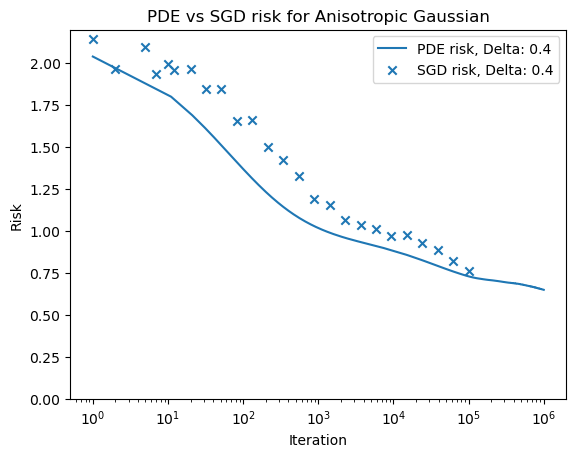

In [98]:
plt.plot(iters, pde_loss(iters),  label = 'PDE risk, Delta: 0.4')
plt.scatter(np.array(indices), risk_SGD, marker = 'x', label = 'SGD risk, Delta: 0.4')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('PDE vs SGD risk for Anisotropic Gaussian')
plt.ylim([0,2.2])

Text(0.5, 1.0, 'PDE vs SGD Mean value of a for Anisotropic Gaussian')

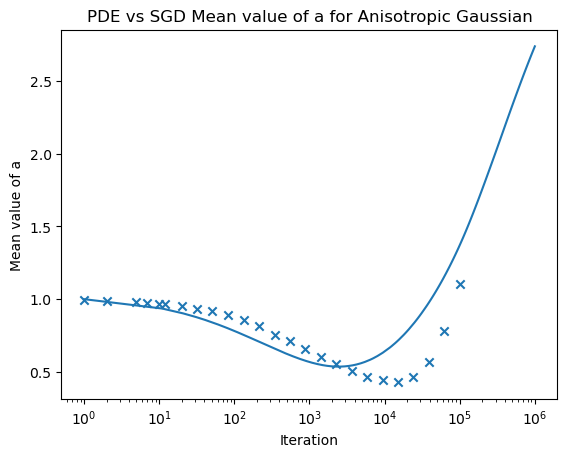

In [99]:
plt.plot(iters, avg_a_pde(iters), label = 'PDE mean value of a, Delta: 0.2')
plt.scatter(np.array(indices), a_SGD, marker = 'x', label = 'SGD mean value of b, Delta: 0.2')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Mean value of a')
plt.title('PDE vs SGD Mean value of a for Anisotropic Gaussian')

Text(0.5, 1.0, 'PDE vs SGD Mean value of r1 for Anisotropic Gaussian')

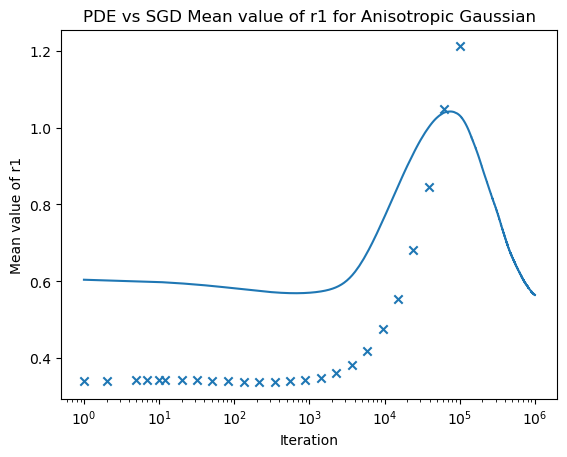

In [100]:
plt.plot(iters, avg_r1_pde(iters), label = 'PDE mean value of r1, Delta: 0.4')
plt.scatter(np.array(indices), r1_SGD, marker = 'x', label = 'SGD mean value of r1, Delta: 0.4')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Mean value of r1')
plt.title('PDE vs SGD Mean value of r1 for Anisotropic Gaussian')

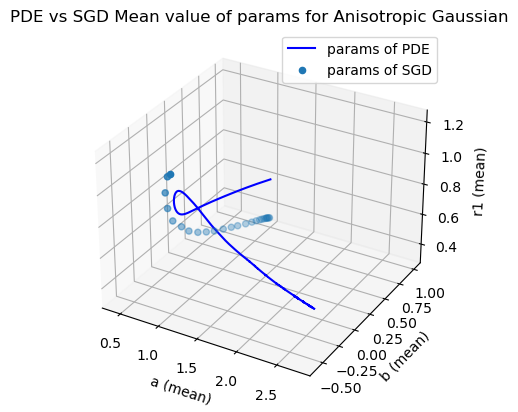

In [101]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(avg_a_pde(iters), avg_b_pde(iters), avg_r1_pde(iters), 'blue', label = 'params of PDE')
ax.scatter(a_SGD, b_SGD, r1_SGD, 'blue', label = 'params of SGD')
ax.set_title('3D Line plot')
ax.set_xlabel('a (mean)')
ax.set_ylabel('b (mean)')
ax.set_zlabel('r1 (mean)')
plt.title('PDE vs SGD Mean value of params for Anisotropic Gaussian')
plt.legend()
plt.show()

# General Observations

- The losses and parameter values observed during the SGD run matches relatively closely the respective values obtained by the distributional dynamics as expected, bearing in mind that the dimensionality of the problem was reduced by a factor of ten to speed up computations
- Here Nesterov accelerated SGD performs the best, outperforming plain SGD, and while in the beginning, the MF-HomSGLD matches the performance of plain SGD, it seems to get stuck for larger iterations.